<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>

<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces </b><br>  
    </font>
     <font size="3">
        Implementation notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Implementation__

## __Install components__

In [ ]:
!pip install editdistance
!pip install pandas_read_xml
!pip install requests

## __Import libraries__

In [8]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

## __Model__









In [2]:
class RankedWTAHash:

  def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', prototypesFilterThr=None, ngramms=3, similarityThreshold=None, maxOnly=None,earlyStop=0):
    '''
      Constructor
    '''
    self.max_numberOf_clusters = max_numberOf_clusters
    self.pairDictionary = dict()
    self.max_editDistance = max_editDistance
    self.windowSize = windowSize
    self.S_set = None 
    self.S_index = None 
    self.similarityThreshold = similarityThreshold
    self.maxOnly = maxOnly
    self.metric = metric
    self.min_numOfNodes = min_numOfNodes
    self.similarityVectors = similarityVectors
    self.number_of_permutations = number_of_permutations
    self.distanceMetric = distanceMetric
    self.distanceMetricEmbedding = distanceMetricEmbedding
    self.ngramms = ngramms
    self.jaccard_withchars =  jaccard_withchars
    self.prototypesFilterThr = prototypesFilterThr
    self.earlyStop = earlyStop
    self.selectionVariance = None
  
  def fit(self, X):
    """
      Fit the classifier from the training dataset.
      Parameters
      ----------
      X : Training data.
      Returns
      -------
      self : The fitted classifier.
    """
    print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

    if isinstance(X, list):
      input_strings = X
    else:
      input_strings = list(X)

    # print(input_strings)
    self.initialS_set = np.array(input_strings,dtype=object)
    self.S_set = np.array(input_strings,dtype=object)
    if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(self.S_set[i]), n=self.ngramms))
    elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(self.S_set[i], n=self.ngramms))
    # print(self.S_set)

    self.S_index = np.arange(0,len(input_strings),1)

    # print("\n\nString positions are:")
    # print(self.S_index)
    # print("\n")

    print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
    print("\n-> Finding prototypes and representatives of each cluster:")
    prototypes_time = time.time()
    self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
    print("\n- Prototypes selected")
    self.embeddingDim = self.prototypeArray.size
    print(self.prototypeArray)
    heatmapData = []
    for pr in self.prototypeArray:
        print(pr," -> ",self.initialS_set[pr])
        heatmapData.append(self.S_set[pr])
    if self.selected_numOfPrototypes > 2:
        self.selectionVariance = myHeatmap(self.prototypeArray,self.metric,self.EditDistance)
        print("\n- Mean variance in prototype selection: ",self.selectionVariance )
    print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
    prototypes_time = time.time() - prototypes_time
    print("\n# Finished in %.6s secs" % (prototypes_time))
    print("\n")
    
    if self.earlyStop==1:
        return self
    
    print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
    print("\n-> Creating Embeddings:")
    embeddings_time = time.time()
    self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
    print("- Embeddings created")
    print(self.Embeddings)
    embeddings_time = time.time() - embeddings_time
    print("\n# Finished in %.6s secs" % (embeddings_time))
    print("\n")

    if self.earlyStop==2:
        return self
    
    print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
    print("\n-> Creating WTA Buckets:")
    wta_time = time.time()
    self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
    print("- WTA buckets: ")
    for key in self.buckets.keys():
      print(key," -> ",self.buckets[key])
    print("\n- WTA number of buckets: ", len(self.buckets.keys()))
    print("\n- WTA RankedVectors after permutation:")
    print(self.rankedVectors)
    wta_time = time.time() - wta_time
    print("\n# Finished in %.6s secs" % (wta_time))
    print("\n")
    if self.earlyStop==3:
        return self

    print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
    print("\n-> Similarity checking:")
    if len(self.buckets.keys()) < 5:
        self.earlyStop=5
        return self
    
    similarity_time = time.time()

    if self.similarityVectors == 'ranked':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
    elif self.similarityVectors == 'initial':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)      
    else:
      warnings.warn("similarityVectors: Available options are: ranked,initial")
#     print("- Similarity matrix (all values compared):")
#     print(self.similarityProb_matrix)
    print("- Similarity mapping in a matrix")
    print(self.mapping_matrix)
    similarity_time = time.time() - similarity_time
    print("\n# Finished in %.6s secs" % (similarity_time))
    print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

    return self

  def EditDistance(self, str1,str2,verbose=False):
      if verbose:
        if str1 == None:
            print("1")
        elif str2 == None:
            print("2")
        print("-> "+str(str1))
        print("--> "+str(str2))
        print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))
      
      
      # NOTE: Duplicates inside the dictionary     

      if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
        return self.pairDictionary[(str1,str2)]
      else:
        # if verbose:
        # print("++++++++++")
        # print(str1,str2)
        # print(self.S_set[str1],self.S_set[str2])
        # print("++++++++++")
        if self.distanceMetric == 'edit':
            distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
        elif self.distanceMetric == 'jaccard':
#             print("-> "+str(self.initialS_set[str1]))
#             print("--> "+str(self.initialS_set[str2]))
            distance = jaccard_distance(self.S_set[str1],self.S_set[str2])
#             # jaccard because we want DISSIMILARITY 

#             print(distance)
        else:
            warnings.warn("Available metrics for space creation: edit, jaccard ")
        self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
        return distance

  #####################################################################
  # 1. Prototype selection algorithm                                  #
  #####################################################################

  '''
  Clustering_Prototypes(S,k,d,r,C) 
  The String Clustering and Prototype Selection Algorithm
  is the main clustering method, that takes as input the intial strings S, 
  the max number of clusters to be generated in k,
  the maximum allowable distance of a string to join a cluster in var d
  and returns the prototype for each cluster in array Prototype
  '''
  def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):
      
      # ----------------- Initialization phase ----------------- #
      i = 0
      j = 0
      C = np.empty([S.size], dtype=int)
      r = np.empty([2,k],dtype=object)

      Clusters = [ [] for l in range(0,k)]

      for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
          while j < k :       # iteration through clusters, for all clusters
              if r[0][j] == None:      # case empty first representative for cluster j
                  r[0][j] = S[i]   # init cluster representative with string i
                  C[i] = j         # store in C that i-string belongs to cluster j
                  Clusters[j].append(S[i])
                  break
              elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative 
                  r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string 
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              else:
                  j += 1
          i += 1

      # ----------------- Prototype selection phase ----------------- #
          
      Projections = np.empty([k],dtype=object)
      Prototypes = np.empty([k],dtype=int)
      sortedProjections = np.empty([k],dtype=object)

      Projections = []
      Prototypes = []
      sortedProjections = []

      if verbose:
          print("- - - - - - - - -")
          print("Cluster array:")
          print(C)
          print("- - - - - - - - -")
          print("Represantatives array:")
          print(r)
          print("- - - - - - - - -")  
          print("Clusters:")
          print(Clusters)
          print("- - - - - - - - -")  

      new_numofClusters = k

      # print("\n\n\n****** Prototype selection phase *********") 
      prototype_index = 0
      for j in range(0,k,1):
          
          # IF small cluster
          # print("Len ",len(Clusters[j]))
          if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
            new_numofClusters-=1
            continue

          Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))         
          # print(Projections[prototype_index])
          sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
          
          
          Prototypes.append(self.Median(sortedProjections[prototype_index]))
          # print(Prototypes[prototype_index])

          prototype_index += 1

      # print("\n****** END *********\n")
      Prototypes,new_numofClusters = self.optimize_clusterSelection(Prototypes,new_numofClusters)
      
      return np.array(Prototypes),new_numofClusters


  def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
      # print("here")
      # print(clusterSet)
      # print(right_rep, left_rep)

      distances_vector = dict()

      if len(clusterSet) > 2:
        rep_distance     = self.EditDistance(right_rep,left_rep)
                 
        for str_inCluster in range(0,len(clusterSet)): 
          if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
            # print(clusterSet[str_inCluster],right_rep,left_rep)
            right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
            left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])
            
            if rep_distance == 0: 
              distances_vector[clusterSet[str_inCluster]] = 0
            else:
              distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
              distances_vector[clusterSet[str_inCluster]] = distance
      
      else:
#         print("set: ",clusterSet)
#         print("left: ",left_rep)
#         print("right: ",right_rep)
        if left_rep != None and right_rep == None:
          distances_vector[left_rep] = left_rep
          # print("l")
        elif right_rep != None and left_rep == None:
          distances_vector[right_rep] = right_rep
          # print("r")
        elif left_rep == None and right_rep == None:
          return None
        elif left_rep != None and right_rep != None:
          distances_vector[right_rep] = right_rep
          distances_vector[left_rep]  = left_rep
      # print(distances_vector)
      return distances_vector

  def Median(self, distances):    
      '''
      Returns the median value of a vector
      '''
      keys = list(distances.keys())
      if keys == 1:
        return keys[0]

      # print(distances)
      keys = list(distances.keys())
      # print(keys)
      median_position = int(len(keys)/2)
      # print(median_position)
      median_value = keys[median_position]

      return median_value
  
  def optimize_clusterSelection(self,Prototypes,numOfPrototypes):
        
        notwantedPrototypes = []
        print(self.max_editDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]) < self.prototypesFilterThr:
                    notwantedPrototypes.append(Prototypes[pr_2]) 
#                     print("-> "+str(self.initialS_set[Prototypes[pr_1]]))
#                     print("--> "+str(self.initialS_set[Prototypes[pr_1]]))
#                     print(self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]))

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))           
        
        print("Prototypes before:")
        print(Prototypes)
        print("Not wanted:")
        print(set(notwantedPrototypes) )
        print("Final:")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)
  #####################################################################
  #       2. Embeddings based on the Vantage objects                  #
  #####################################################################

  '''
  CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
  '''
  def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):
      
      # ------- Distance computing ------- #     
      vectors = []
      for s in tqdm(range(0,S.size)):
          string_embedding = []
          for p in range(0,VantageObjects.size): 
              if VantageObjects[p] != None:
#                   print("-",VantageObjects[p])
                  string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))
              
          # --- Ranking representation ---- #
          ranked_string_embedding = stats.rankdata(string_embedding, method='dense')
          
          # ------- Vectors dataset ------- #
          vectors.append(ranked_string_embedding)
      
      return np.array(vectors)
      

  '''
  DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
  '''
  def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):
      
      if distanceMetricEmbedding == 'l_inf':
          max_distance = None

          for pp in range(0,VantageObjects.size):
              if VantageObjects[pp] != None:
                  string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                  VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                  abs_diff = abs(string_distance-VO_distance)

                  # --- Max distance diff --- #        
                  if max_distance == None:
                      max_distance = abs_diff
                  elif abs_diff > max_distance:
                      max_distance = abs_diff
          return max_distance
    
      elif distanceMetricEmbedding == 'edit':
          return self.EditDistance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'jaccard':
          return jaccard_distance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'euclid_jaccard':
          return sqrt(1-jaccard_distance(S[s],VantageObjects[p]))
      elif distanceMetricEmbedding == 'euclidean':
          return euclidean(S[s],VantageObjects[p])
      else:
          warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")
        

  def dropNone(array):
      array = list(filter(None, list(array)))
      return np.array(array)

  def topKPrototypes():
      return

  #####################################################################
  #                 3. Similarity checking                            # 
  #####################################################################

  def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):
    
#     print(buckets)
#     print(vectors)
    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]
    mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
    self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
    mapping = {}

    # Loop for every bucket
    for bucketid in tqdm(buckets.keys()):
      bucket_vectors = buckets[bucketid]
      numOfVectors = len(bucket_vectors)
      
      print(bucket_vectors)
      # For every vector inside the bucket
      for v_index in range(0,numOfVectors,1):
        v_vector_id = bucket_vectors[v_index]
        # Loop to all the other
        for i_index in range(v_index+1,numOfVectors,1):
          i_vector_id = bucket_vectors[i_index]
#           print('v_vector_id: ',v_vector_id,'i_vector_id: ',i_vector_id)
#           print(vectors[v_vector_id], " | ",vectors[i_vector_id])

          if vectorDim == 1:
            warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
            metric = 'kendal'

          if metric == None or metric == 'kendal':  # Simple Kendal tau metric
            similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'customKendal':  # Custom Kendal tau
            numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
            similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
          elif metric == 'jaccard':
            similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
          elif metric == 'cosine':
            similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
          elif metric == 'pearson':
            similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearman':
            similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearmanf':
            similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'hamming':
            similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
          elif metric == 'kruskal':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
              _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'ndcg_score':
            similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'rbo':
            similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'mannwhitneyu':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
               _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
          else:
            warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")
          
#           print("--",rbo(vectors[v_vector_id], vectors[i_vector_id]))
#           print(similarity_prob)
          self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
#           print("pr: ",self.similarityProb_matrix[v_vector_id][i_vector_id],similarity_prob)
          # if v_vector_id == 0:
#           print(v_vector_id, i_vector_id," : ",similarity_prob )        
          if similarity_prob > threshold:
            if v_vector_id not in mapping.keys():
              mapping[v_vector_id] = []
            mapping[v_vector_id].append(i_vector_id)  # insert into mapping
            mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
            mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix

    
    return mapping, np.triu(mapping_matrix)

  #####################################################################
  #                        4. WTA Hashing                             # 
  #####################################################################

  def WTA(self,vectors,K,inputDim, number_of_permutations):
    '''
      Winner Take All hash - Yagnik
      .............................

      K: window size
    '''
    newVectors = []
    buckets = dict()

    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]

    if vectorDim < K:
      K = vectorDim
      warnings.warn("Window size greater than vector dimension")
      
    C = np.zeros([numOfVectors,number_of_permutations], dtype=int)
    
#     X_new = np.array(vectors)
    
    permutation_dimension = inputDim
    for permutation_index in range(0,number_of_permutations,1):
        theta = np.random.permutation(permutation_dimension)
        i=0;j=0;
#         print(newVectors)
        for v_index in range(0,numOfVectors,1):
#           print(v_index)
          
          if permutation_index == 0:
#             print("Before: ",vectors[v_index])
            X_new = self.permuted(vectors[v_index],theta)
            newVectors.append(X_new)
          else:
#             print("Before: ",newVectors[v_index])
#             print(theta[:K])
            X_new = self.permuted(newVectors[v_index],theta)
            newVectors[v_index] = X_new
          
              
#           X_new = X_new[:K]
#           print("After: ",X_new)
#           print("X_new: ",X_new)
          C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
#           print("- ",index_max)
#           c_i = index_max

#           for j in range(0,K,1):
#             if X_new[j] > X_new[c_i]:
#               c_i = j

#           print("-> ",c_i)
#           C[i][permutation_index] = c_i
#           print(C)
          
          i+=1
        permutation_dimension = K

    for c,i in zip(C,range(0,numOfVectors,1)):
        buckets = self.bucketInsert(buckets,str(c),i)
#     print(C)
#     print(buckets)
    return C,buckets,np.array(newVectors,dtype=np.intp)

  def permuted(self,vector,permutation):
    permuted_vector = [vector[x] for x in permutation]
    return permuted_vector 

  def bucketInsert(self,buckets,bucket_id,item):
    if bucket_id not in buckets.keys():
      buckets[bucket_id] = []
    buckets[bucket_id].append(item)

    return buckets


In [4]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    return sdist/normalizer

def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0

import scipy.special as special

def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall
    
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

0.0
0.5225283643313485



# __Evaluation__

## Load data from Drive in Colab

In [5]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [9]:
CORA_groundTruth = os.path.abspath("data/coraIdDuplicates.csv")
CORA = os.path.abspath("data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA = pd.read_csv(CORA,sep='|')
CORA

Entity Id            address  \
0             0  los alamitos, ca:   
1             1                NaN   
2             2                NaN   
3             3                NaN   
4             4                NaN   
...         ...                ...   
1290       1290                NaN   
1291       1291                NaN   
1292       1292                NaN   
1293       1293                NaN   
1294       1294                NaN   

                                                 author  \
0     p. auer, n. cesa-bianchi, y. freund, and r. e....   
1     a. blum, m. furst, m. j. kearns, and richard j...   
2     avrim blum, merrick furst, michael kearns, and...   
3     avrim blum, merrick furst, michael kearns, and...   
4              a. blum, m. furst, m. kearns, r. lipton.   
...                                                 ...   
1290               robert e. schapire and yoram singer.   
1291  schapire, r. e., freund, y., bartlett, p., & l...   
1292   robert e. schapire and yoram singer. boostexter:   
1293                   robert e. schapire yoram singer.   
1294                   robert e. schapire yoram singer.   

                              editor institution month  \
0                                NaN         NaN   NaN   
1                                NaN         NaN   NaN   
2                                NaN         NaN   NaN   
3     in douglas r. stinson, editor,         NaN   NaN   
4                                NaN         NaN   NaN   
...                              ...         ...   ...   
1290                             NaN         NaN   NaN   
1291                             NaN         NaN   NaN   
1292                             NaN         NaN   NaN   
1293                             NaN         NaN   NaN   
1294                             NaN         NaN   NaN   

                                            note              pages  \
0                                            NaN       pp. 322-331.   
1                                            NaN  pages 24.1-24.10,   
2                                            NaN  pages 24.1-24.10,   
3     lecture notes in computer science no. 773.     pages 278-291.   
4                                            NaN                NaN   
...                                          ...                ...   
1290                                         NaN                NaN   
1291           annals of statistics (to appear).                NaN   
1292                                         NaN                NaN   
1293               submitted for publication. 17                NaN   
1294                  submitted for publication.                NaN   

                         publisher  \
0     ieee computer society press,   
1                              NaN   
2                              NaN   
3                        springer,   
4                              NaN   
...                            ...   
1290                           NaN   
1291                           NaN   
1292                           NaN   
1293                           NaN   
1294                           NaN   

                                                  title  \
0     'gambling in a rigged casino: the adversarial ...   
1     cryptographic primitives based on hard learnin...   
2     cryptographic primitives based on hard learnin...   
3     cryptographic primitives based on hard learnin...   
4     cryptographic primitives based on hard learnin...   
...                                                 ...   
1290  improved boosting algorithms using confidence-...   
1291  boosting the margin: a new explanation for the...   
1292  a system for multiclass multi-label text categ...   
1293  improved boosting algorithms using confidence-...   
1294  improved boosting algorithms using confidence-...   

                                                  venue volume     year  \
0     in proc. 36th annual symposium on foundatio

In [4]:
CORA_groundTruth

id1  id2
0      987  990
1      987  991
2      987  988
3      987  989
4      987  994
...    ...  ...
17179  206  210
17180  206  211
17181  206  212
17182  206  213
17183  206  214

[17184 rows x 2 columns]

#### CENSUS

In [16]:
CENSUS_groundTruth = os.path.abspath("data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
CENSUS

Entity Id     attr1      attr2 attr3 attr4      attr5  Unnamed: 6
0            0  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
1            1  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
2            2  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
3            3  ANDERSON        NaN   NaN  4848   BASSWOOD         NaN
4            4   AQUENDO      CLARA     J   666    STARKEY         NaN
..         ...       ...        ...   ...   ...        ...         ...
836        836   WILLIAM     SHERRY     V   510  WOODHAVEN         NaN
837        837    WRIGHT      BRYAN   NaN   307  WOODHAVEN         NaN
838        838    WRIGHT     MAXINE     H   307  WOODHAVEN         NaN
839        839     YATES     CHANSE     E   403  WOODHAVEN         NaN
840        840     YATES  ALFREDICA     S   403  WOODHAVEN         NaN

[841 rows x 7 columns]

In [17]:
CENSUS_groundTruth

id1  id2
0     85  530
1    427  816
2    360  748
3     18  462
4    299  692
..   ...  ...
339  433  827
340  366  755
341  651  652
342  226  602
343  305  701

[344 rows x 2 columns]

#### CDDB

In [18]:
CDDB_groundTruth = os.path.abspath("data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
CDDB

Entity Id|artist    category  \
0                              pink floyd        data   
1                          Carlos Santana        data   
2                             Frans Bauer        data   
3                                    2Pac        data   
4                                Ì¤ï¿½ï¿½        data   
...                                   ...         ...   
9758                              Various  soundtrack   
9759                      James Patterson  soundtrack   
9760      Colin Baker & Nicholas Courtney  soundtrack   
9761                          Studio Cutz  soundtrack   
9762  Audio Adventures In Time & Space/2)  soundtrack   

                                                cdextra       genre  \
0                                             ID3G: 254        Data   
1                                                   NaN         NaN   
2                                                   NaN       Other   
3                                   YEAR: 1998 ID3G: 15         Rap   
4                                                   NaN         NaN   
...                                                 ...         ...   
9758                                                NaN         NaN   
9759                                                NaN  Soundtrack   
9760  Published by Big Finish Productions.\nhttp://w...  Soundtrack   
9761                                           ID3G: 24  Soundtrack   
9762  Published by BBV.\nhttp://www.bbvonline.co.uk/...         NaN   

                             title          track01  \
0                  the wall disc 1     in the flesh   
1                           Carlos    (Da Le) Yaleo   
2                     'n ons geluk     'n ONS geluk   
3              Greatest Hits (CD1)  Keep Ya Head Up   
4                         Ì¤ï¿½ï¿½  ï¿½È¥ï¿½Ã¥ï¿½ 1   
...                            ...              ...   
9758            Warriors of Virtue      You Can Fly   
9759    Pop Goes the Weasel - CD 4             4.01   
9760    The Spectre of Lanyon Moor        Episode 0   
9761                     Volume 25  All Access 3:12   
9762  Prosperity Island (Disk 2/2)       Chapter 15   

                                         track02  \
0                                   the thin ice   
1                                Love Of My Life   
2                                            NaN   
3     2 Of Amerikaz Most Wanted (Ft. Snoop Dogg)   
4                                ï¿½È¥ï¿½Ã¥ï¿½ 2   
...                                          ...   
9758                         A Beautiful Morning   
9759                                        4.02   
9760                            Episode 1 Part 1   
9761                         All Access 3:12 alt   
9762                                  Chapter 16   

                               track03                         track04  \
0     another brick in the wall part 1  the happiest days of our lives   
1               Put You Love Lights On                          Smooth   
2                                  NaN                             NaN   
3                          Temptations              God Bless The Dead   
4                      ï¿½È¥ï¿½Ã¥ï¿½ 3                 ï¿½È¥ï¿½Ã¥ï¿½ 4   
...                                ...                             ...   
9758                  Forces of Nature                   Inside of You   
9759                              4.03                            4.04   
9760                  Episode 1 Part 2                Episode 1 Part 3   
9761                    All Access :60                  All Access :30   
9762                        Chapter 17                      Chapter 18   

                               track05  ... track92 track93 track94 track95  \
0     another brick in the wall part 2  ...     NaN     NaN     NaN     NaN   
1                 Do You Like The Way?  ...     NaN     NaN     NaN     NaN   
2                                  NaN  ...     NaN     NaN     NaN     NaN

In [19]:
CDDB_groundTruth

id1  id2
0    315  384
1    456  457
2     11   18
3    133  134
4     65  148
..   ...  ...
294  206  207
295  345  446
296  407  425
297  229  350
298  271  450

[299 rows x 2 columns]

#### DBLP - ACM

In [33]:
ACM = os.path.abspath("ACM.csv")
DBLP = os.path.abspath("DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### Cora - 1st edition

In [15]:
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
cora_dataframe = cora
cora_dataframe['@id'] = pd.to_numeric(cora_dataframe['@id']).subtract(1)

__Import true values__

In [8]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)

In [26]:
def myHeatmap(data,metric,distance):
    if metric == 'edit':    
        matrix  = np.zeros((len(data),len(data)), dtype=np.int)
    else:
        matrix = np.zeros((len(data),len(data)), dtype=np.float)
    
    for i in range(0,len(data),1):
        for j in range(0,len(data),1):
            if i != j:            
                matrix[i][j]  = distance(data[i],data[j])

                
    fif,ax = plt.subplots(1,figsize=(10,10))
    corr = np.corrcoef(matrix)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(matrix, linewidth=0.5,annot=False,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
    plt.show()
    return matrix.mean()

## __CORA Evaluation__

### Text Preprocess

In [5]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ").replace("'", " ").replace(";", " ")

    return str(paper_str)

### Shuffle data

In [10]:
shuffled_df = dataset.sample(frac=1).reset_index(drop=True)
# shuffled_df

### Inspecting CORA dataset 

In [6]:

def cora_createDataset(cora_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(cora_dataframe.iterrows()):
        index_to_id_dict[int(row['Entity Id'])] = i

        rawStr = []
        for field in fields:    # NAN
            print(row[field])
            if ((row[field] == None or row[field]=='NaN') and keepNone == True) or (keepNone == False and row[field] != None) :
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(cora_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
#             print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

#     print(cluster_dict)
#     print(clusters)
    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters

#### Dataset attributes

In [12]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

#### String length

In [21]:
data_length = [ len(x) for x in data ]
print("Dataset size: ",len(data)," strings-papers")
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

Dataset size:  1295  strings-papers
Average length: 103
Min length: 40
Max length: 351
Median length: 102


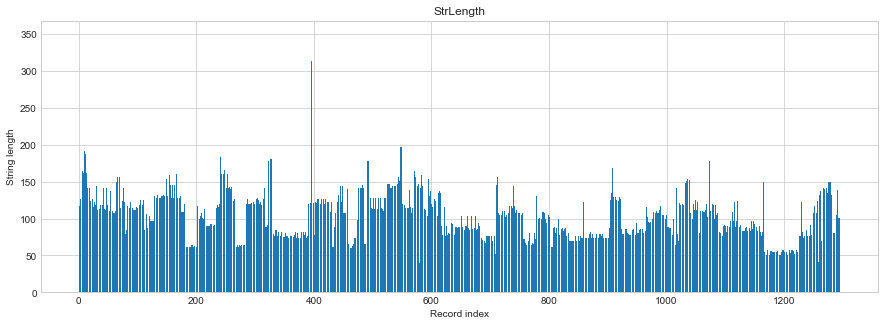

In [22]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [3]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = sparse.triu(true_matrix)
  # print(true_matrix)
  predicted_matrix =  sparse.triu(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


### Jaccard VS Edit distance variance

In [14]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [15]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

{('h', 'i', 's'), ('r', 'i', 'g'), ('f', ' ', 'b'), (' ', 'b', 'i'), ('m', 's', '!'), ('s', ' ', 'i'), ('d', ' ', 't'), ('b', 'i', 'g'), ('e', 'x', 'a'), ('a', 'n', 'd'), ('n', 'd', ' '), ('i', 'g', 'r'), ('r', 'a', 'm'), ('p', 'l', 'e'), (' ', 'i', 's'), ('a', 'n', ' '), ('n', ' ', 'e'), ('s', ' ', 'a'), ('l', 'e', ' '), ('t', 'r', 'i'), (' ', 'a', 'n'), ('m', 'm', 's'), ('m', 's', ' '), ('i', 's', ' '), ('o', 'f', ' '), (' ', 't', 'r'), ('e', ' ', 'o'), ('T', 'h', 'i'), ('m', 'p', 'l'), (' ', 'o', 'f'), ('x', 'a', 'm'), ('a', 'm', 'm'), (' ', 'e', 'x'), ('g', 'r', 'a'), ('a', 'm', 'p')}
{('of', 'bigramms', 'and'), ('This', 'is', 'an'), ('bigramms', 'and', 'trigramms'), ('and', 'trigramms', '!'), ('example', 'of', 'bigramms'), ('is', 'an', 'example'), ('an', 'example', 'of')}
0.0
0.0


### Prototype selection variance HeatMap

In [23]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()

In [18]:
s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard_distance(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard_distance(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

0.0784313725490196 0.22727272727272727 0.012987012987012988 0.13636363636363635
7


### Select fields for ER

In [10]:
fields = ['author', 'title', 'institution']

data, true_labels, true_matrix, clusters = cora_createDataset(CORA, CORA_groundTruth , fields)

Results dataframe

In [24]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

### CORA: Best Jaccard execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



0.25
Prototypes before:
[4, 8, 12, 14, 17, 22, 29, 31, 36, 38, 41, 46, 48, 50, 53, 56, 62, 64, 70, 73, 76, 78, 81, 88, 92, 97, 102, 106, 108, 111, 114, 116, 119, 122, 127, 130, 133, 146, 152, 155, 161, 168, 172, 178, 180, 190, 202, 206, 212, 232, 236, 242, 249, 265, 270, 274, 282, 287, 309, 313, 320, 323, 326, 328, 330, 332, 337, 341, 343, 345, 351, 356, 361, 369, 380, 389, 394, 397, 401, 404, 414, 423, 429, 431, 434, 438, 442, 447, 452, 458, 460, 462, 464, 466, 468, 471, 475, 479, 483, 485, 489, 509, 512, 514, 519, 522, 525, 540, 546, 549, 557, 563, 566, 571, 577, 584, 588, 593, 596, 598, 602, 607, 611, 615, 620, 625, 632, 634, 636, 640, 645, 648, 650, 653, 655, 658, 660, 663, 665, 668, 674, 676, 678, 682, 687, 691, 699, 705, 708, 713, 717, 721, 723, 726, 730, 741, 744, 748, 753, 756, 759, 765, 768, 774, 776, 778, 788, 794, 806, 812, 814, 817, 821, 824, 829, 833, 845, 858, 860, 873, 897, 907, 909, 919, 924, 933, 941, 944, 947, 950, 957, 961, 965, 967, 970, 989, 1008, 1012, 1015, 1019

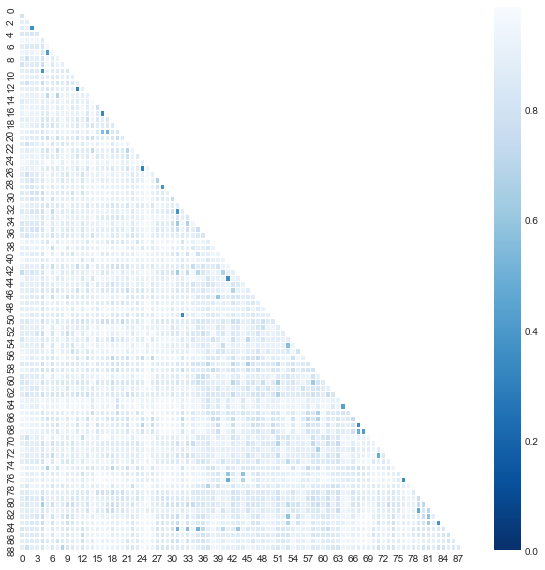


- Mean variance in prototype selection:  0.8686644911869302

- Final number of prototypes:  89

# Finished in 2.7889 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[56 57 61 ... 68 62 58]
 [ 1  3 35 ... 17 27 26]
 [ 1  4 38 ... 18 37 25]
 ...
 [79 66 51 ... 65 77 69]
 [67 73 48 ... 76 87 80]
 [67 73 48 ... 76 87 80]]

# Finished in 76.993 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:511: UserWarning: Window size greater than vector dimension


- WTA buckets: 
[83 43 34 10  4 84 88 17 71 24  4 19 27 51 66  2  8 45 70  9 11 45 10 76
 59 33 49 67 70 10]  ->  [0, 1, 5, 6, 7, 8, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 267, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 390, 391, 392, 393, 394, 395, 396, 399, 402,

[0, 1, 5, 6, 7, 8, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 267, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 390, 391, 392, 393, 394, 395, 396, 399, 402, 403, 404, 405, 406, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 432

NameError: name 'evaluate_cora' is not defined

In [27]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 0.3                 # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors




start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_editDistance= max_editDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### CORA: Best Edit distance execution


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[4, 8, 12, 14, 17, 22, 27, 31, 51, 53, 60, 64, 68, 70, 73, 76, 78, 82, 89, 97, 107, 112, 114, 116, 119, 125, 130, 140, 151, 153, 155, 161, 168, 173, 178, 180, 190, 202, 209, 232, 238, 242, 260, 265, 267, 277, 298, 312, 320, 323, 326, 332, 337, 341, 362, 378, 389, 394, 401, 405, 419, 423, 429, 431, 434, 438, 442, 447, 452, 458, 462, 475, 478, 489, 509, 512, 515, 532, 549, 557, 563, 567, 570, 572, 576, 584, 588, 593, 598, 603, 605, 608, 611, 615, 619, 625, 629, 636, 640, 647, 682, 698, 711, 713, 724, 741, 747, 756, 767, 778, 794, 806, 809, 832, 845, 858, 860, 873, 888, 897, 905, 907, 909, 918, 931, 967, 970, 986, 1008, 1012, 1015, 1020, 1022, 1025, 1033, 1038, 1040, 1045, 1047, 1051, 1055, 1057, 1064, 1069, 1072, 1079, 1084, 1087, 1099, 1107, 1111, 1114, 1117, 1119, 1128, 1134, 1147, 1153, 1155, 1158, 1161, 1165, 1170, 1172, 1184, 1208, 1225, 1228, 1230, 1234, 1244, 1246, 1251, 1255, 1258, 1263, 1269, 1273, 1279, 1281, 1286, 1290, 1294]
Not wanted:
{512, 897, 102

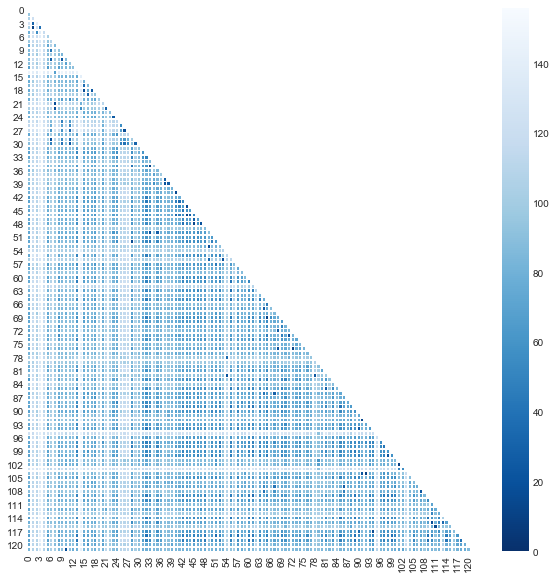


- Mean variance in prototype selection:  87.79011018543402

- Final number of prototypes:  122

# Finished in 1.8037 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[ 7 29 29 ... 18 10 17]
 [ 1 21 34 ... 10 11 18]
 [ 1 26 32 ... 13 13 19]
 ...
 [22 46 44 ... 14 26 25]
 [18 47 42 ... 17 33 28]
 [18 47 42 ... 17 33 28]]

# Finished in 82.587 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[80 83 14 81 85 81 87 30 20 15 51 15 86 57 89 20 88 18 76 36 97 11 51 26
 41 35 77 32 58 40]  ->  [0, 63, 64, 65, 66, 67, 68, 69, 70, 95, 96, 97, 98, 100, 103, 107, 108, 115, 116, 117, 118, 119, 123, 128, 131, 179, 180, 204, 205, 206, 207, 241, 262, 263, 264, 265, 296, 342, 388, 403, 407, 439, 440, 441, 447, 448, 451, 453, 455, 457, 458, 485, 491, 493, 495, 511, 521, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 581, 582, 

[0, 63, 64, 65, 66, 67, 68, 69, 70, 95, 96, 97, 98, 100, 103, 107, 108, 115, 116, 117, 118, 119, 123, 128, 131, 179, 180, 204, 205, 206, 207, 241, 262, 263, 264, 265, 296, 342, 388, 403, 407, 439, 440, 441, 447, 448, 451, 453, 455, 457, 458, 485, 491, 493, 495, 511, 521, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 581, 582, 583, 584, 585, 683, 711, 712, 713, 718, 724, 740, 743, 767, 775, 776, 966, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1067, 1154, 1261, 1266, 1273, 1280]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 99, 102, 104, 105, 106, 109, 110, 1

In [29]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = False                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 500                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_editDistance= 50                       # The threshold for the triangle inequality
distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 10                # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid'  # Embedding metric

# WTA algorithm
windowSize= 100                             # Vector size for WTA algo
number_of_permutations = 30                 # WTA number of permutations


# Similarity evaluation
similarityVectors='ranked'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors




start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_editDistance= max_editDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric=metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]

### Grid search each section

#### GridSearch function

In [22]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,withchars,prototypeFilter,earlyStop):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'prototypesFilterThr',"protSelectionVariance",'numOfPrototypes','numOfBuckets','averageBucketSize','Accuracy','Precision','Recall','F1','Time'])
    i=1
    for n1 in tqdm(max_numberOf_clusters):
        for n2 in (max_editDistance):
            for n3 in (similarityThreshold):
                for n4 in (windowSize):
                    for n5 in (metric):
                        for n6 in (similarityVectors):
                            for n7 in (distanceMetricEmbedding):
                                for n8 in (distanceMetric):
                                    for n9 in (number_of_permutations):
                                        for n10 in (withchars):
                                            for n11 in (withchars):
                                                for n12 in (prototypeFilter):
                                                    
                                                    print("+ ------------  ",i,"   ------------- +")
                                                    print('max_numberOf_clusters: ',n1)
                                                    print('max_editDistancez: ',n2)
                                                    print('similarityThreshold: ',n3)
                                                    print('windowSize: ',n4)
                                                    print('metric: ',n5)
                                                    print('similarityVectors: ',n6)
                                                    print('distanceMetricEmbedding: ',n7)
                                                    print('distanceMetric: ',n8)
                                                    print('number_of_permutations: ',n9)
                                                    print('withchars: ',n10)
                                                    print('ngramms: ',n11)
                                                    print('prototypeFilter: ',n12)
                                                    print("+ ----------------------------------- +")
                                                    start = time.time()
                                                    model = RankedWTAHash(
                                                      earlyStop = earlyStop,
                                                      max_numberOf_clusters= n1,
                                                      max_editDistance= n2,
                                                      windowSize= n4,
                                                      similarityThreshold= n3,
                                                      maxOnly= False,
                                                      metric=n5,
                                                      similarityVectors=n6,
                                                      number_of_permutations = n9,
                                                      distanceMetric= n8,
                                                      distanceMetricEmbedding = n7,
                                                      jaccard_withchars = n10,
                                                      ngramms= n11,                                                      
                                                      prototypesFilterThr = n12
                                                    )
                                                    model = model.fit(data)
                                                    exec_time = time.time() - start
                                                    if model.earlyStop==0:                                            
                                                        acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                                        for key in model.buckets.keys():
                                                            tempListmodel.buckets[key]
                                                        averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                        numOfBuckets=len(model.buckets.keys())
                                                    else:
                                                        if model.earlyStop == 3:
                                                            acc = f1 = precision = recall = 'Not counted'
                                                            averageBucketSize = np.mean([len(model.buckets[x]) for x in model.buckets.keys() ])
                                                            numOfBuckets=len(model.buckets.keys())
                                                        else:
                                                            numOfBuckets = averageBucketSize = acc = f1 = precision = recall = 'Not counted'
                                                    i+=1
                                                    results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n12,model.selectionVariance,model.selected_numOfPrototypes,numOfBuckets,averageBucketSize,acc,precision,recall,f1,exec_time]
    return results_dataframe

In [23]:
def highlight_columns(df, rows=20, color='lightyellow', columns_to_shadow=[], columns_to_show=[]):
    highlight = lambda slice_of_df: 'background-color: %s' % color
    sample_df = df.head(rows)
    if len(columns_to_show) != 0:
        sample_df = sample_df[columns_to_show]
    highlighted_df = sample_df.style.applymap(highlight, subset=pd.IndexSlice[:, columns_to_shadow])
    return highlighted_df

#### __[i]__ Fine tunning  __Prototype selection__


Goals:

- __Variance__: We want prototypes to be as much different as possible. This way, embeddings will be more characteristic.
- __Number__: We need a large amount of prototypes.

Parameters to fine tunne:

- ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
- ```max_editDistance```:  The threshold for the triangle inequality
- ```distanceMetric```:  Distance metric between the vectors when creating the space
- ```prototypesFilterThr```: Prototypes must differ more that threshold

All these parameters will be tested both for edit distance and jaccard with 3-grams.

+ ------------   1    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


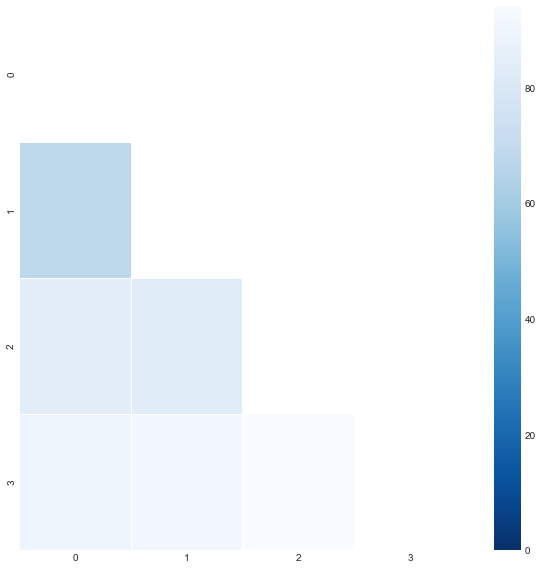


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.5147 secs


+ ------------   2    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


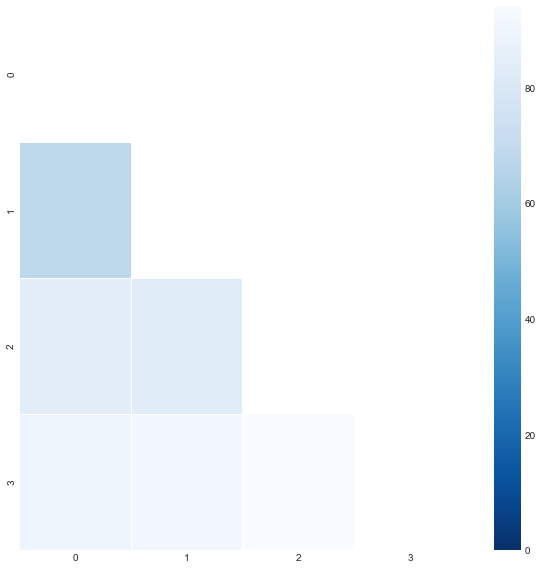


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.6833 secs


+ ------------   3    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


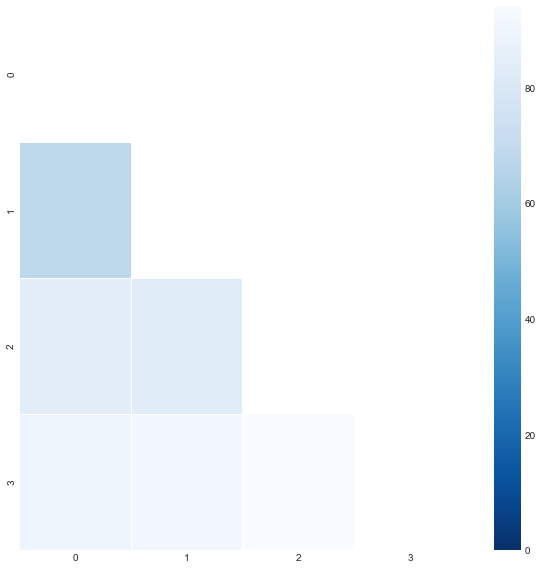


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.1947 secs


+ ------------   4    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{21}
Final:
[17, 3, 13]

- Prototypes selected
[17  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


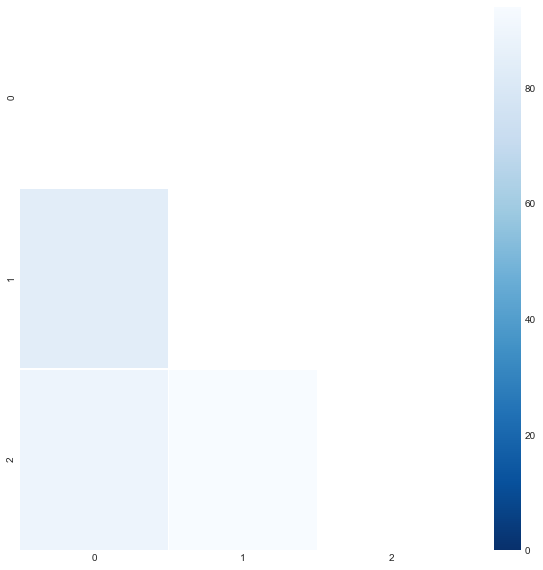


- Mean variance in prototype selection:  59.333333333333336

- Final number of prototypes:  3

# Finished in 0.1970 secs


+ ------------   5    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{17, 21, 13}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0210 secs


+ ------------   6    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#############################


50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


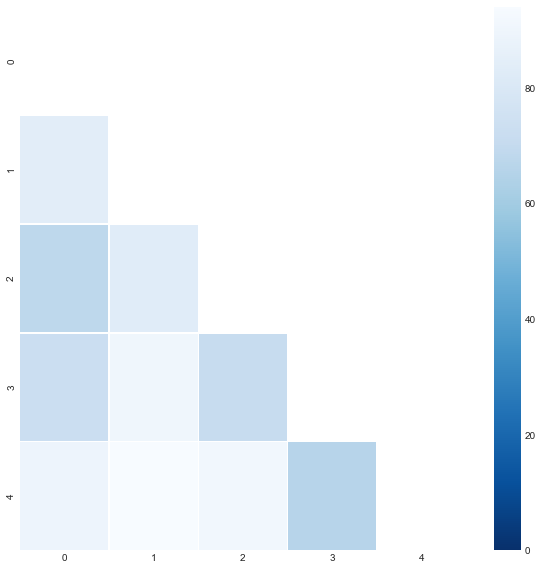


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.2140 secs


+ ------------   7    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


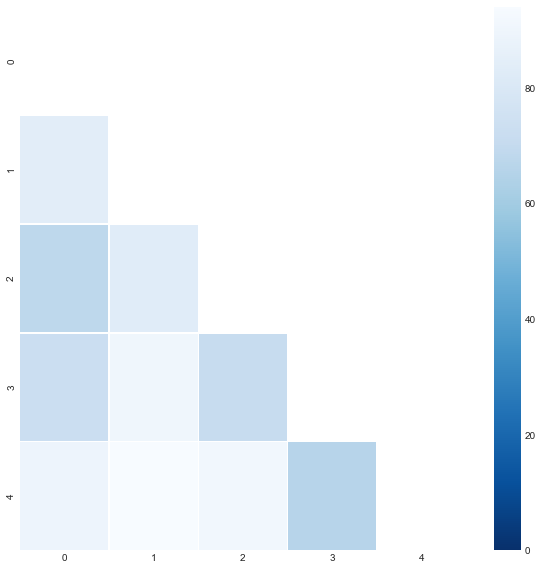


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1912 secs


+ ------------   8    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


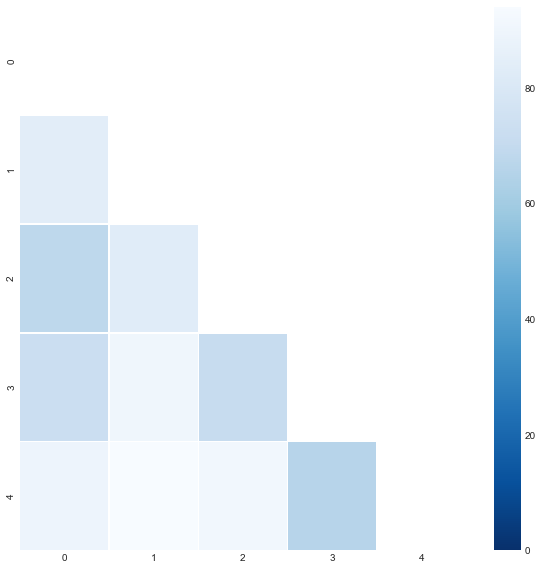


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1887 secs


+ ------------   9    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{21, 13}
Final:
[9, 3, 17]

- Prototypes selected
[ 9  3 17]
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan


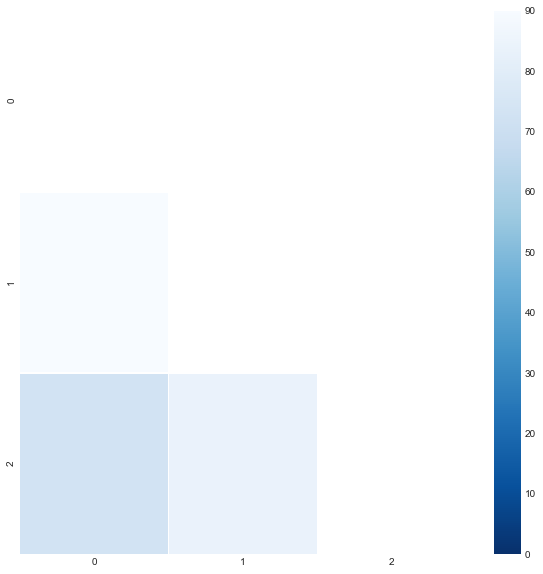


- Mean variance in prototype selection:  54.888888888888886

- Final number of prototypes:  3

# Finished in 0.1891 secs


+ ------------   10    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{9, 21, 13, 17}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0189 secs


+ ------------   11    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
######################


100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

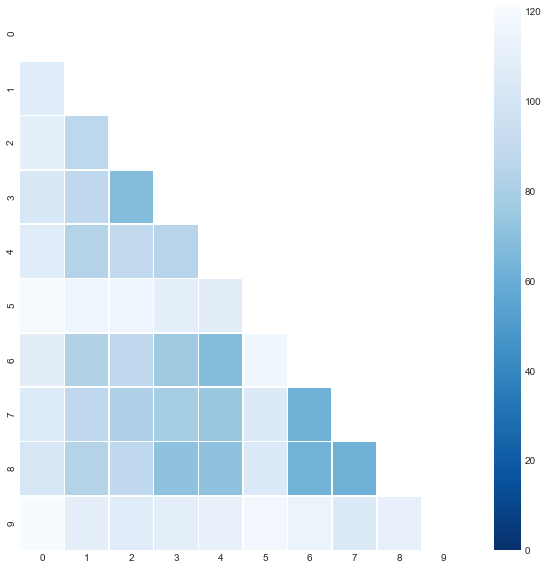


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2408 secs


+ ------------   12    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

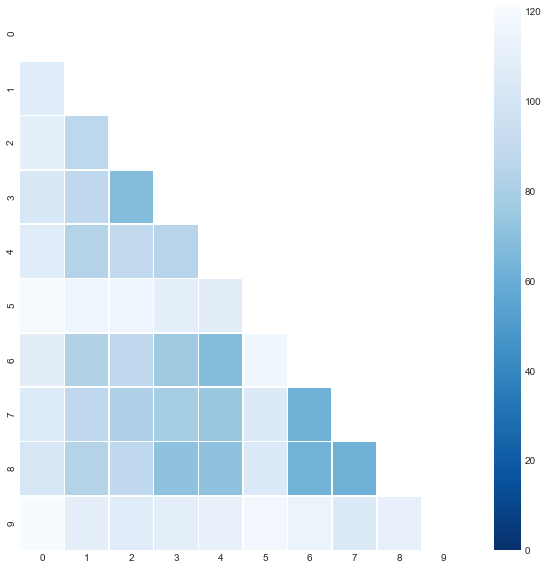


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2330 secs


+ ------------   13    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

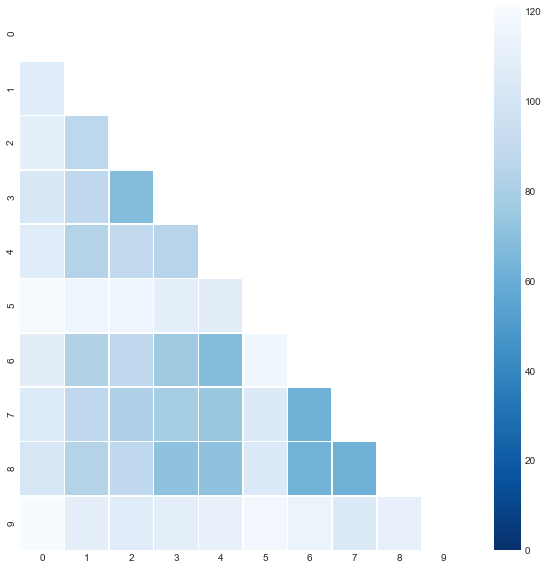


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2314 secs


+ ------------   14    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{24, 28, 21, 46}
Final:
[34, 3, 38, 17, 51, 30]

- Prototypes selected
[34  3 38 17 51 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


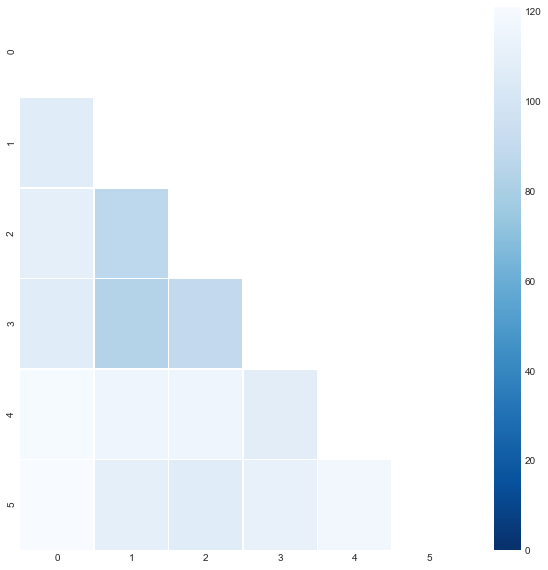


- Mean variance in prototype selection:  89.38888888888889

- Final number of prototypes:  6

# Finished in 0.2120 secs


+ ------------   15    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{38, 46, 17, 21, 24, 28}
Final:
[51, 34, 3, 30]

- Prototypes selected
[51 34  3 30]
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


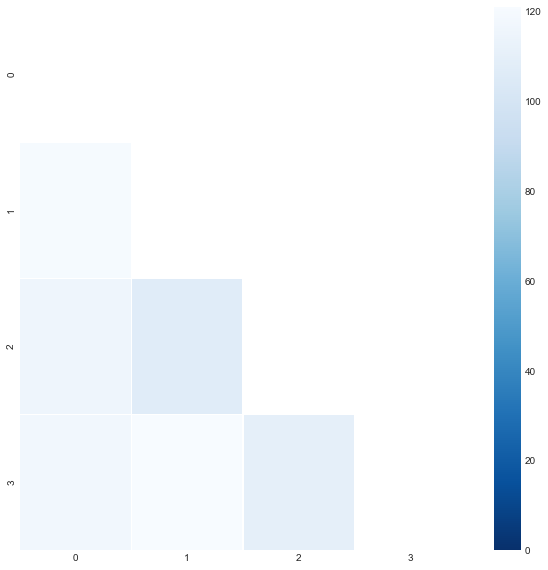


- Mean variance in prototype selection:  86.25

- Final number of prototypes:  4

# Finished in 0.2762 secs


+ ------------   16    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

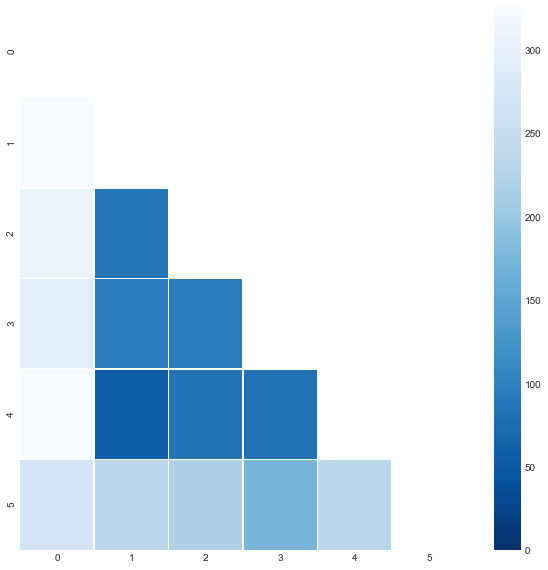


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2551 secs


+ ------------   17    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

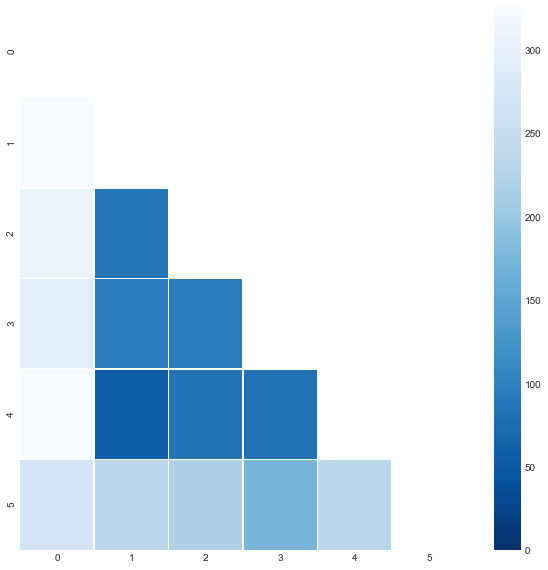


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2778 secs


+ ------------   18    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

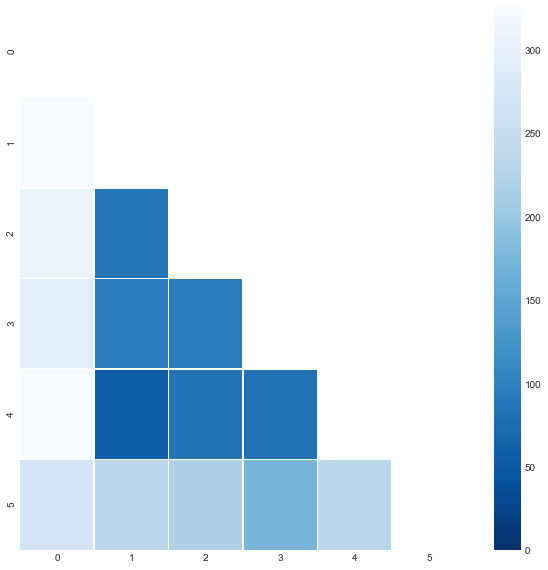


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2579 secs


+ ------------   19    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

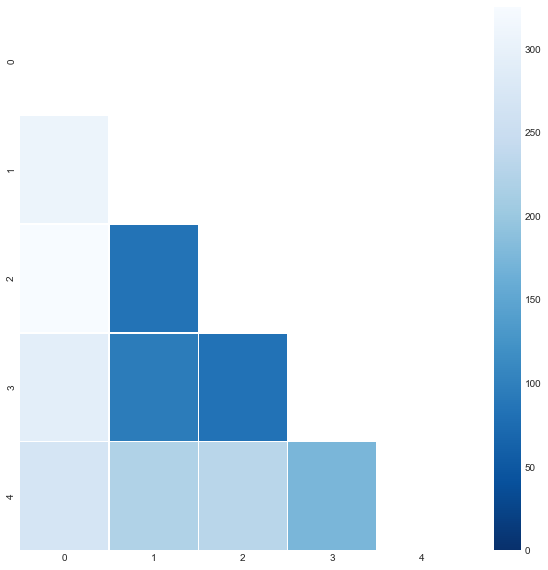


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2586 secs


+ ------------   20    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


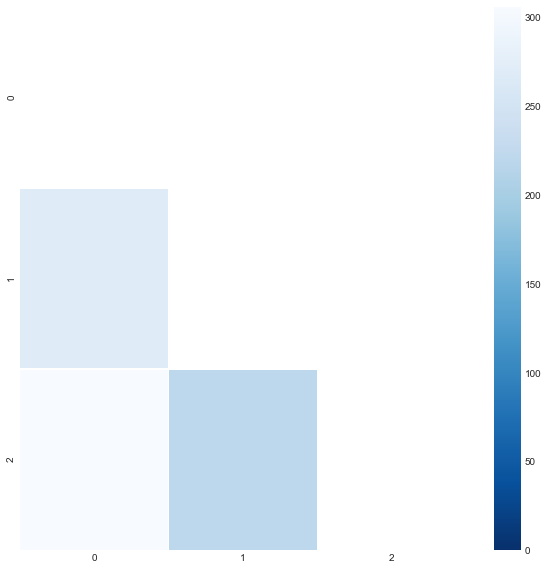


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2408 secs


+ ------------   21    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 136, 110, 244, 309, 250, 284, 190}
Final:
[384, 3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 41, 44, 47, 178, 51, 59, 65, 203, 97, 100, 105, 107]

- Prototypes selected
[384   3  13  17  21 405 152  28  30 415  32  34 419  39  41  44  47 178
  51  59  65 203  97 100 105 107]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  

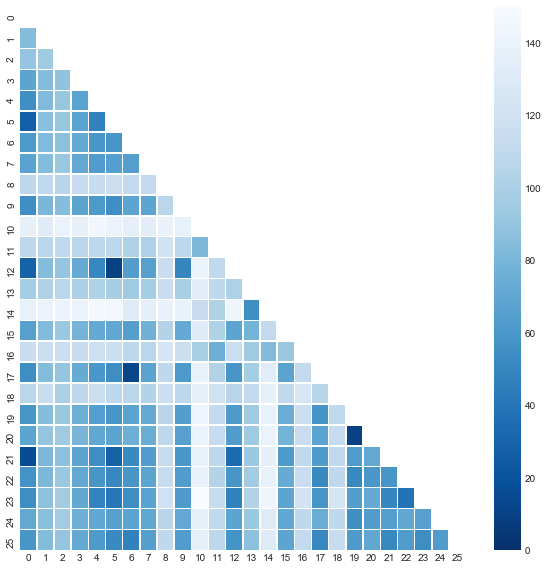


- Mean variance in prototype selection:  86.1508875739645

- Final number of prototypes:  26

# Finished in 0.4247 secs


+ ------------   22    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 136, 110, 178, 244, 309, 250, 284, 190}
Final:
[3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 100, 105, 107]

- Prototypes selected
[  3  13  17  21 405 152  28  30 415  32  34  39  41  44  47  51  59 203
  97 100 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
405  ->  s. fahlman. the recurrent cascade-correlation architecture. nan
152  ->  fahlman  s. e. an e

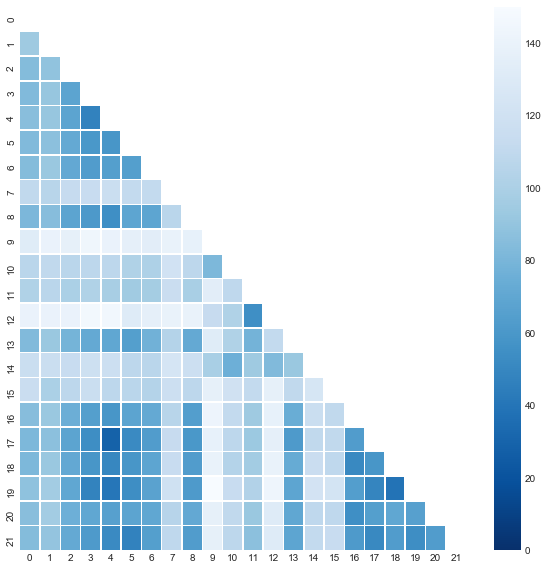


- Mean variance in prototype selection:  89.98347107438016

- Final number of prototypes:  22

# Finished in 0.3956 secs


+ ------------   23    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 100, 136, 110, 178, 244, 309, 405, 250, 284, 190}
Final:
[3, 13, 17, 21, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 105, 107]

- Prototypes selected
[  3  13  17  21 152  28  30 415  32  34  39  41  44  47  51  59 203  97
 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
152  ->  fahlman  s. e. an empirical study of learning speed in backpropagation networks. nan
28  ->  nan an 

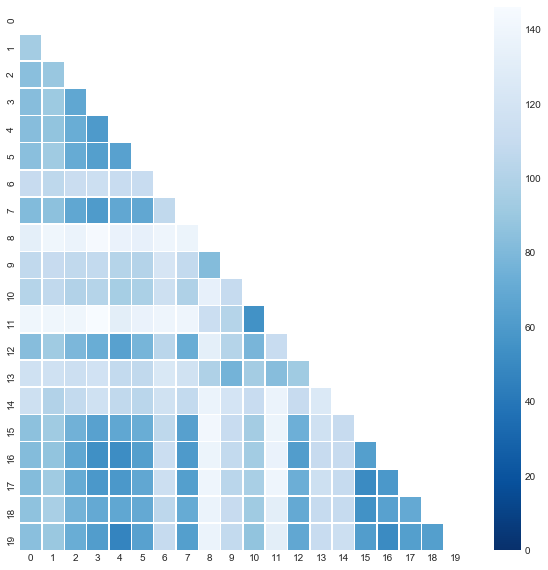


- Mean variance in prototype selection:  92.03

- Final number of prototypes:  20

# Finished in 0.3222 secs


+ ------------   24    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 21, 405, 152, 28, 284, 415, 160, 419, 41, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 34, 3, 39, 44, 13, 47, 17, 51, 30]

- Prototypes selected
[32 34  3 39 44 13 47 17 51 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
39  ->  m fahle and s edelman. long-term learning in vernier acuity: effects of stimulus orientation  range and of feedback. vision resear

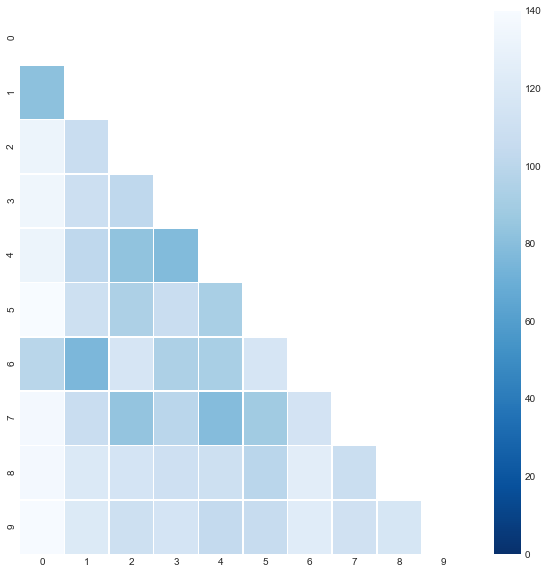


- Mean variance in prototype selection:  97.62

- Final number of prototypes:  10

# Finished in 0.3092 secs


+ ------------   25    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 13, 17, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 41, 44, 47, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 51, 3, 30]

- Prototypes selected
[32 51  3 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical soc

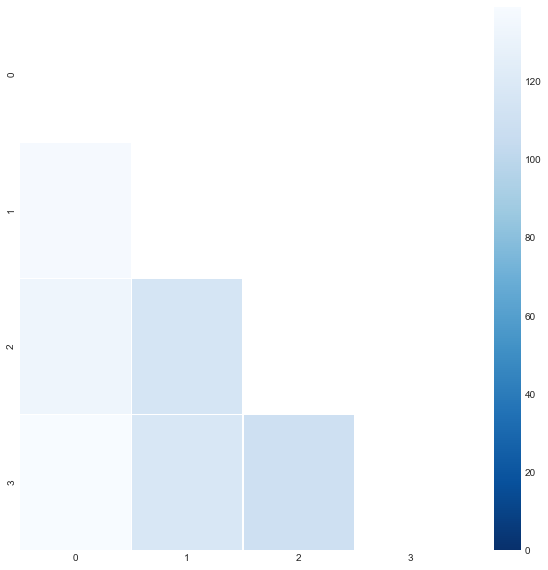


- Mean variance in prototype selection:  93.75

- Final number of prototypes:  4

# Finished in 0.2095 secs


+ ------------   26    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

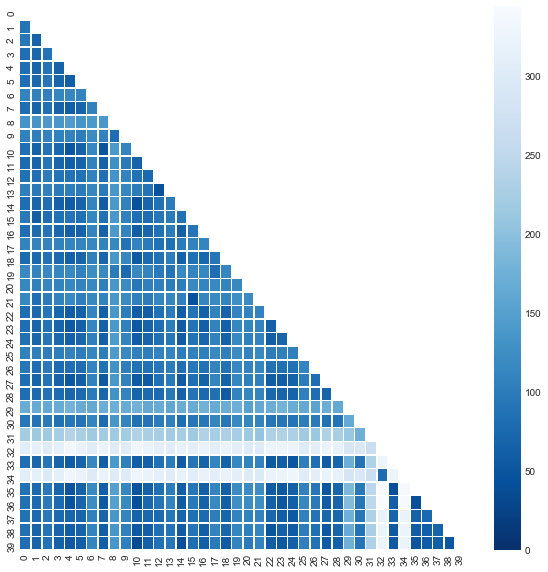


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.6150 secs


+ ------------   27    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

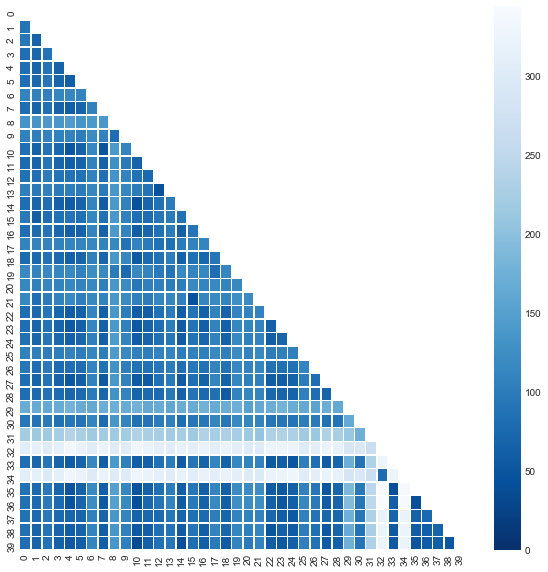


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.6189 secs


+ ------------   28    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{418, 100}
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34  36  38  40 424 426 428  45 430
  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 102 105
 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. act

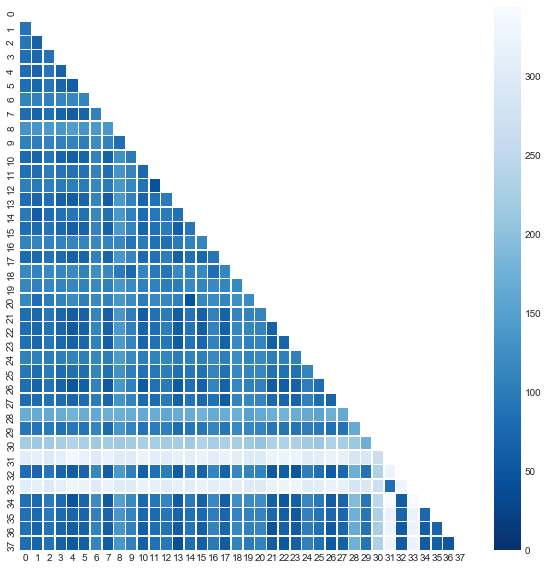


- Mean variance in prototype selection:  121.15789473684211

- Final number of prototypes:  38

# Finished in 0.5924 secs


+ ------------   29    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{13, 21, 28, 415, 418, 36, 424, 40, 426, 428, 430, 180, 442, 60, 456, 462, 97, 100, 102, 105, 117, 253}
Final:
[32, 480, 34, 3, 451, 453, 38, 482, 9, 45, 47, 432, 17, 51, 467, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453  38 482   9  45  47 432  17  51 467 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the

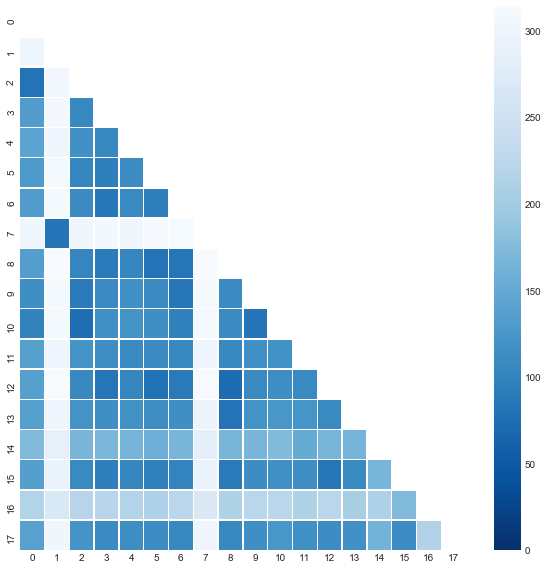


- Mean variance in prototype selection:  155.25925925925927

- Final number of prototypes:  18

# Finished in 0.3059 secs


+ ------------   30    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{9, 13, 17, 21, 28, 415, 418, 34, 36, 38, 424, 40, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 453, 456, 462, 472, 97, 482, 100, 102, 105, 117, 253}
Final:
[32, 480, 3, 451, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the monk's problems: a performance comparison o

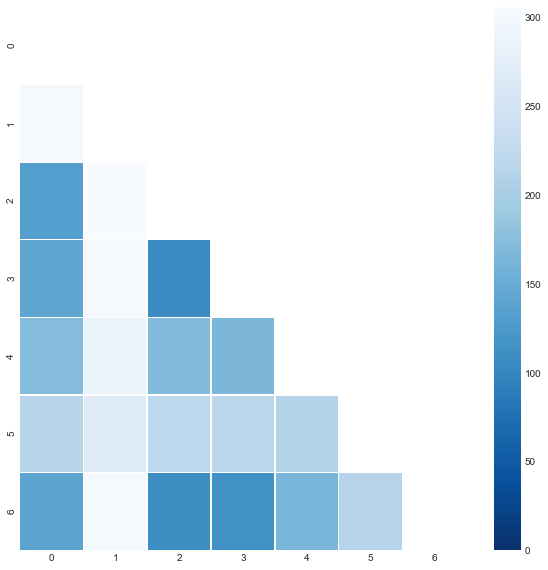


- Mean variance in prototype selection:  173.87755102040816

- Final number of prototypes:  7

# Finished in 0.2306 secs


+ ------------   31    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

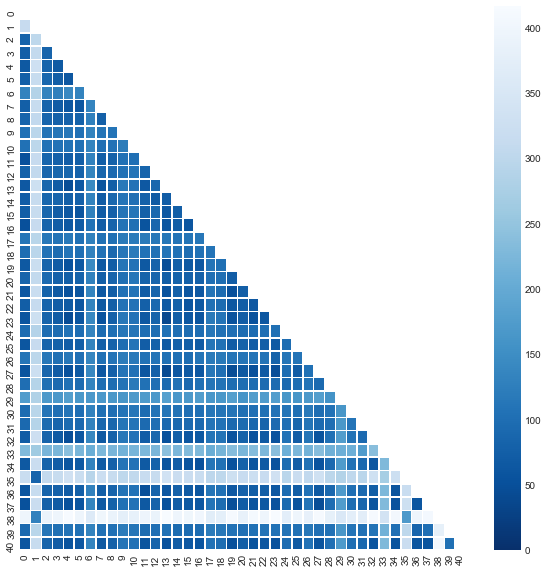


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7438 secs


+ ------------   32    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

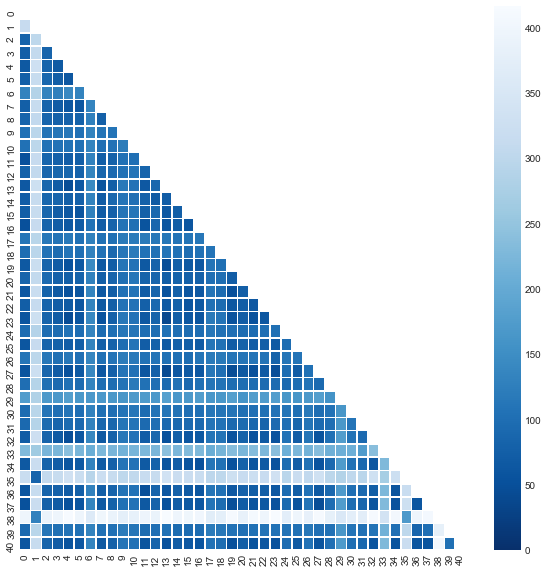


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7079 secs


+ ------------   33    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

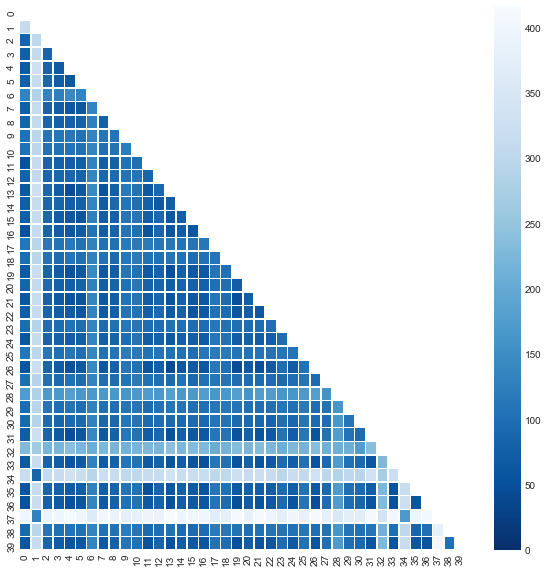


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6878 secs


+ ------------   34    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

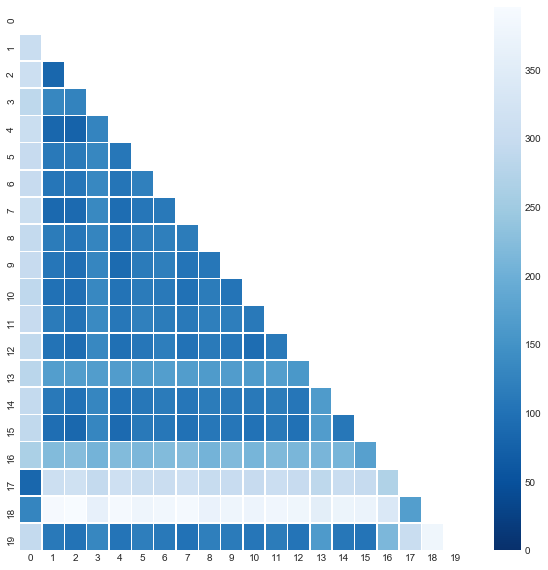


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.4122 secs


+ ------------   35    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

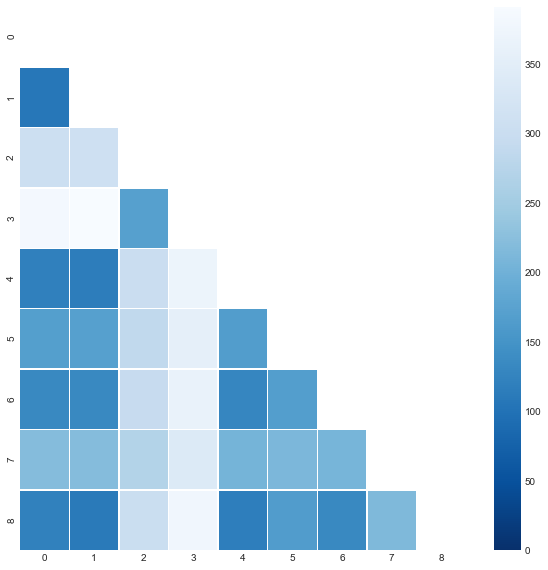


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3449 secs


+ ------------   36    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

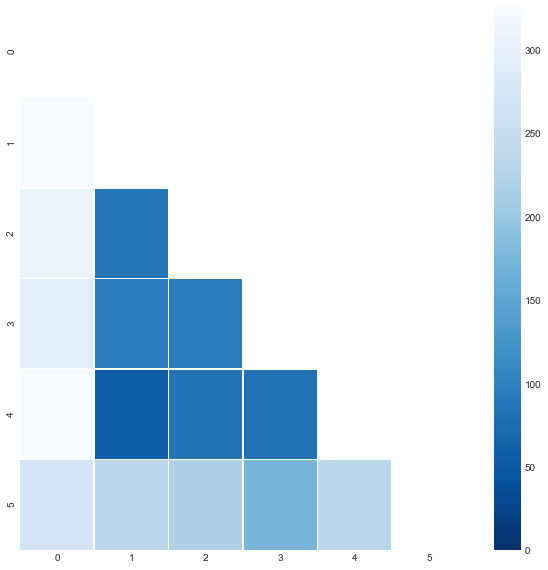


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3009 secs


+ ------------   37    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

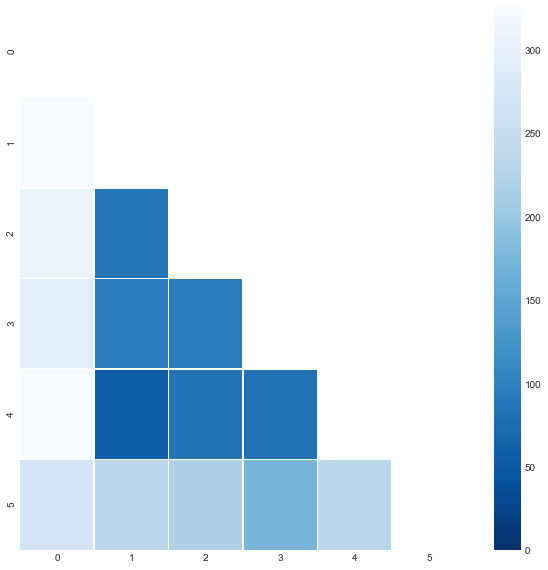


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3569 secs


+ ------------   38    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

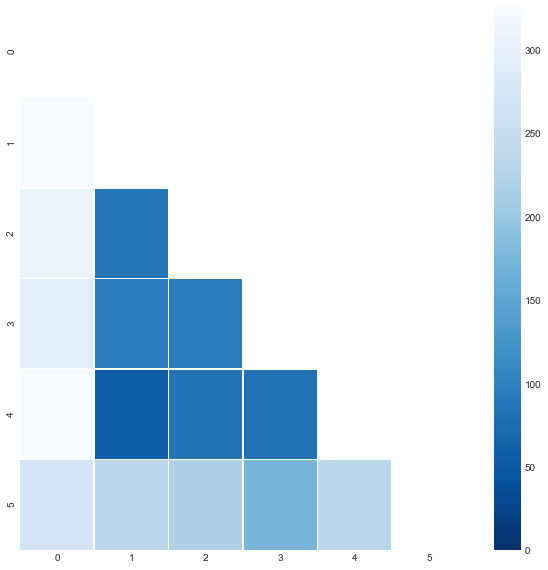


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2828 secs


+ ------------   39    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

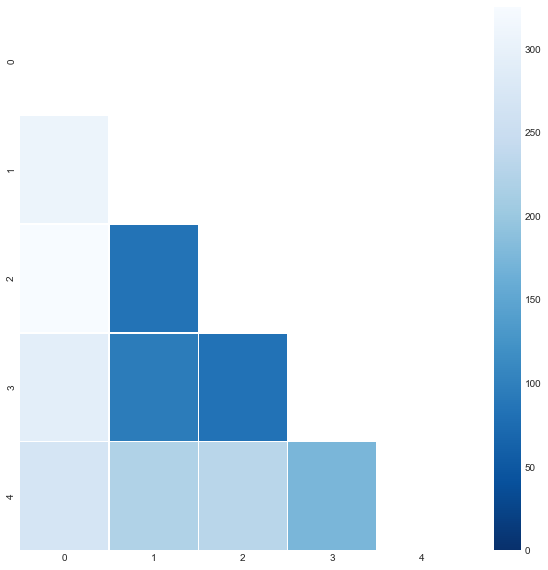


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2562 secs


+ ------------   40    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


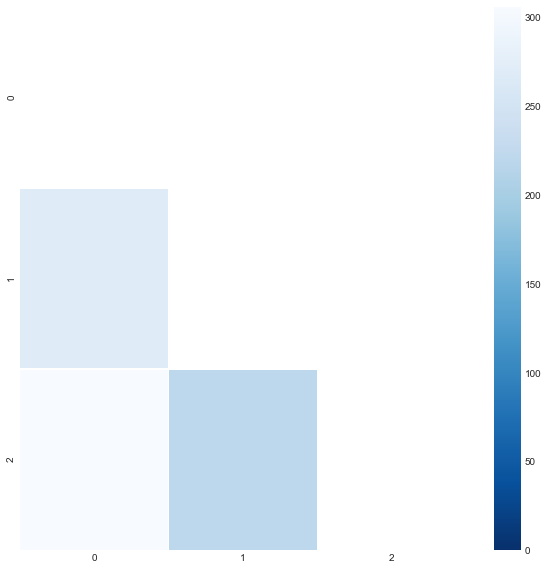


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2481 secs


+ ------------   41    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 515, 136, 488, 492, 110, 244, 309, 250, 284, 190, 511}
Final:
[384, 3, 518, 13, 525, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 424, 41, 426, 44, 47, 178, 51, 562, 442, 59, 65, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504, 507]

- Prototypes selected
[384   3 518  13 525  17 531  21 405 152  28  30 415  32  34 419  39 424
  41 426  44  47 178  51 562 442  59  65 451 453 456 203 462 472 477 480
  97 482 100 484 486 105 107 496 501 504 507]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. ander

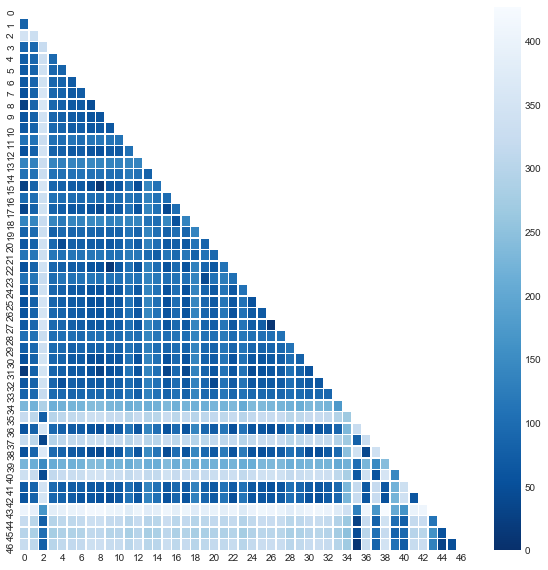


- Mean variance in prototype selection:  161.22951561792667

- Final number of prototypes:  47

# Finished in 0.6003 secs


+ ------------   42    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 65, 384, 419, 515, 136, 488, 492, 110, 178, 244, 309, 250, 507, 284, 190, 511}
Final:
[3, 518, 525, 13, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 39, 424, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504]

- Prototypes selected
[  3 518 525  13  17 531  21 405 152  28  30 415  32  34  39 424  41 426
  44  47 562  51 442  59 451 453 456 203 462 472 477 480  97 482 100 484
 486 105 107 496 501 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
518  ->  thurn  s. b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  d

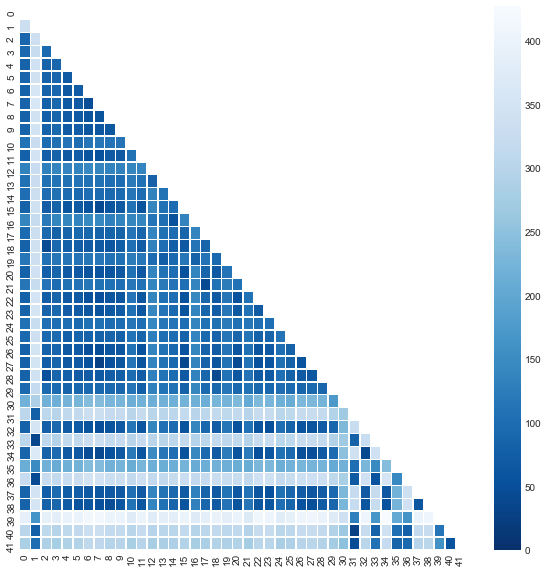


- Mean variance in prototype selection:  162.77324263038548

- Final number of prototypes:  42

# Finished in 0.6472 secs


+ ------------   43    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 405, 284, 160, 419, 424, 178, 309, 190, 65, 100, 488, 492, 110, 244, 501, 250, 507, 511}
Final:
[3, 525, 13, 17, 531, 21, 152, 28, 30, 415, 32, 34, 39, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 484, 486, 105, 107, 496, 504]

- Prototypes selected
[  3 525  13  17 531  21 152  28  30 415  32  34  39  41 426  44  47 562
  51 442  59 451 453 456 203 462 472 477 480  97 482 484 486 105 107 496
 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
525  ->  weiss  y.  edelman  s.  and fahle  m. models of perceptual learning in vernier hyperacuity. neu

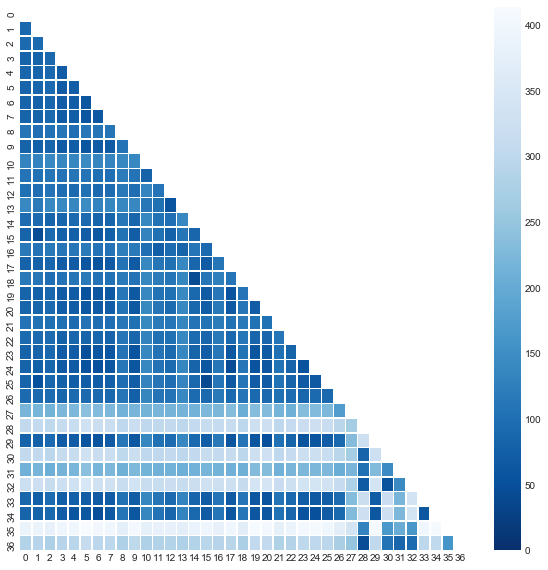


- Mean variance in prototype selection:  155.40102264426588

- Final number of prototypes:  37

# Finished in 0.6171 secs


+ ------------   44    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 525, 531, 21, 405, 152, 28, 284, 415, 160, 419, 424, 41, 426, 178, 562, 309, 442, 59, 190, 65, 456, 203, 462, 97, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 34, 3, 451, 453, 482, 39, 484, 44, 13, 47, 496, 17, 51, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453 482  39 484  44  13  47 496  17  51 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman

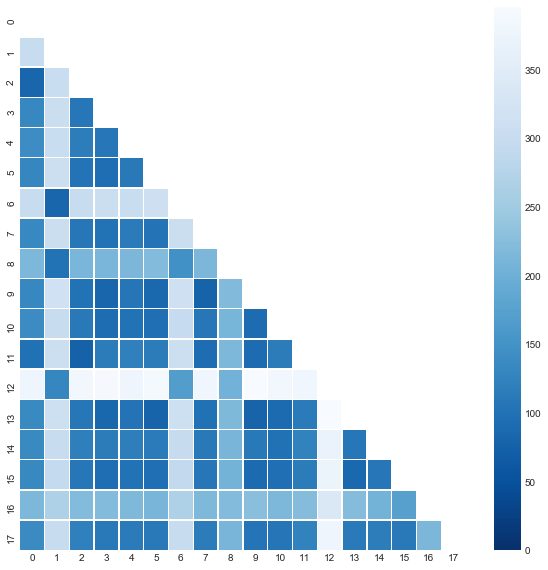


- Mean variance in prototype selection:  177.7716049382716

- Final number of prototypes:  18

# Finished in 0.3469 secs


+ ------------   45    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 13, 525, 17, 531, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 424, 41, 426, 44, 47, 178, 562, 309, 442, 59, 190, 65, 451, 453, 456, 203, 462, 472, 97, 482, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 3, 484, 496, 51, 477, 30]

- Prototypes selected
[ 32 480   3 484 496  51 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. k

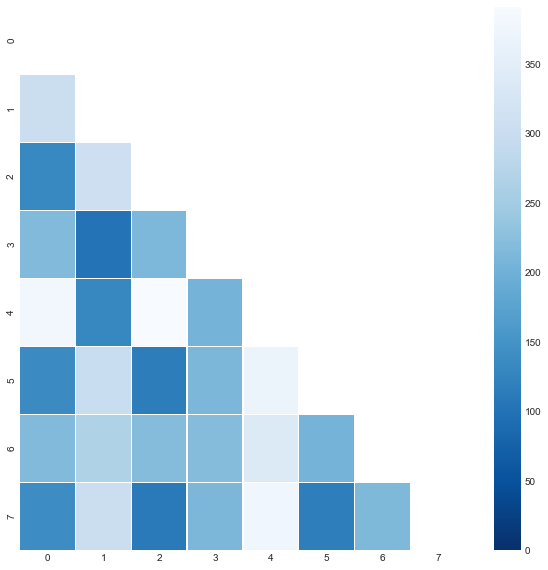


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.3421 secs


+ ------------   46    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 492, 1015, 755, 503, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 842, 852, 857, 603, 97, 867, 100, 102, 105, 874, 883, 117, 888, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 1017, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

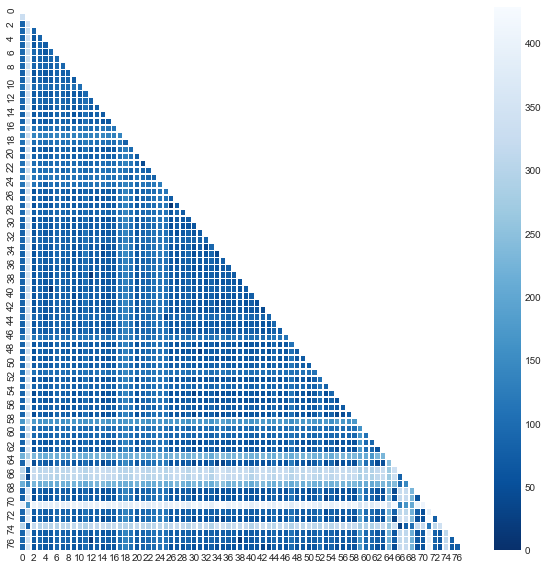


- Mean variance in prototype selection:  121.16995397764629

- Final number of prototypes:  78

# Finished in 0.7640 secs


+ ------------   47    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 842, 492, 883, 1015, 755, 503, 888, 1017, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 852, 857, 603, 97, 867, 100, 102, 105, 874, 117, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

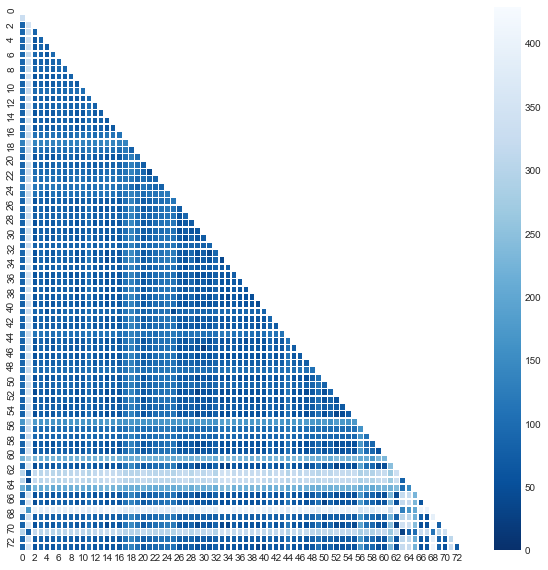


- Mean variance in prototype selection:  123.53287070854638

- Final number of prototypes:  74

# Finished in 0.7430 secs


+ ------------   48    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 418, 948, 713, 842, 720, 857, 734, 503, 100, 488, 492, 1006, 1011, 500, 883, 755, 1015, 888, 1017, 1021, 510}
Final:
[3, 774, 520, 9, 778, 525, 13, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 821, 442, 60, 702, 451, 708, 453, 711, 456, 462, 467, 852, 725, 472, 729, 603, 731, 477, 480, 97, 482, 867, 484, 102, 105, 745, 874, 496, 1009, 117, 1013, 253]

- Prototypes selected
[   3  774  520    9  778  525   13  783  528   17  785  531  788   21
  792   28   

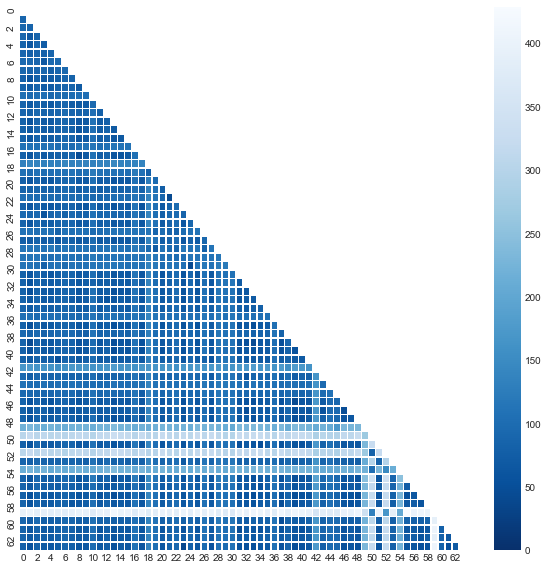


- Mean variance in prototype selection:  118.31640625

- Final number of prototypes:  64

# Finished in 0.6480 secs


+ ------------   49    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 774, 518, 778, 13, 525, 783, 528, 531, 788, 21, 792, 28, 415, 418, 36, 424, 40, 426, 428, 430, 948, 180, 821, 442, 60, 702, 708, 711, 456, 713, 842, 462, 720, 852, 729, 857, 731, 603, 734, 97, 867, 100, 503, 102, 488, 745, 874, 105, 492, 1006, 1009, 1017, 755, 883, 117, 1011, 1013, 1015, 253, 888, 500, 1021, 510}
Final:
[3, 520, 9, 17, 785, 30, 32, 34, 38, 45, 47, 432, 51, 451, 453, 467, 725, 472, 477, 480, 482, 484, 496]

- Prototypes selected
[  3 520   9  17 785  30  32  34  38  45  47 432  51 451 453 467 725 472
 477 480 48

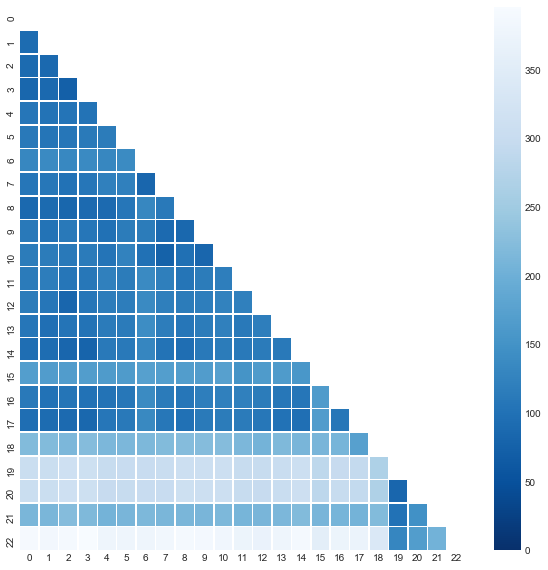


- Mean variance in prototype selection:  169.99243856332703

- Final number of prototypes:  23

# Finished in 0.4441 secs


+ ------------   50    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 520, 9, 13, 525, 528, 17, 531, 21, 28, 34, 36, 38, 40, 45, 47, 51, 60, 603, 97, 100, 102, 105, 117, 180, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 253, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 415, 418, 424, 426, 428, 430, 432, 948, 442, 453, 456, 462, 472, 482, 488, 492, 1006, 1009, 1011, 1015, 1013, 500, 503, 1017, 1021, 510}
Final:
[32, 480, 3, 451, 484, 496, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 484 496 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(

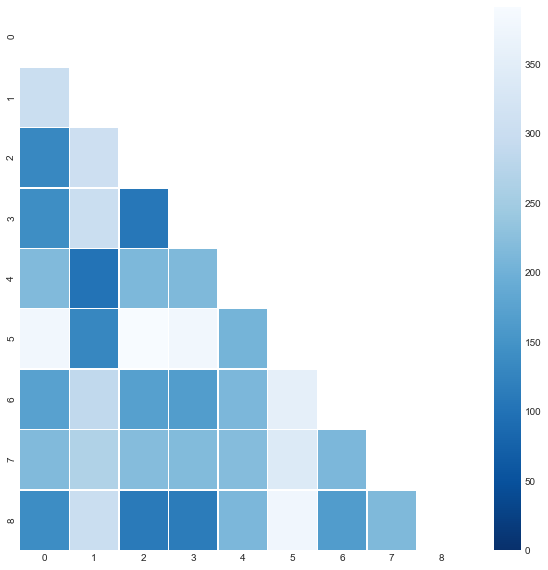


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.3041 secs


+ ------------   51    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

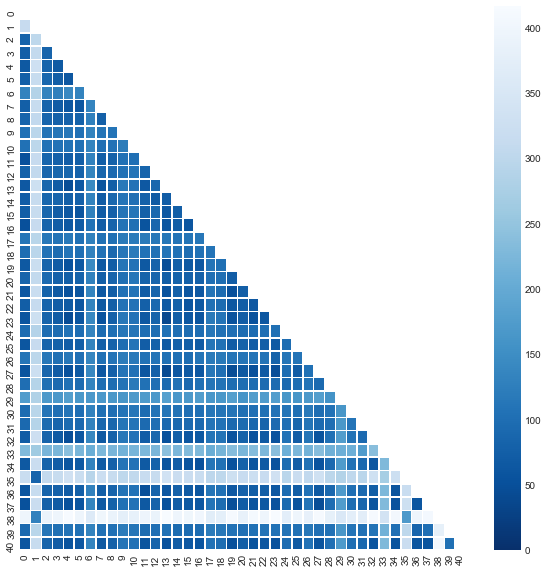


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7164 secs


+ ------------   52    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

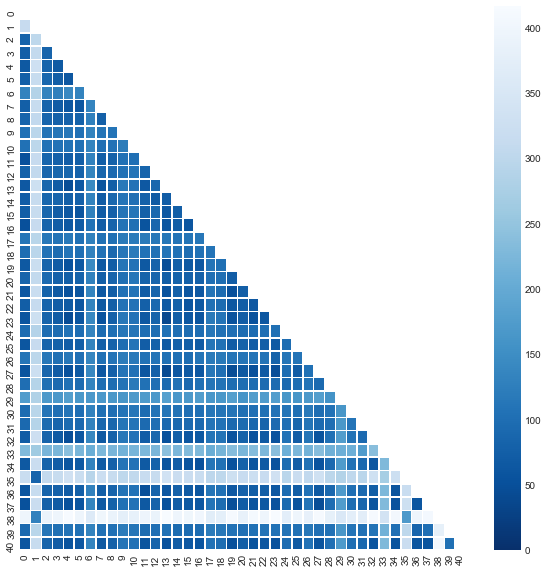


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6705 secs


+ ------------   53    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

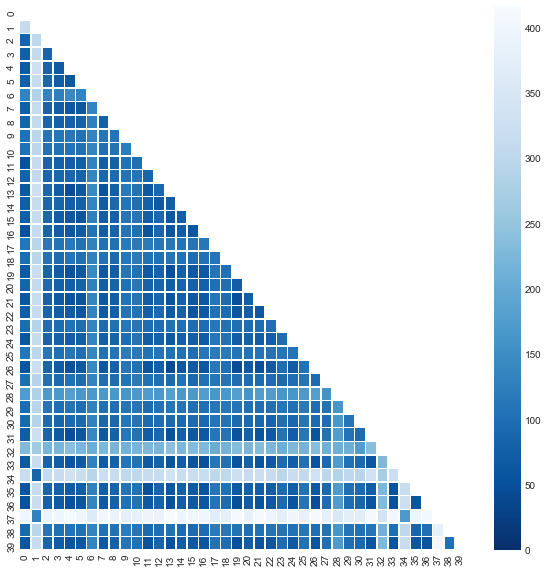


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6384 secs


+ ------------   54    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

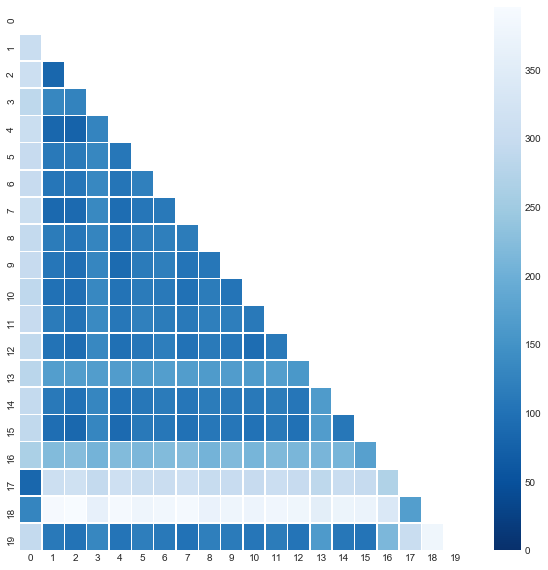


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3688 secs


+ ------------   55    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

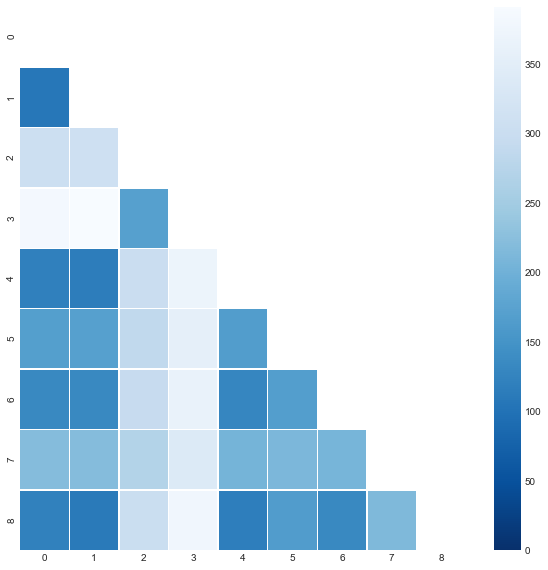


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2869 secs


+ ------------   56    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

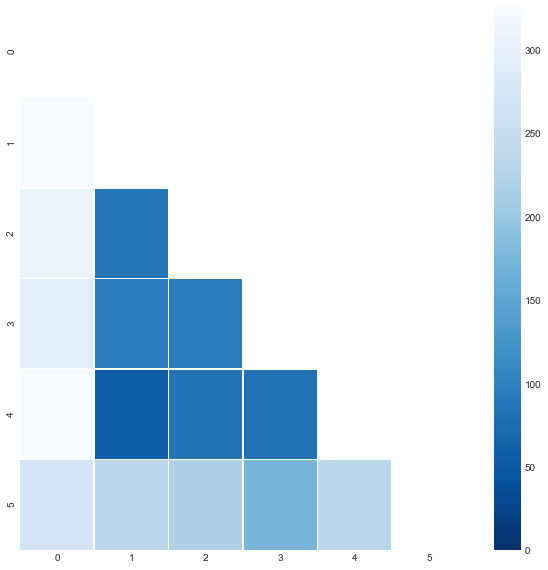


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2642 secs


+ ------------   57    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

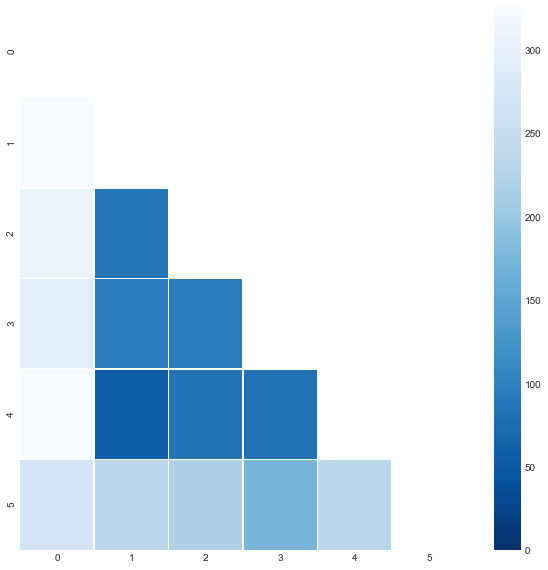


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2682 secs


+ ------------   58    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

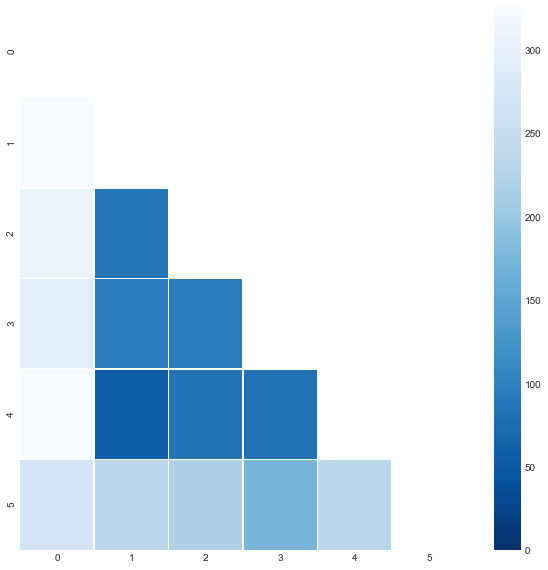


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2649 secs


+ ------------   59    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

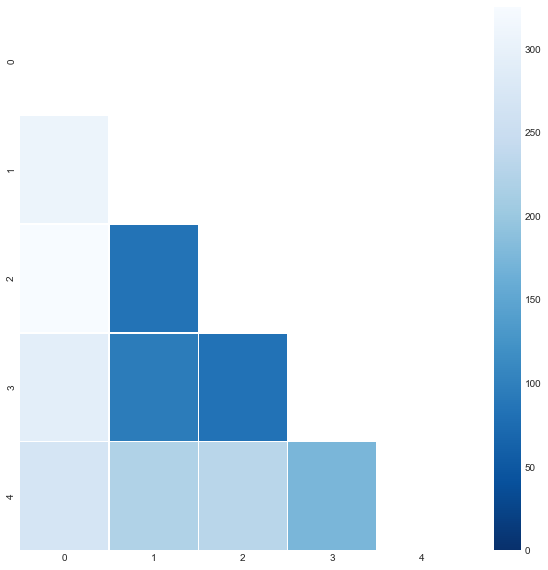


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2611 secs


+ ------------   60    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


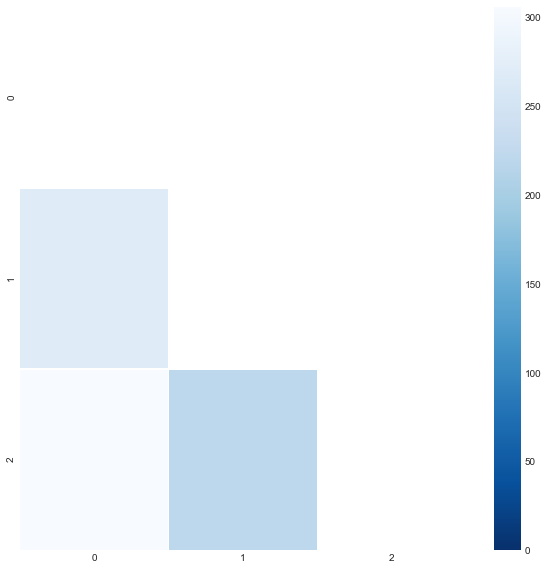


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2938 secs


+ ------------   61    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

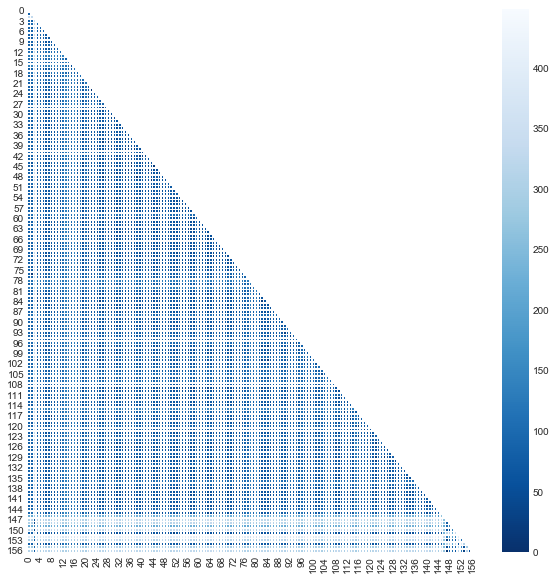


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.3190 secs


+ ------------   62    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

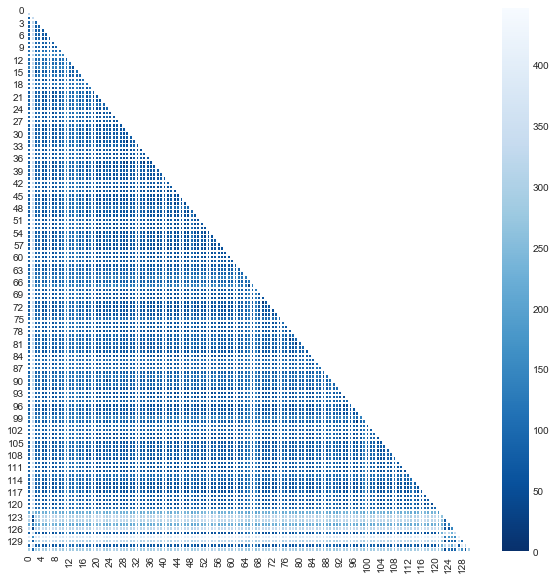


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.0455 secs


+ ------------   63    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

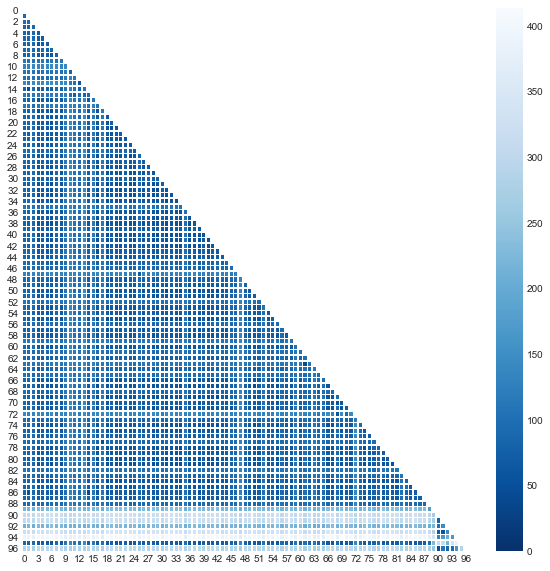


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.0630 secs


+ ------------   64    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

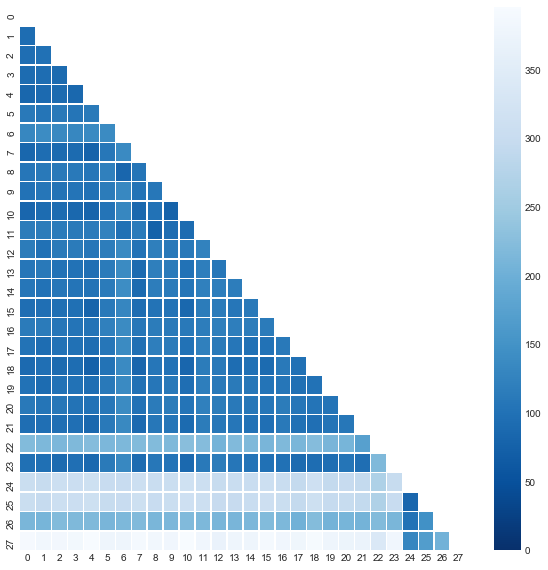


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7680 secs


+ ------------   65    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

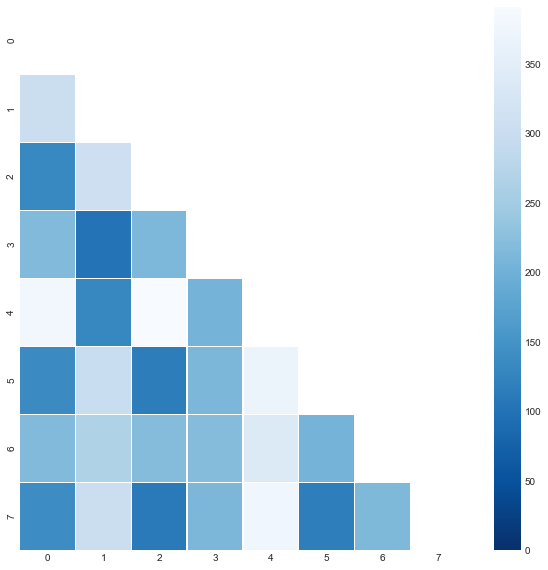


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.7115 secs


+ ------------   66    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

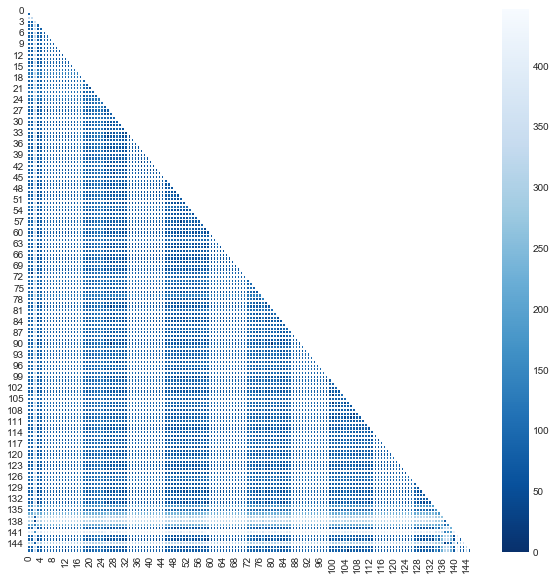


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.6804 secs


+ ------------   67    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

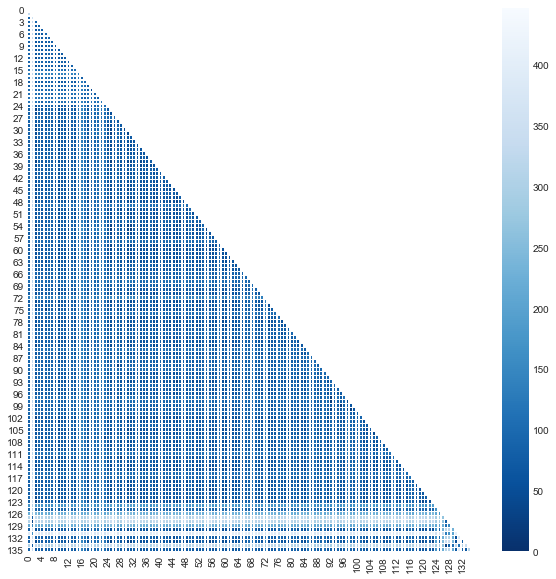


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 2.6691 secs


+ ------------   68    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

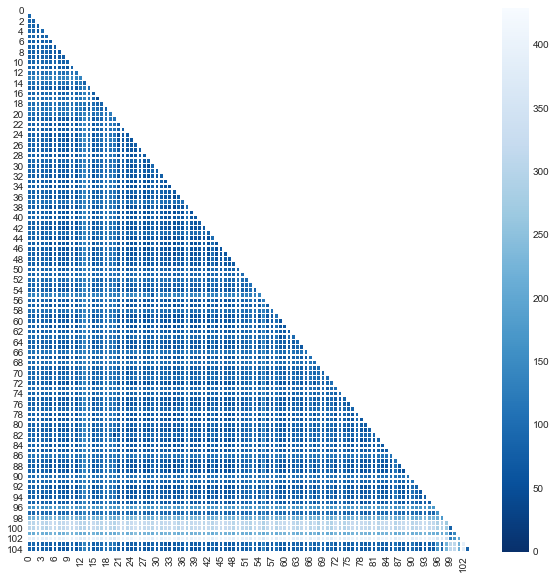


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.3818 secs


+ ------------   69    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

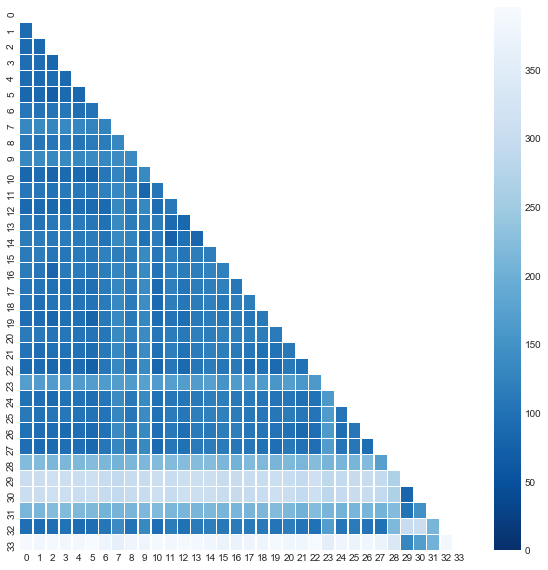


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 1.7068 secs


+ ------------   70    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

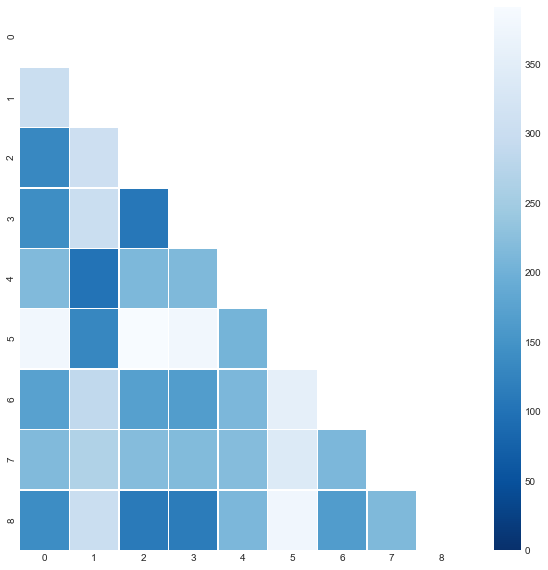


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.8057 secs


+ ------------   71    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

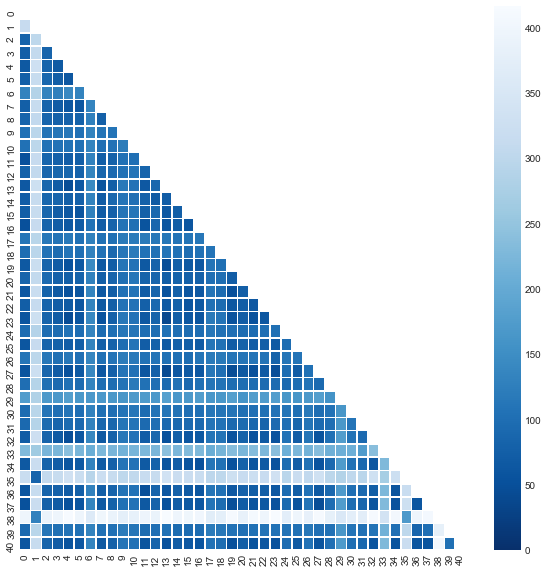


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.9068 secs


+ ------------   72    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

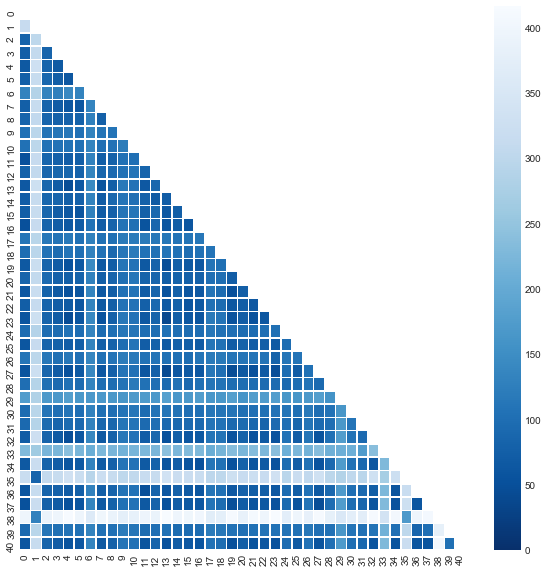


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6513 secs


+ ------------   73    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

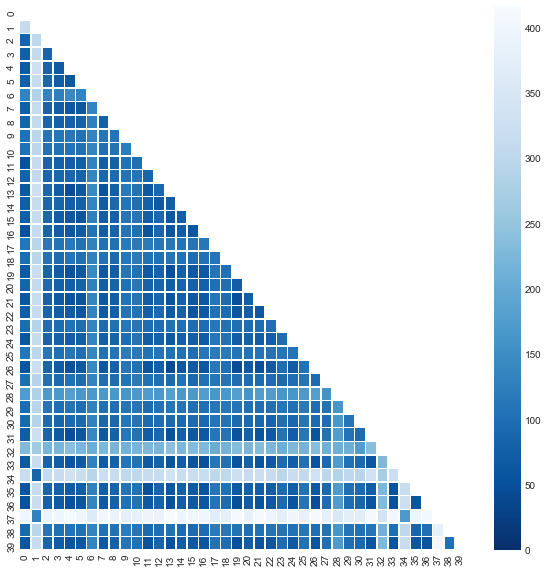


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6598 secs


+ ------------   74    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

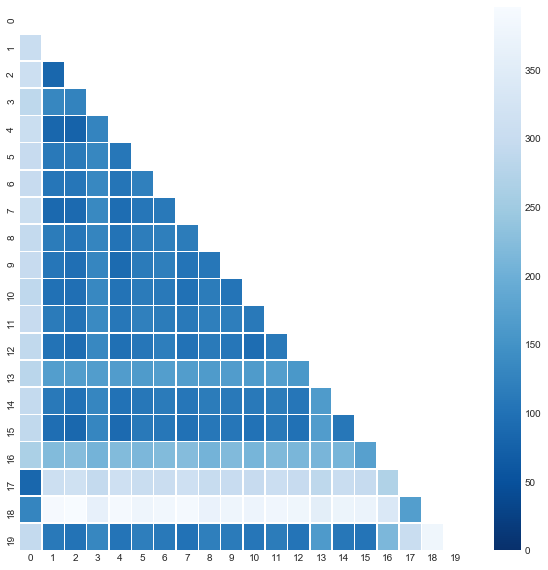


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3801 secs


+ ------------   75    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

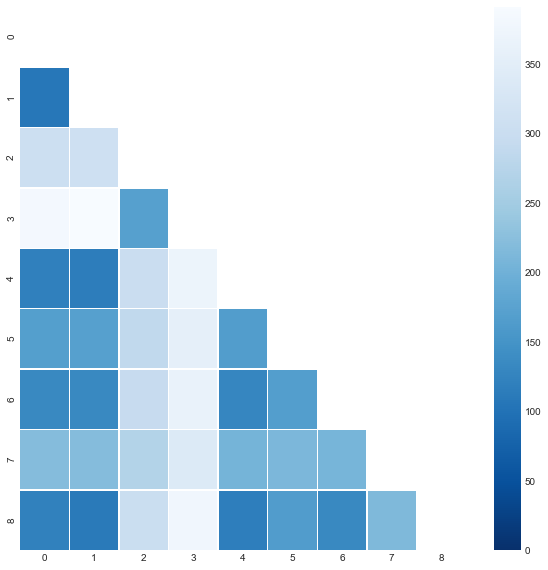


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3136 secs


+ ------------   76    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

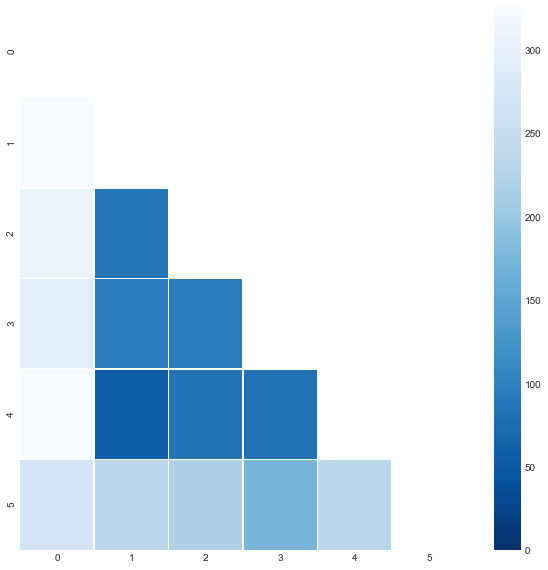


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2939 secs


+ ------------   77    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

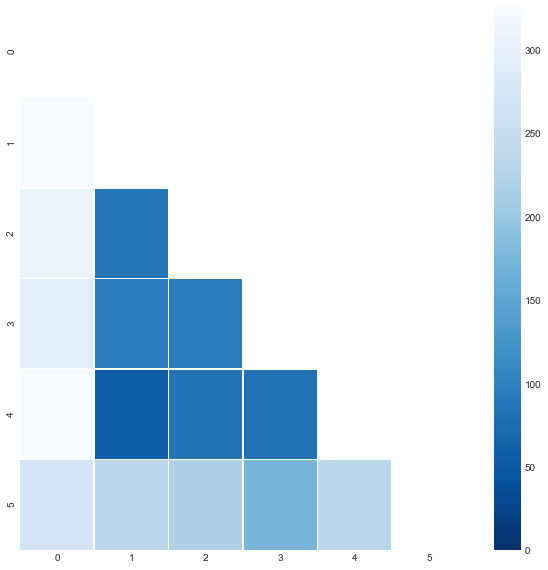


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2740 secs


+ ------------   78    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

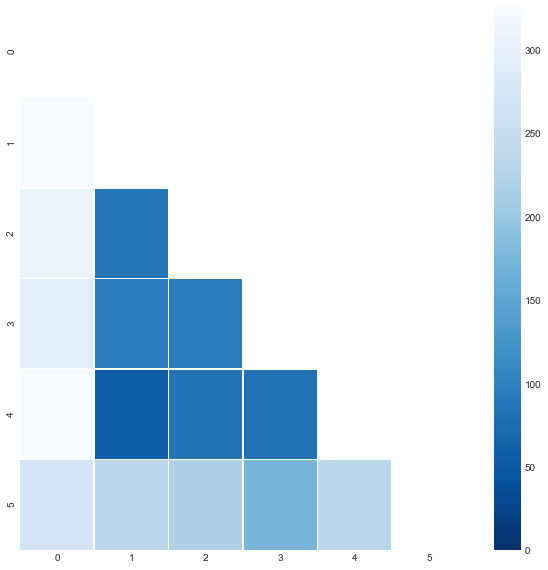


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3549 secs


+ ------------   79    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

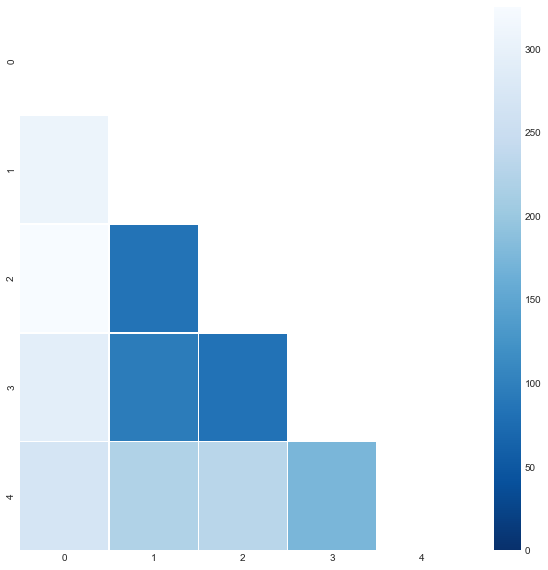


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.3153 secs


+ ------------   80    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


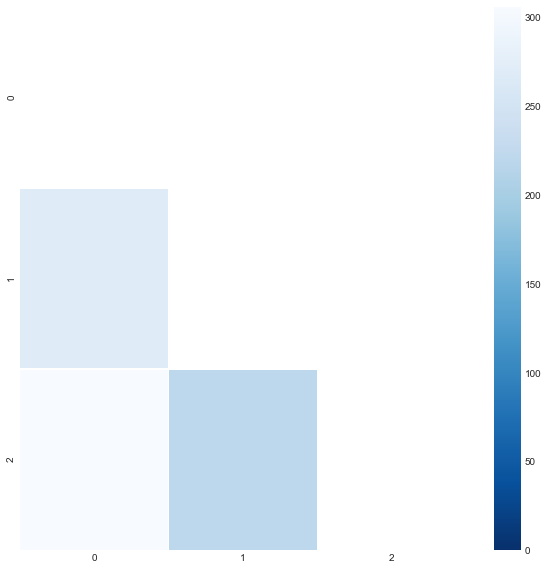


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2838 secs


+ ------------   81    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

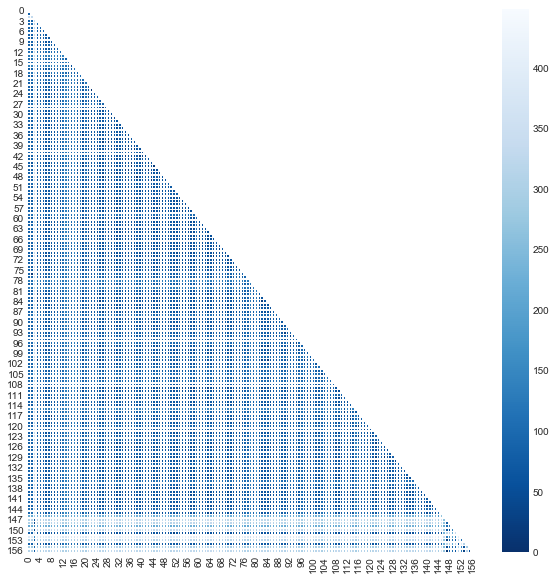


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.3497 secs


+ ------------   82    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

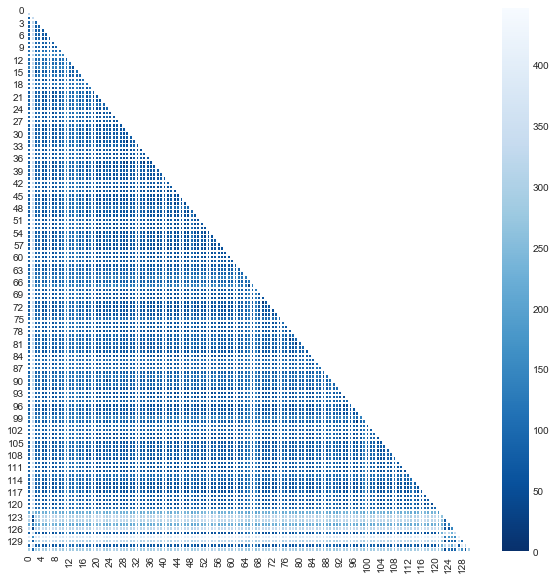


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.0559 secs


+ ------------   83    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

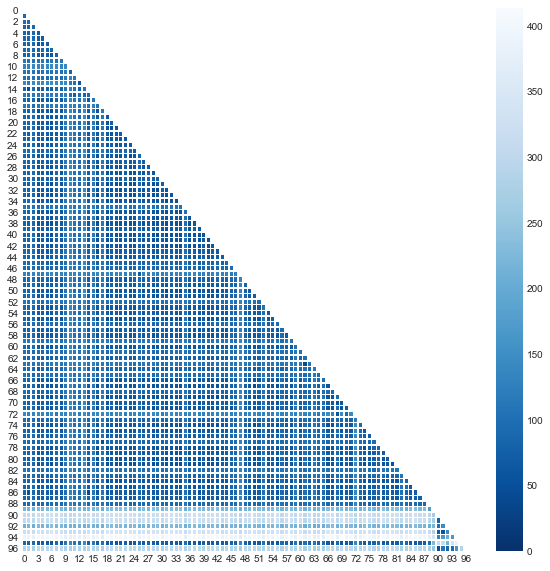


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.2021 secs


+ ------------   84    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

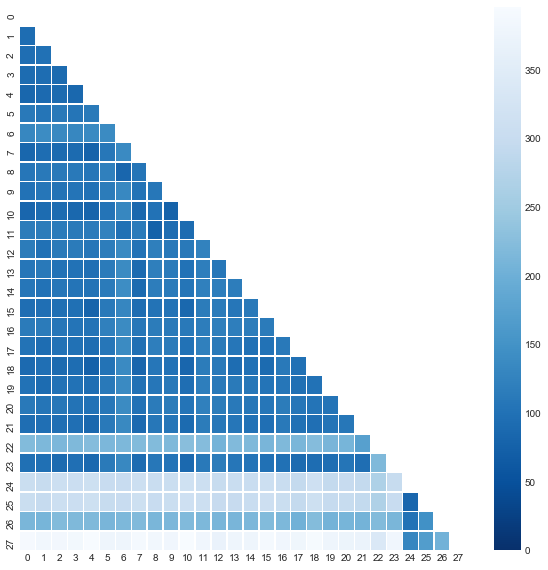


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7937 secs


+ ------------   85    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

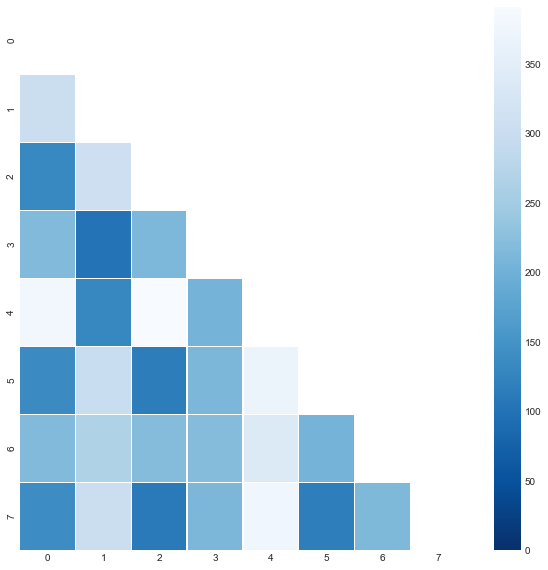


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.5648 secs


+ ------------   86    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

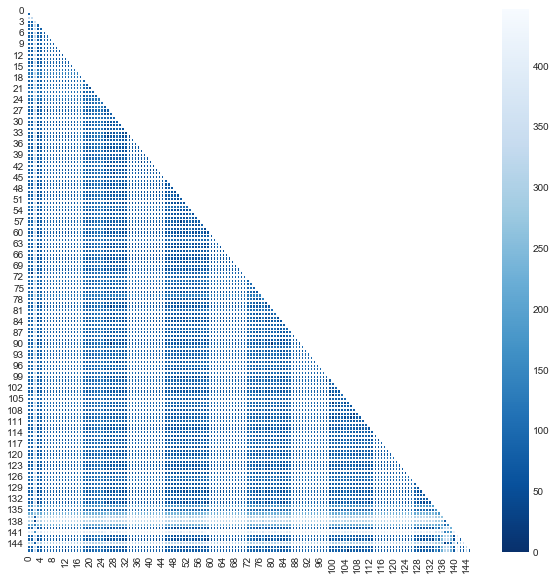


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.0734 secs


+ ------------   87    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

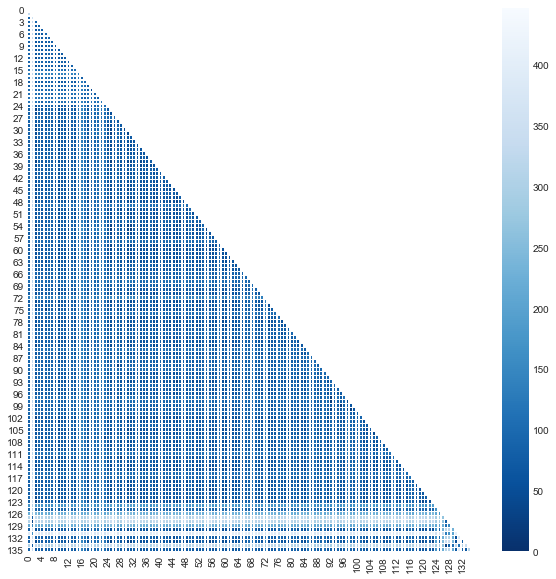


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 0.9877 secs


+ ------------   88    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

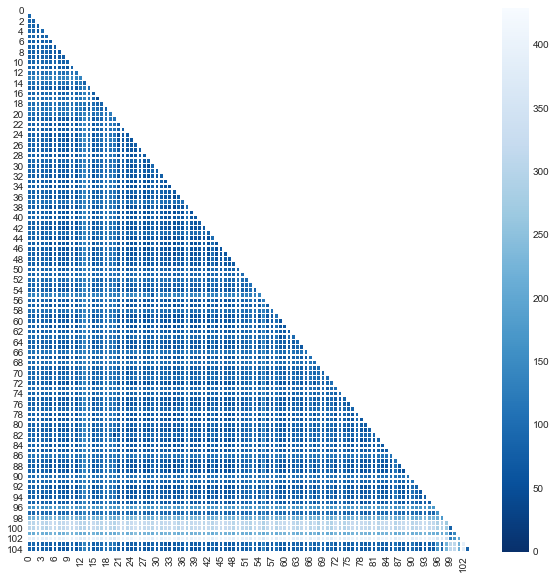


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.2133 secs


+ ------------   89    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

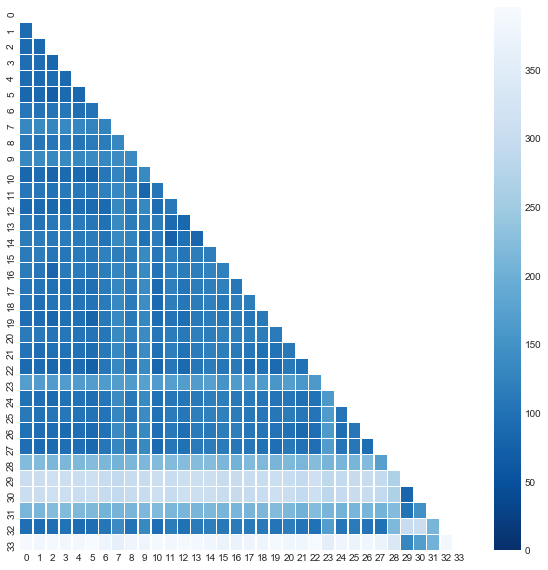


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 0.9140 secs


+ ------------   90    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

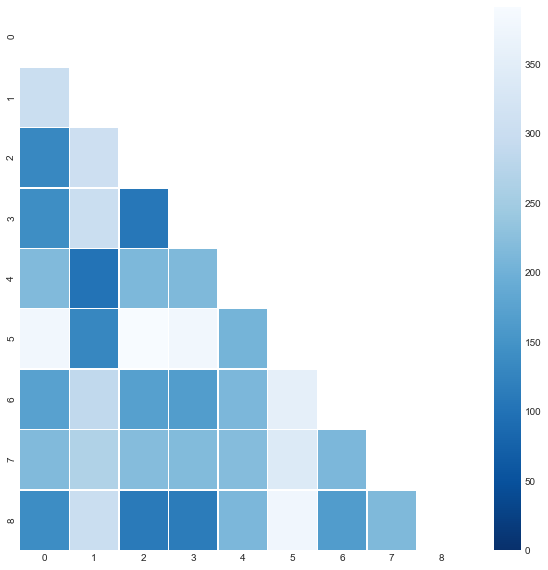


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.7639 secs


+ ------------   91    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

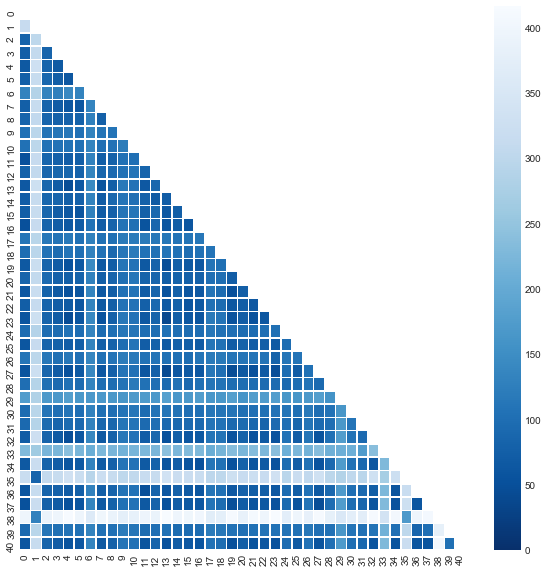


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.9022 secs


+ ------------   92    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

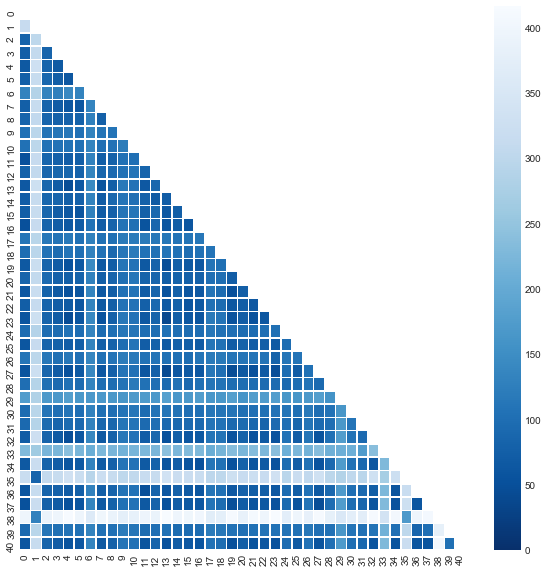


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.8638 secs


+ ------------   93    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

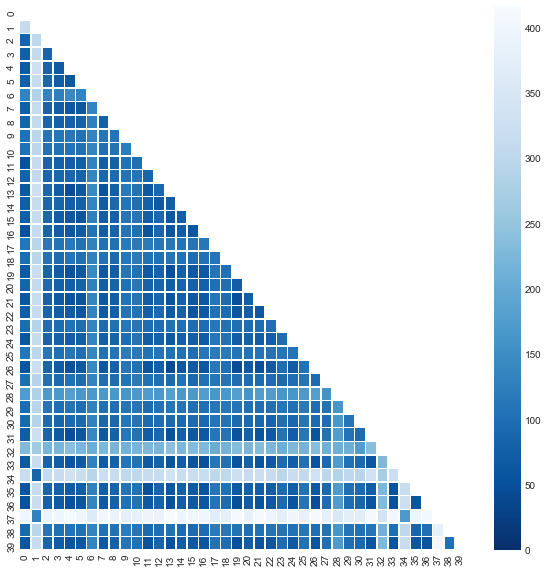


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.7101 secs


+ ------------   94    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

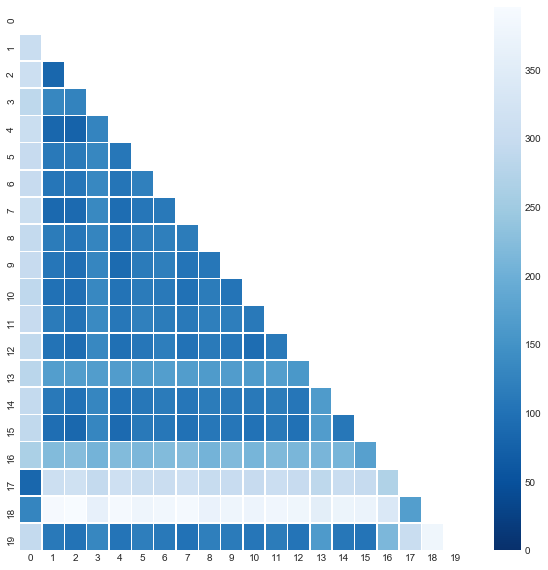


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.4699 secs


+ ------------   95    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

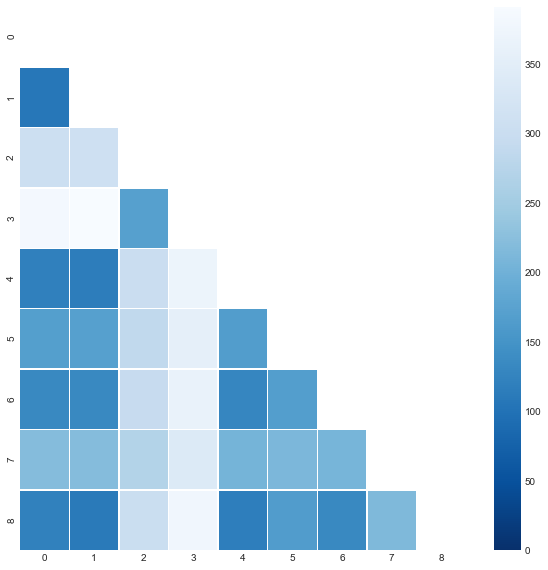


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3231 secs


+ ------------   96    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

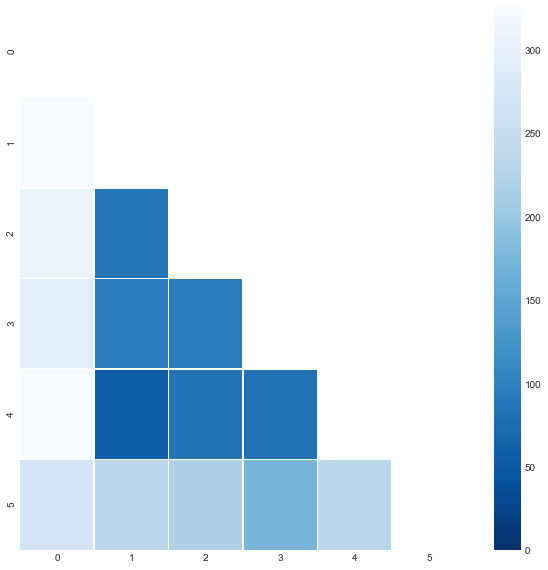


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2958 secs


+ ------------   97    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

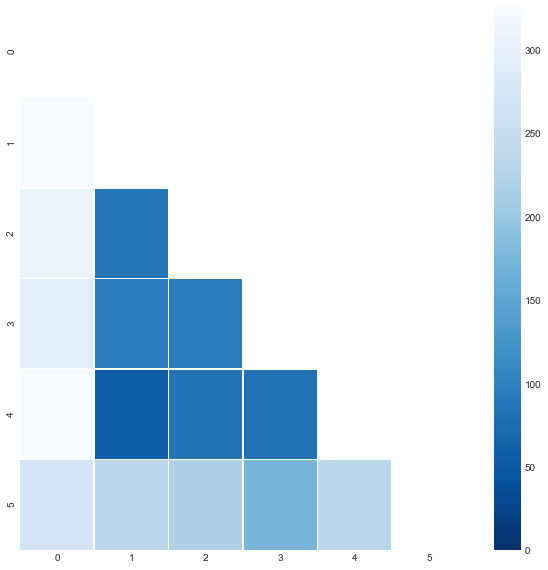


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.4242 secs


+ ------------   98    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

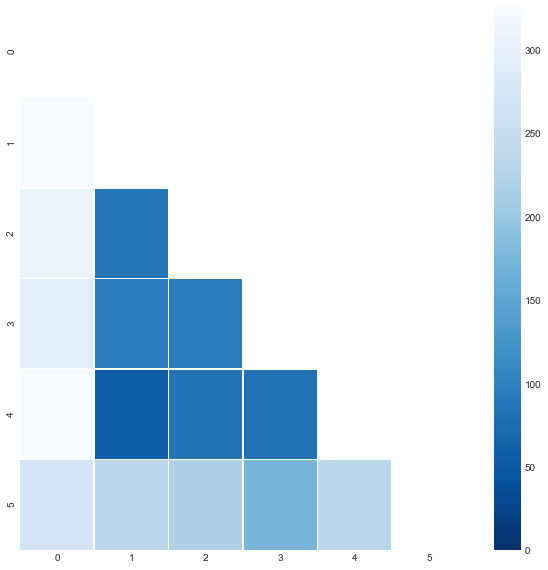


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3237 secs


+ ------------   99    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

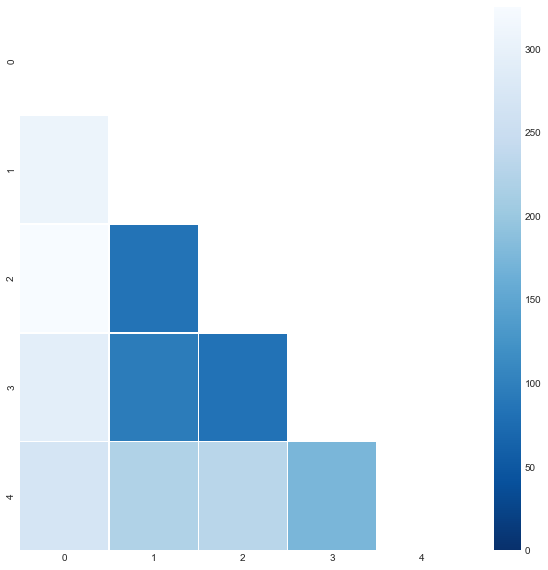


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.4143 secs


+ ------------   100    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


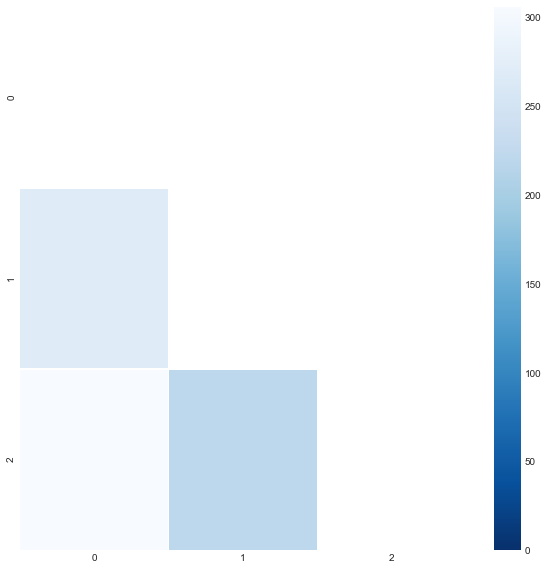


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.3375 secs





In [38]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [50,100,200,300]
prototypesFilterThr = [10,20,40,70,100]

distanceMetric= ['edit']


ngramms= [3]  
jaccard_withchars = [False] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [39]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

max_numberOf_clusters max_editDistance prototypesFilterThr numOfPrototypes  \
61                   500               50                  10             157   
81                  1000               50                  10             157   
86                  1000              100                  10             147   
66                   500              100                  10             147   
67                   500              100                  20             136   
87                  1000              100                  20             136   
62                   500               50                  20             132   
82                  1000               50                  20             132   
88                  1000              100                  40             105   
68                   500              100                  40             105   
63                   500               50                  40              97   
83                  1000               50                  40              97   
46                   100              100                  10              78   
47                   100              100                  20              74   
48                   100              100                  40              64   
41                   100               50                  10              47   
42                   100               50                  20              42   
32                    50              200                  20              41   
91                  1000              200                  10              41   
71                   500              200                  10              41   

   protSelectionVariance  
61               108.366  
81               108.366  
86               103.393  
66               103.393  
67               105.506  
87               105.506  
62               110.963  
82               110.963  
88               105.766  
68               105.766  
63               114.566  
83               114.566  
46                121.17  
47               123.533  
48               118.316  
41                161.23  
42               162.773  
32               130.256  
91               130.256  
71               130.256

In [40]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

max_numberOf_clusters max_editDistance prototypesFilterThr  \
50                    100              100                 100   
70                    500              100                 100   
90                   1000              100                 100   
65                    500               50                 100   
45                    100               50                 100   
85                   1000               50                 100   
55                    100              200                 100   
95                   1000              200                 100   
35                     50              200                 100   
75                    500              200                 100   
44                    100               50                  70   
100                  1000              300                 100   
20                     10              300                 100   
40                     50              300                 100   
80                    500              300                 100   
60                    100              300                 100   
30                     50              100                 100   
94                   1000              200                  70   
54                    100              200                  70   
34                     50              200                  70   
74                    500              200                  70   
49                    100              100                  70   
19                     10              300                  70   
59                    100              300                  70   
39                     50              300                  70   
99                   1000              300                  70   
79                    500              300                  70   
42                    100               50                  20   
41                    100               50                  10   
38                     50              300                  40   
56                    100              300                  10   
96                   1000              300                  10   
18                     10              300                  40   
97                   1000              300                  20   
57                    100              300                  20   
36                     50              300                  10   
37                     50              300                  20   
58                    100              300                  40   
76                    500              300                  10   
77                    500              300                  20   
78                    500              300                  40   
16                     10              300                  10   
17                     10              300                  20   
98                   1000              300                  40   
64                    500               50                  70   
84                   1000               50                  70   
43                    100               50                  40   
29                     50              100                  70   
89                   1000              100                  70   
69                    500              100                  70   

    numOfPrototypes protSelectionVariance  
50                9               202.469  
70                9               202.469  
90                9               202.469  
65                8               201.344  
45                8               201.344  
85                8               201.344  
55                9               201.111  
95                9               201.111  
35                9               201.111  
75                9               201.111  
44               18               177.772  
100               3               176.667  
20                3               176.667  
40                3  

In [ ]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [0.3,0.6,0.7,0.8]
prototypesFilterThr = [0.2,0.3,0.4,0.7,0.8]

distanceMetric= ['jaccard']


ngramms= [3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

##### Remarks

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



#### [ii] Fine tunning  __Embedding phase__

At the end, when the model will be fine tunned alltogether

#### [iii] Fine tunning  __WTA algorithm__


Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

#### [iv] Model final fine tunning


##### Edit distance

+ ------------   1    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


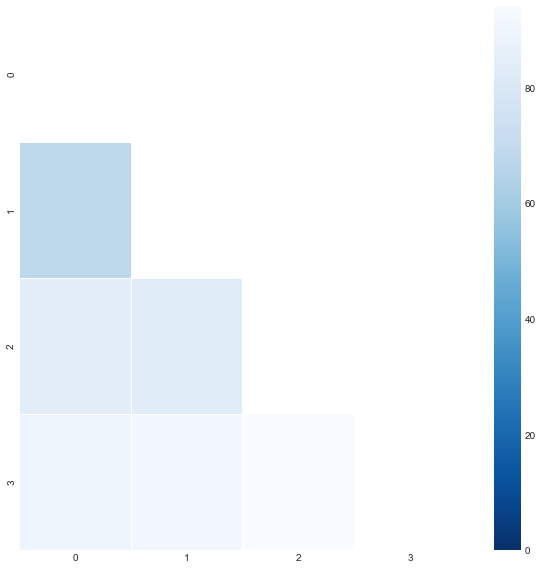


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.5147 secs


+ ------------   2    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


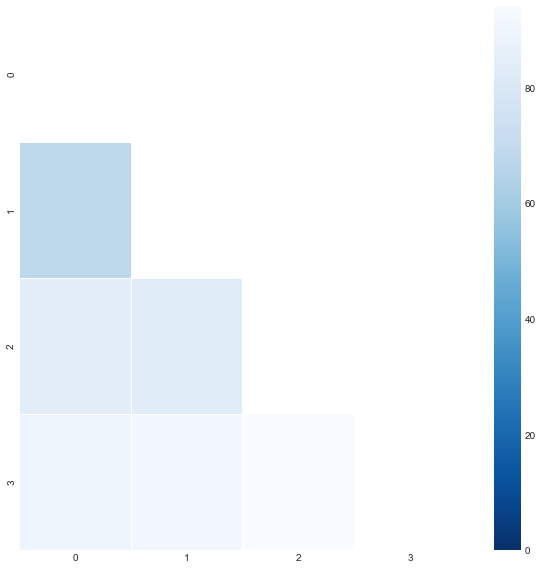


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.6833 secs


+ ------------   3    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
set()
Final:
[17, 21, 3, 13]

- Prototypes selected
[17 21  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


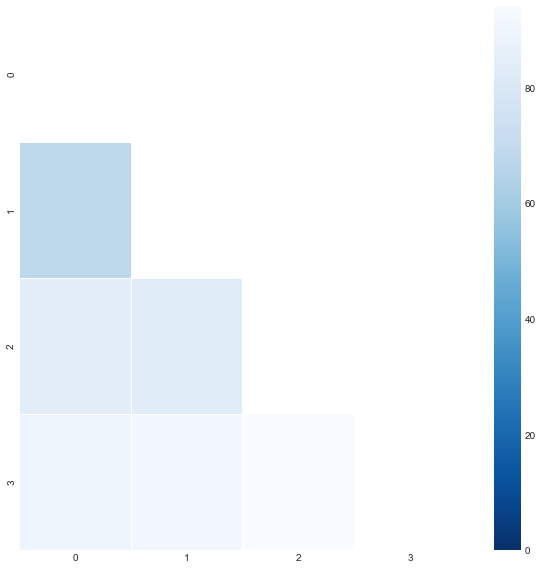


- Mean variance in prototype selection:  63.625

- Final number of prototypes:  4

# Finished in 0.1947 secs


+ ------------   4    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{21}
Final:
[17, 3, 13]

- Prototypes selected
[17  3 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


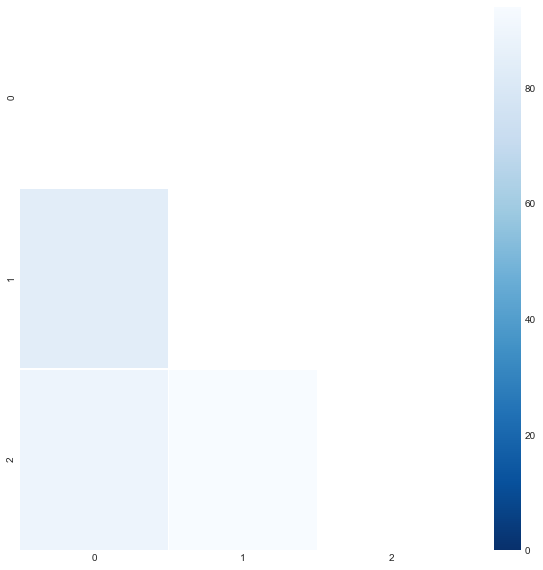


- Mean variance in prototype selection:  59.333333333333336

- Final number of prototypes:  3

# Finished in 0.1970 secs


+ ------------   5    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21]
Not wanted:
{17, 21, 13}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0210 secs


+ ------------   6    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
#############################


50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


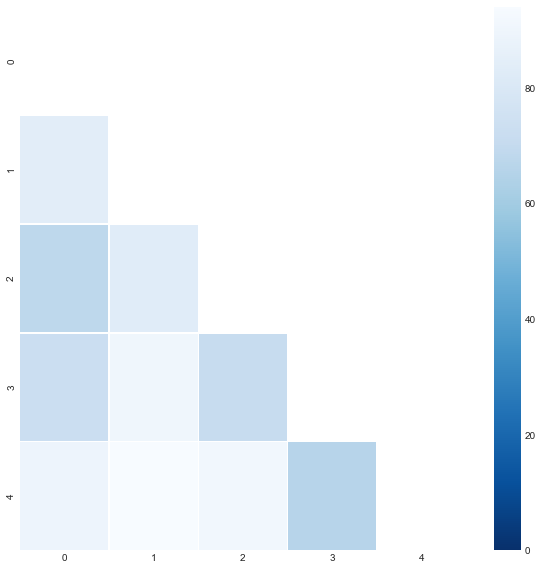


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.2140 secs


+ ------------   7    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


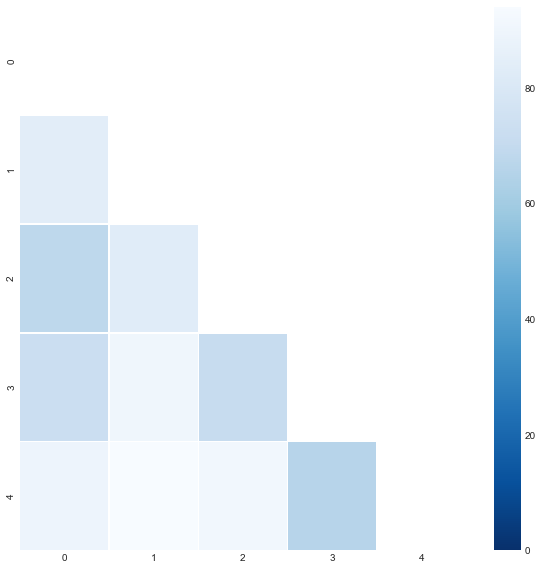


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1912 secs


+ ------------   8    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
set()
Final:
[17, 3, 21, 9, 13]

- Prototypes selected
[17  3 21  9 13]
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
21  ->  b. buth et. al.  provably correct compiler implementation  nan
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan


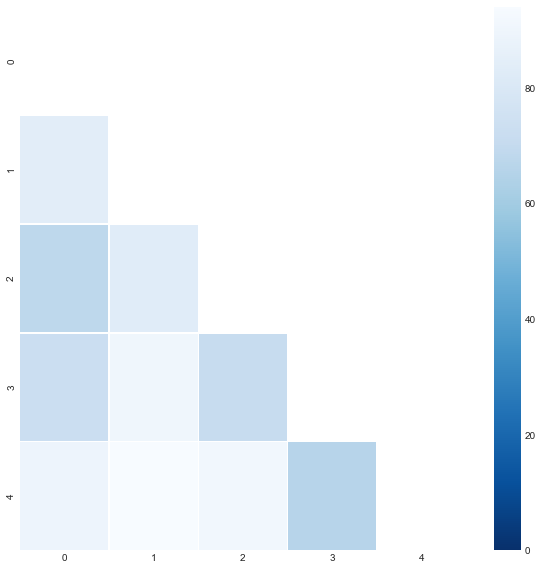


- Mean variance in prototype selection:  64.72

- Final number of prototypes:  5

# Finished in 0.1887 secs


+ ------------   9    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{21, 13}
Final:
[9, 3, 17]

- Prototypes selected
[ 9  3 17]
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan


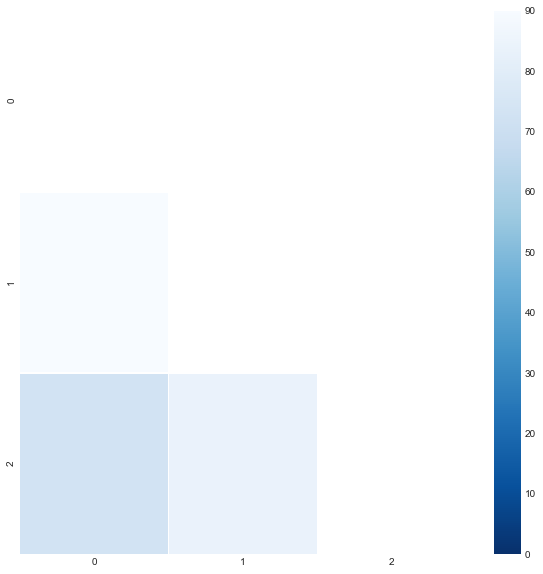


- Mean variance in prototype selection:  54.888888888888886

- Final number of prototypes:  3

# Finished in 0.1891 secs


+ ------------   10    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21]
Not wanted:
{9, 21, 13, 17}
Final:
[3]

- Prototypes selected
[3]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 

- Final number of prototypes:  1

# Finished in 0.0189 secs


+ ------------   11    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
######################


100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

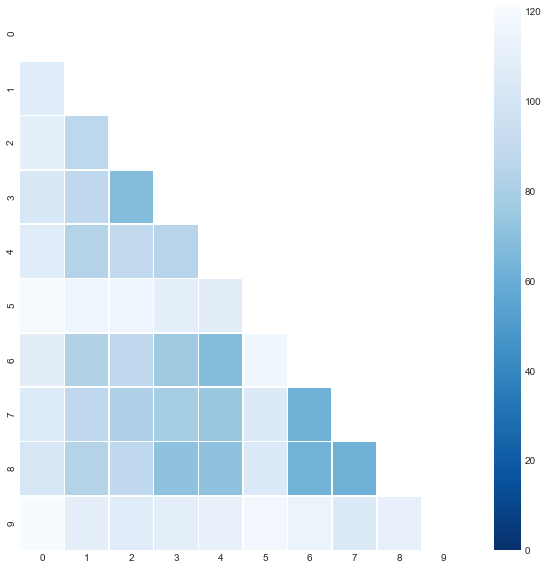


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2408 secs


+ ------------   12    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

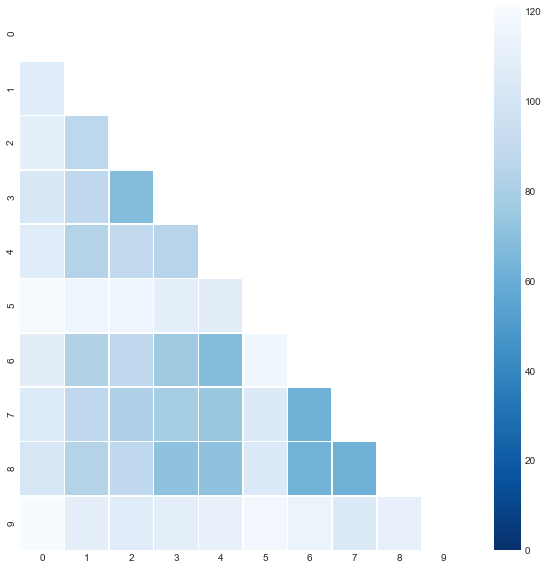


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2330 secs


+ ------------   13    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
set()
Final:
[34, 3, 38, 46, 17, 51, 21, 24, 28, 30]

- Prototypes selected
[34  3 38 46 17 51 21 24 28 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
46  ->  fahle  m. specificity of learning curvature  orientation  and vernier discriminations. vision research 
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
21  ->  b. buth et. al.  provably corr

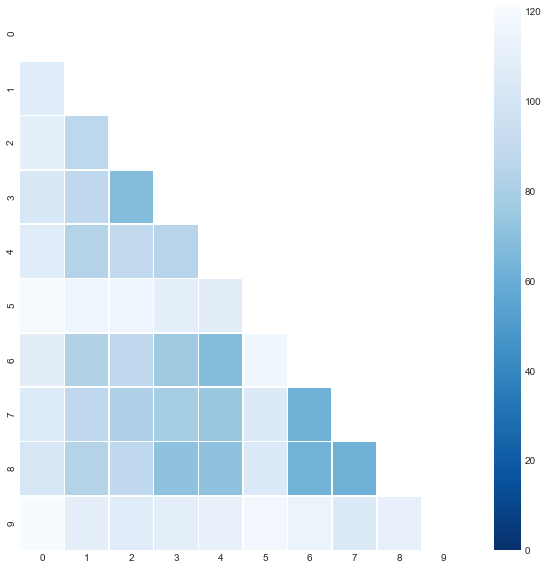


- Mean variance in prototype selection:  85.52

- Final number of prototypes:  10

# Finished in 0.2314 secs


+ ------------   14    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{24, 28, 21, 46}
Final:
[34, 3, 38, 17, 51, 30]

- Prototypes selected
[34  3 38 17 51 30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
38  ->  fahle  m. w. and edelman  s. learning in hyperacuity: influence of stimulus range and of feedback. vision research.
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


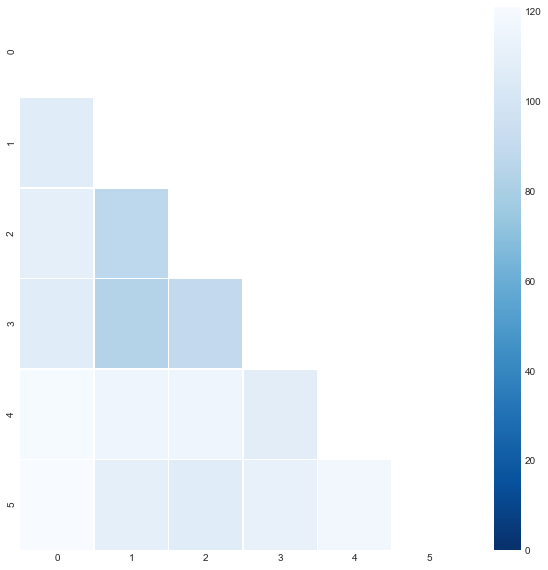


- Mean variance in prototype selection:  89.38888888888889

- Final number of prototypes:  6

# Finished in 0.2120 secs


+ ------------   15    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51]
Not wanted:
{38, 46, 17, 21, 24, 28}
Final:
[51, 34, 3, 30]

- Prototypes selected
[51 34  3 30]
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical society b 


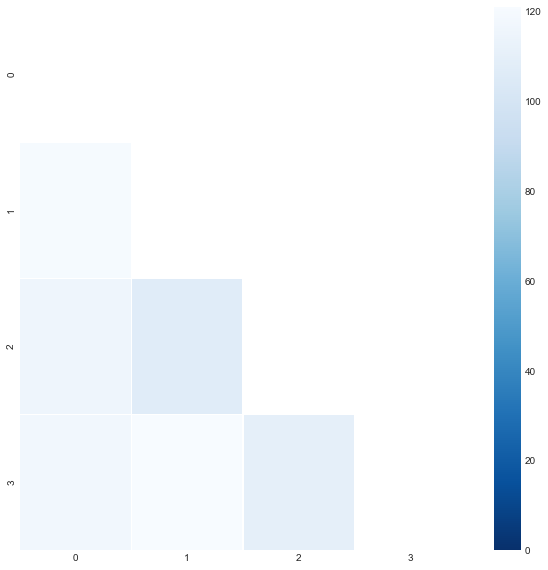


- Mean variance in prototype selection:  86.25

- Final number of prototypes:  4

# Finished in 0.2762 secs


+ ------------   16    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

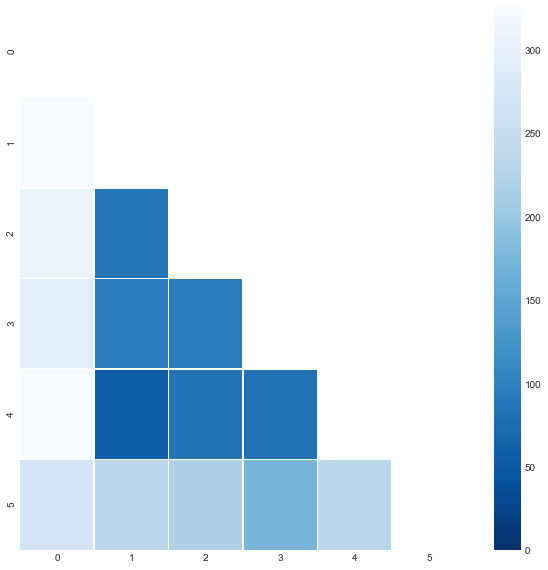


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2551 secs


+ ------------   17    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

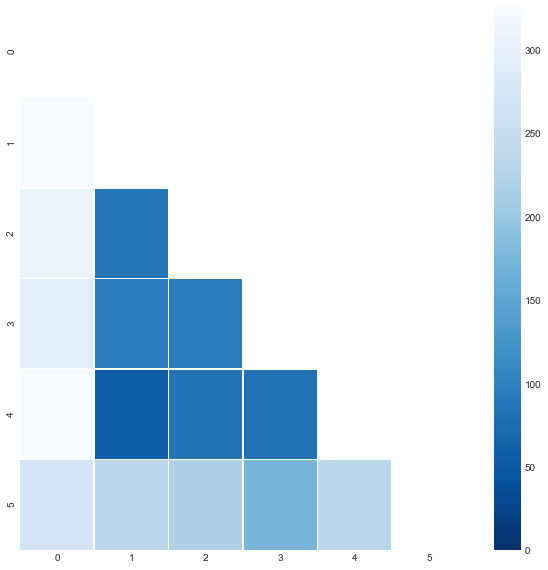


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2778 secs


+ ------------   18    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

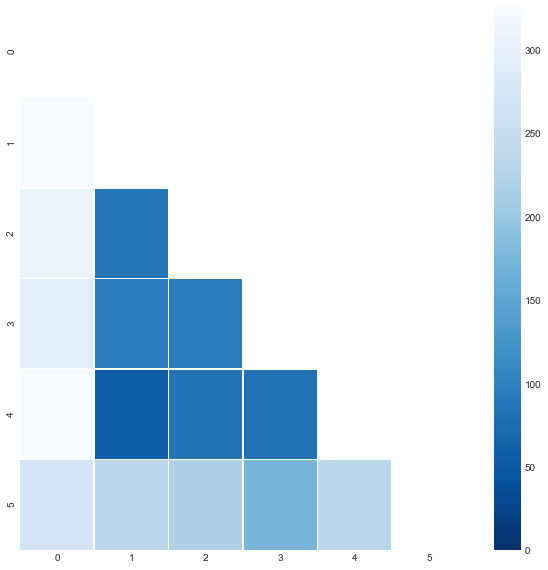


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2579 secs


+ ------------   19    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

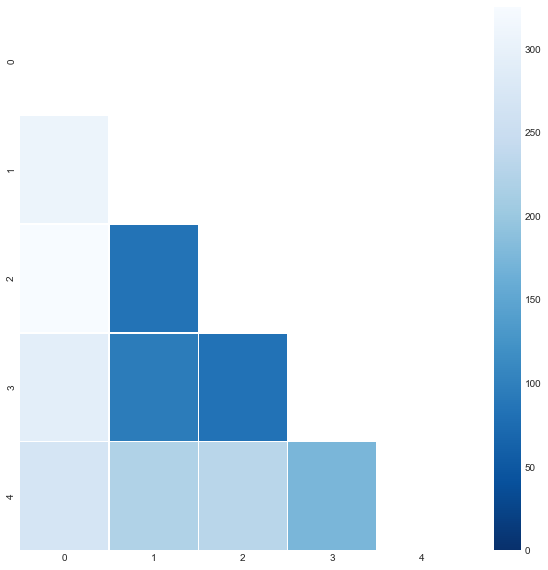


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2586 secs


+ ------------   20    ------------- +
max_numberOf_clusters:  10
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


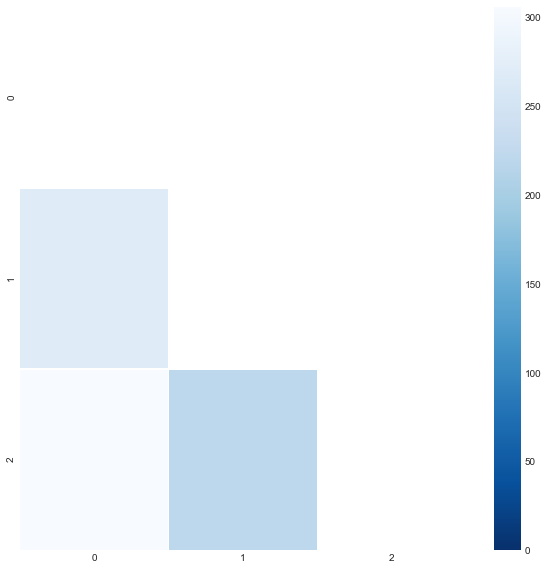


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2408 secs


+ ------------   21    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 136, 110, 244, 309, 250, 284, 190}
Final:
[384, 3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 41, 44, 47, 178, 51, 59, 65, 203, 97, 100, 105, 107]

- Prototypes selected
[384   3  13  17  21 405 152  28  30 415  32  34 419  39  41  44  47 178
  51  59  65 203  97 100 105 107]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  

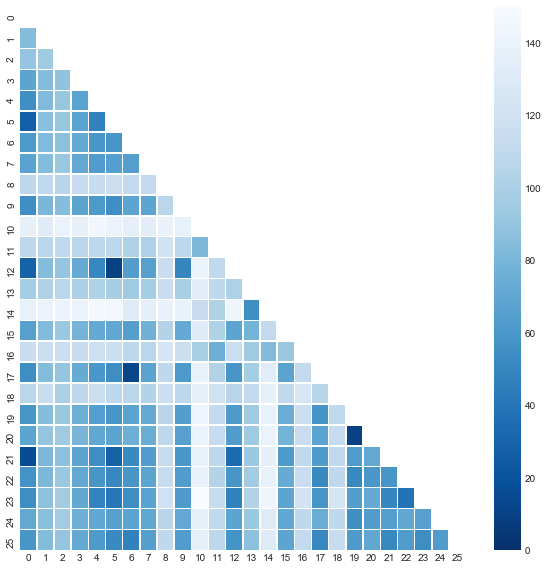


- Mean variance in prototype selection:  86.1508875739645

- Final number of prototypes:  26

# Finished in 0.4247 secs


+ ------------   22    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 136, 110, 178, 244, 309, 250, 284, 190}
Final:
[3, 13, 17, 21, 405, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 100, 105, 107]

- Prototypes selected
[  3  13  17  21 405 152  28  30 415  32  34  39  41  44  47  51  59 203
  97 100 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
405  ->  s. fahlman. the recurrent cascade-correlation architecture. nan
152  ->  fahlman  s. e. an e

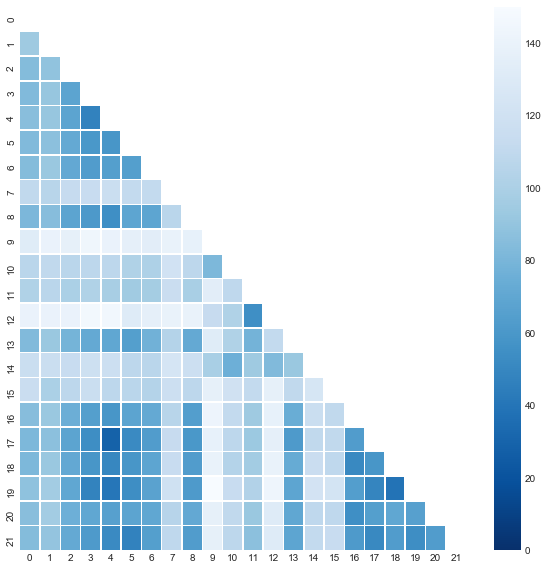


- Mean variance in prototype selection:  89.98347107438016

- Final number of prototypes:  22

# Finished in 0.3956 secs


+ ------------   23    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{160, 65, 384, 419, 100, 136, 110, 178, 244, 309, 405, 250, 284, 190}
Final:
[3, 13, 17, 21, 152, 28, 30, 415, 32, 34, 39, 41, 44, 47, 51, 59, 203, 97, 105, 107]

- Prototypes selected
[  3  13  17  21 152  28  30 415  32  34  39  41  44  47  51  59 203  97
 105 107]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. actress: an action semantics directed compiler generator. nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
152  ->  fahlman  s. e. an empirical study of learning speed in backpropagation networks. nan
28  ->  nan an 

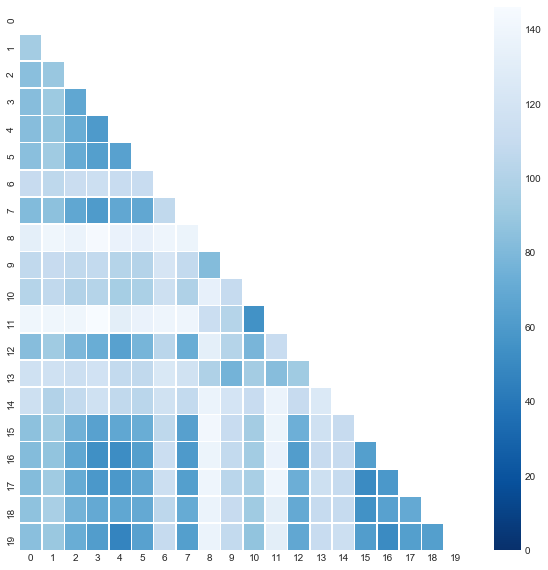


- Mean variance in prototype selection:  92.03

- Final number of prototypes:  20

# Finished in 0.3222 secs


+ ------------   24    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 21, 405, 152, 28, 284, 415, 160, 419, 41, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 34, 3, 39, 44, 13, 47, 17, 51, 30]

- Prototypes selected
[32 34  3 39 44 13 47 17 51 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
39  ->  m fahle and s edelman. long-term learning in vernier acuity: effects of stimulus orientation  range and of feedback. vision resear

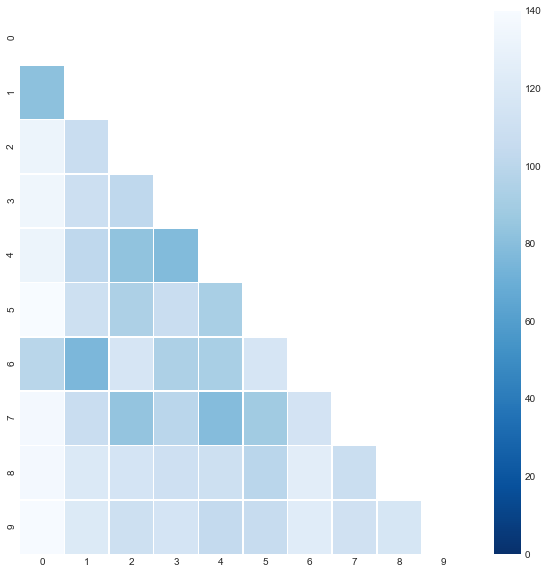


- Mean variance in prototype selection:  97.62

- Final number of prototypes:  10

# Finished in 0.3092 secs


+ ------------   25    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419]
Not wanted:
{384, 136, 13, 17, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 41, 44, 47, 178, 309, 59, 190, 65, 203, 97, 100, 105, 107, 110, 244, 250}
Final:
[32, 51, 3, 30]

- Prototypes selected
[32 51  3 30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
51  ->  lennart e. fahlen  charles grant brown  olov stahl  and christer carlsson. a space based model for user interaction in shared synthetic environments. nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
30  ->  dempster  a.  laird  n.  and rubin  d. maximum likelihood from incomplete data via the em algorithm. journal of the royal statistical soc

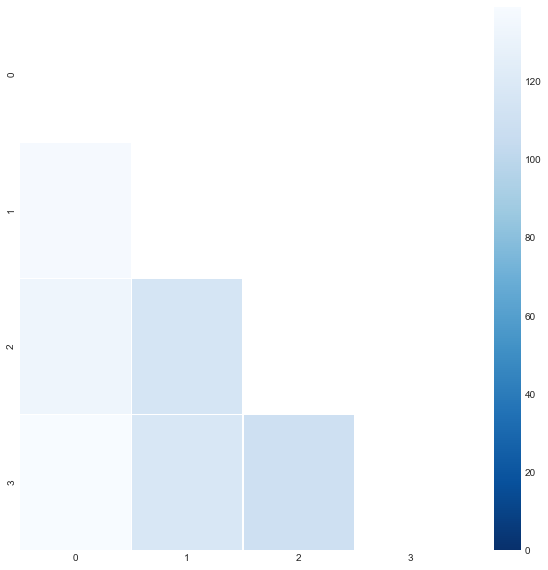


- Mean variance in prototype selection:  93.75

- Final number of prototypes:  4

# Finished in 0.2095 secs


+ ------------   26    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

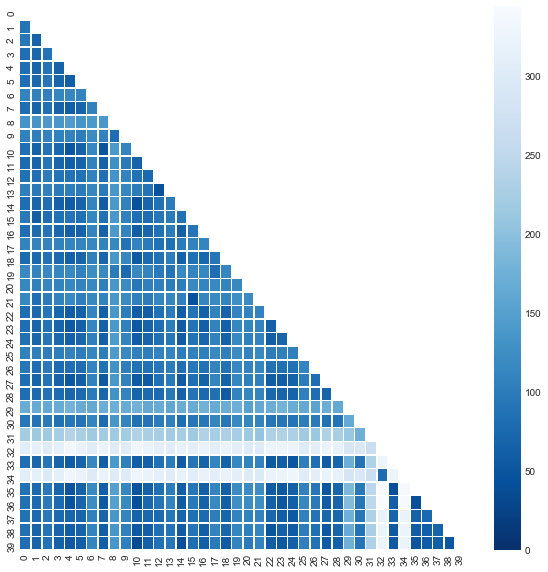


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.6150 secs


+ ------------   27    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
set()
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 418, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 100, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34 418  36  38  40 424 426 428  45
 430  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 100
 102 105 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d.

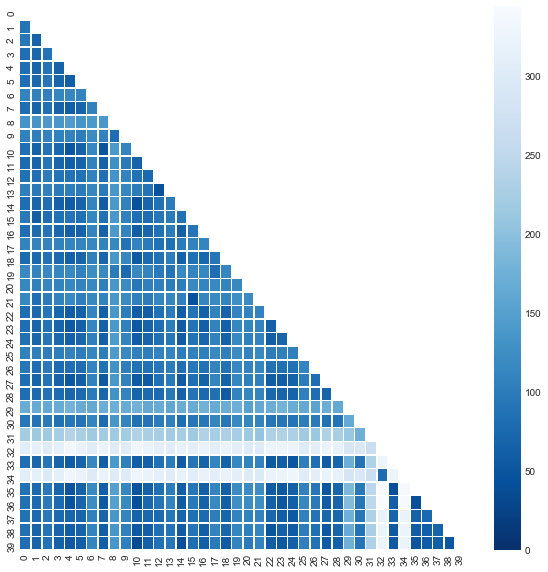


- Mean variance in prototype selection:  118.82125

- Final number of prototypes:  40

# Finished in 0.6189 secs


+ ------------   28    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{418, 100}
Final:
[3, 9, 13, 17, 21, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 451, 453, 456, 462, 467, 472, 477, 480, 97, 482, 102, 105, 117, 253]

- Prototypes selected
[  3   9  13  17  21  28  30 415  32  34  36  38  40 424 426 428  45 430
  47 432  51 180 442  60 451 453 456 462 467 472 477 480  97 482 102 105
 117 253]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
9  ->  steve benford and lennart e. fahlen. a spatial model of interaction in large virtual environments. nan
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
17  ->  d. f. brown  h. moura  and d. a. watt. act

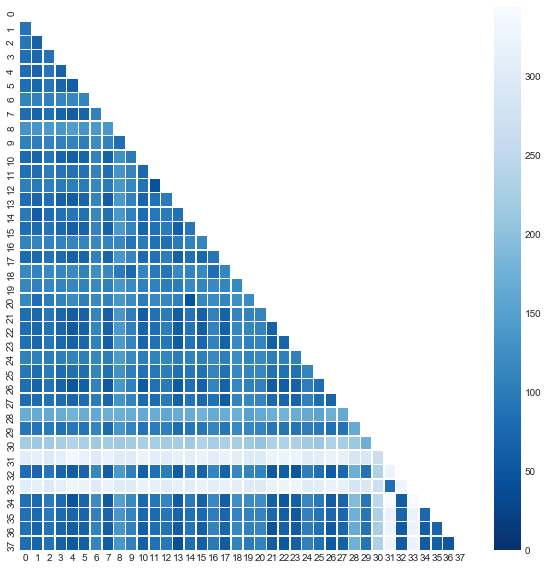


- Mean variance in prototype selection:  121.15789473684211

- Final number of prototypes:  38

# Finished in 0.5924 secs


+ ------------   29    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{13, 21, 28, 415, 418, 36, 424, 40, 426, 428, 430, 180, 442, 60, 456, 462, 97, 100, 102, 105, 117, 253}
Final:
[32, 480, 34, 3, 451, 453, 38, 482, 9, 45, 47, 432, 17, 51, 467, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453  38 482   9  45  47 432  17  51 467 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the

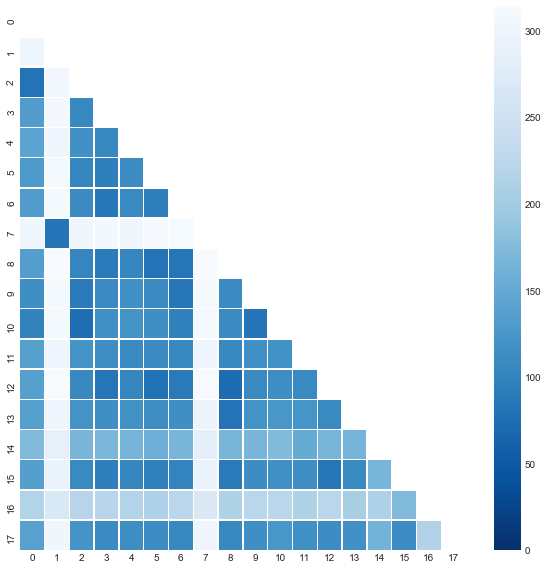


- Mean variance in prototype selection:  155.25925925925927

- Final number of prototypes:  18

# Finished in 0.3059 secs


+ ------------   30    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482]
Not wanted:
{9, 13, 17, 21, 28, 415, 418, 34, 36, 38, 424, 40, 426, 428, 45, 430, 47, 432, 51, 180, 442, 60, 453, 456, 462, 472, 97, 482, 100, 102, 105, 117, 253}
Final:
[32, 480, 3, 451, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de weldel  w. wenzel  j. wnek  and j. zhang. the monk's problems: a performance comparison o

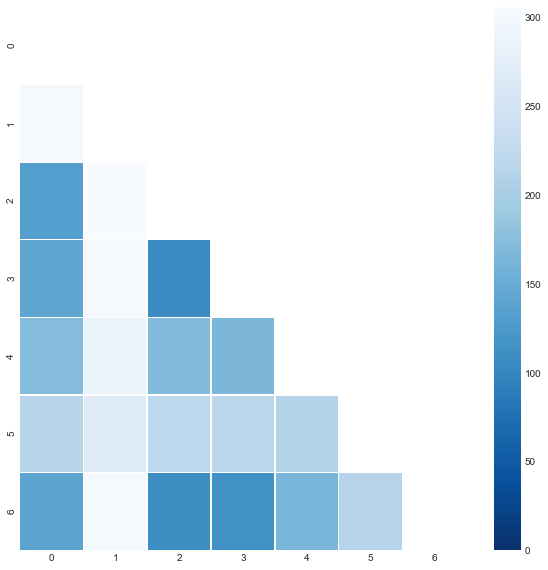


- Mean variance in prototype selection:  173.87755102040816

- Final number of prototypes:  7

# Finished in 0.2306 secs


+ ------------   31    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

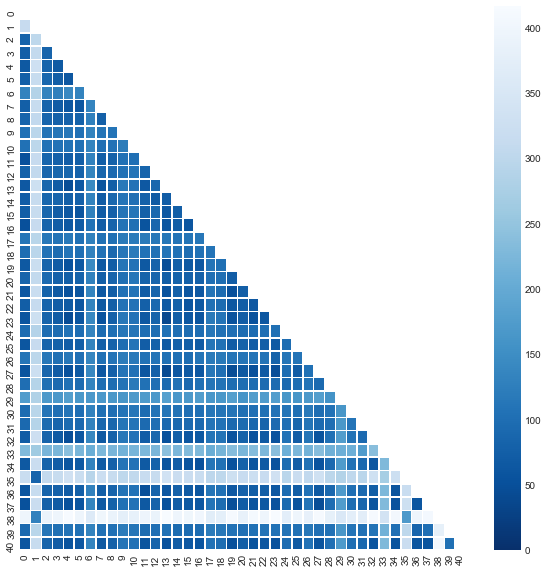


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7438 secs


+ ------------   32    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

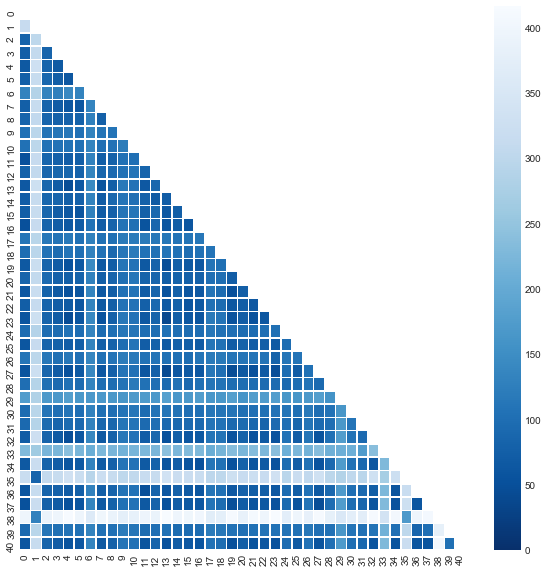


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7079 secs


+ ------------   33    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

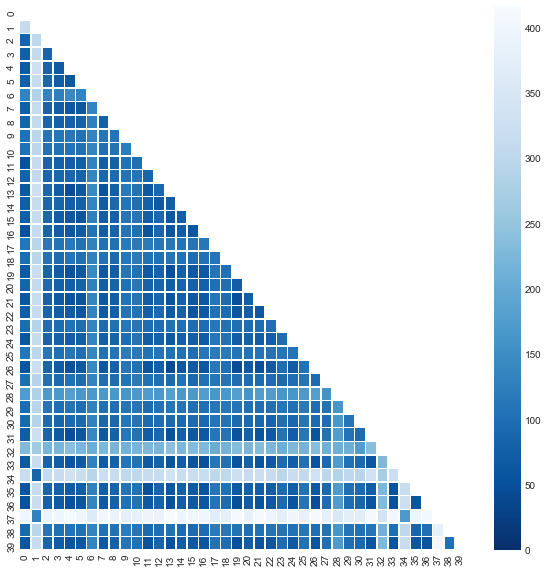


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6878 secs


+ ------------   34    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

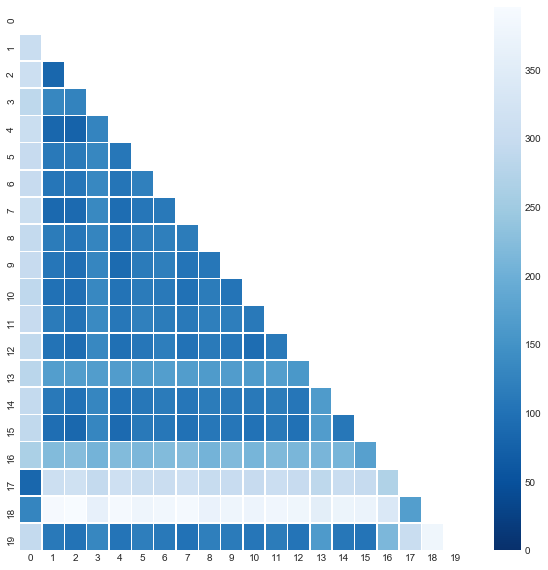


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.4122 secs


+ ------------   35    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

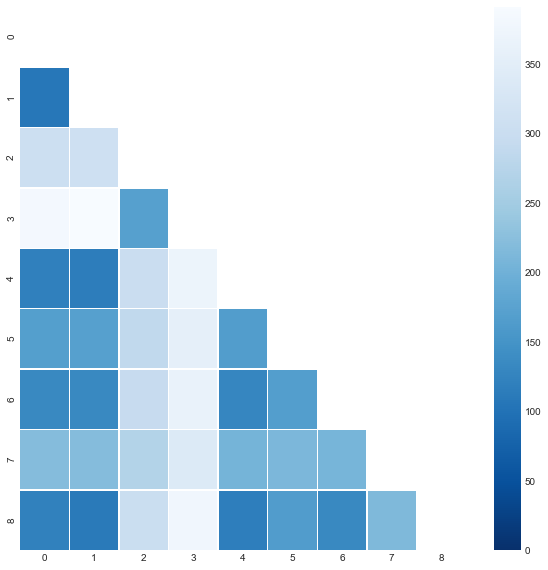


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3449 secs


+ ------------   36    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

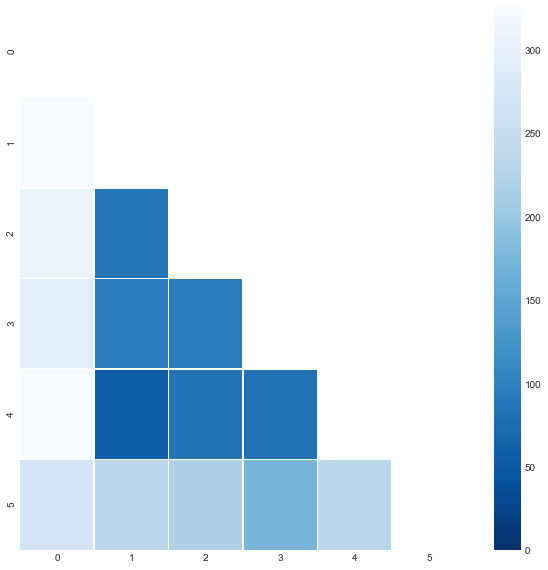


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3009 secs


+ ------------   37    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

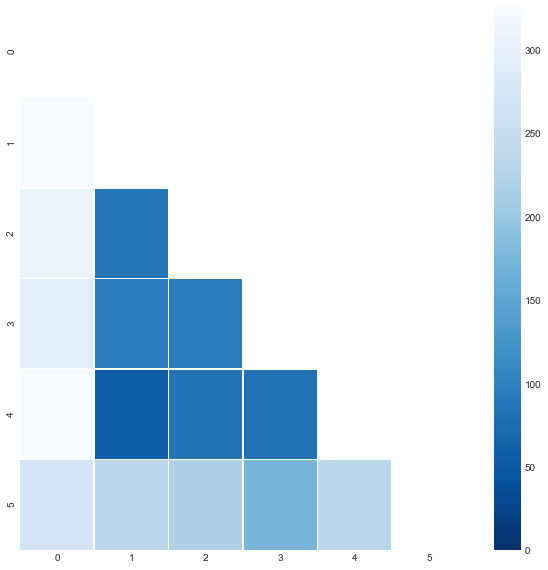


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3569 secs


+ ------------   38    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

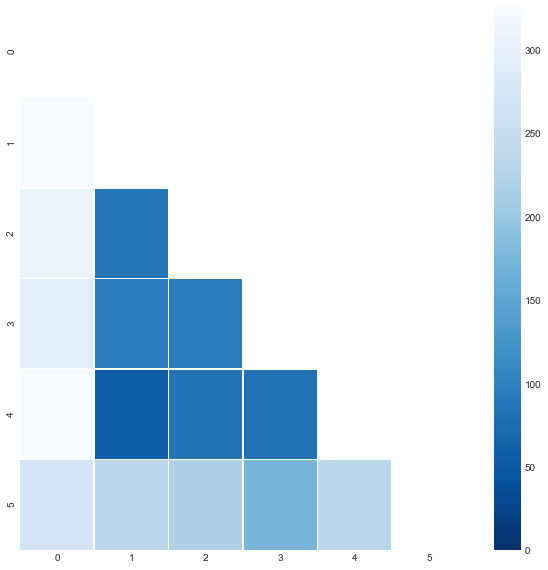


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2828 secs


+ ------------   39    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

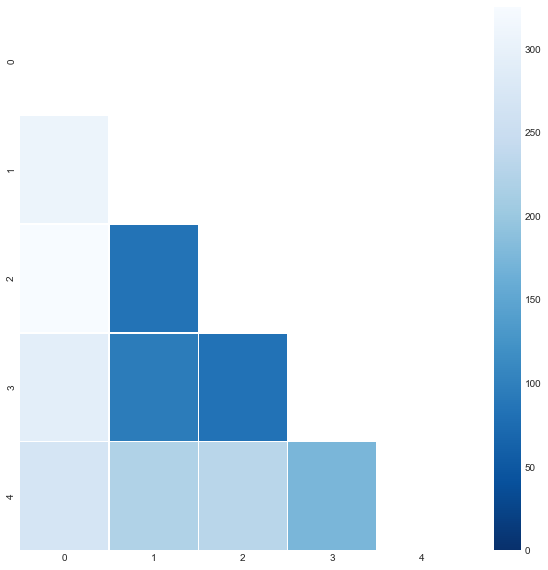


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2562 secs


+ ------------   40    ------------- +
max_numberOf_clusters:  50
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


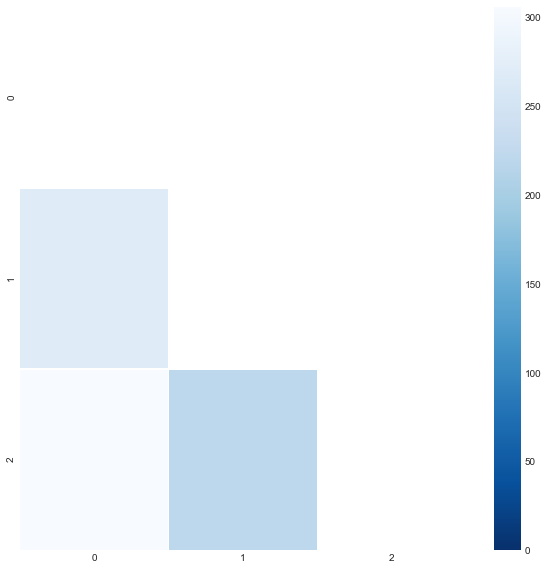


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2481 secs


+ ------------   41    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 515, 136, 488, 492, 110, 244, 309, 250, 284, 190, 511}
Final:
[384, 3, 518, 13, 525, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 419, 39, 424, 41, 426, 44, 47, 178, 51, 562, 442, 59, 65, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504, 507]

- Prototypes selected
[384   3 518  13 525  17 531  21 405 152  28  30 415  32  34 419  39 424
  41 426  44  47 178  51 562 442  59  65 451 453 456 203 462 472 477 480
  97 482 100 484 486 105 107 496 501 504 507]
384  ->  s.e. fahlman and c. lebiere  the cascade-correlation learning architecture  nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. ander

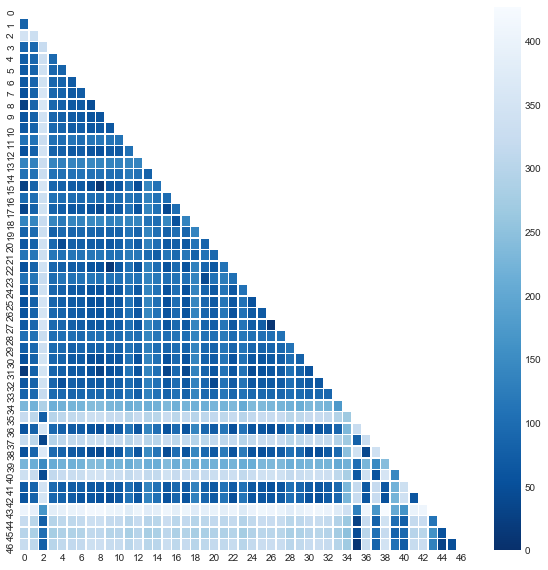


- Mean variance in prototype selection:  161.22951561792667

- Final number of prototypes:  47

# Finished in 0.6003 secs


+ ------------   42    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{160, 65, 384, 419, 515, 136, 488, 492, 110, 178, 244, 309, 250, 507, 284, 190, 511}
Final:
[3, 518, 525, 13, 17, 531, 21, 405, 152, 28, 30, 415, 32, 34, 39, 424, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 100, 484, 486, 105, 107, 496, 501, 504]

- Prototypes selected
[  3 518 525  13  17 531  21 405 152  28  30 415  32  34  39 424  41 426
  44  47 562  51 442  59 451 453 456 203 462 472 477 480  97 482 100 484
 486 105 107 496 501 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
518  ->  thurn  s. b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  d

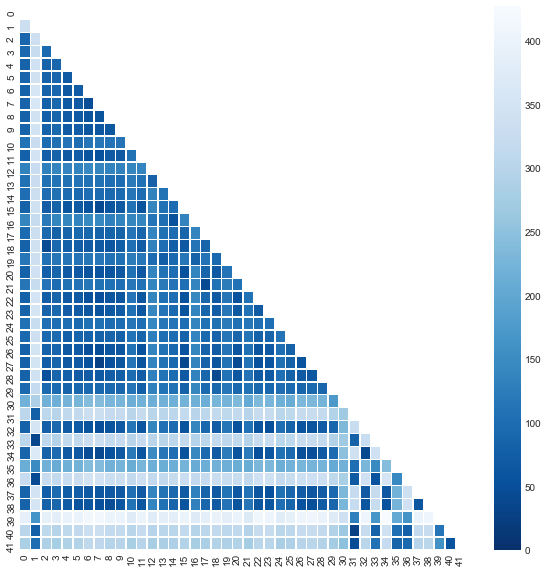


- Mean variance in prototype selection:  162.77324263038548

- Final number of prototypes:  42

# Finished in 0.6472 secs


+ ------------   43    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 405, 284, 160, 419, 424, 178, 309, 190, 65, 100, 488, 492, 110, 244, 501, 250, 507, 511}
Final:
[3, 525, 13, 17, 531, 21, 152, 28, 30, 415, 32, 34, 39, 41, 426, 44, 47, 562, 51, 442, 59, 451, 453, 456, 203, 462, 472, 477, 480, 97, 482, 484, 486, 105, 107, 496, 504]

- Prototypes selected
[  3 525  13  17 531  21 152  28  30 415  32  34  39  41 426  44  47 562
  51 442  59 451 453 456 203 462 472 477 480  97 482 484 486 105 107 496
 504]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
525  ->  weiss  y.  edelman  s.  and fahle  m. models of perceptual learning in vernier hyperacuity. neu

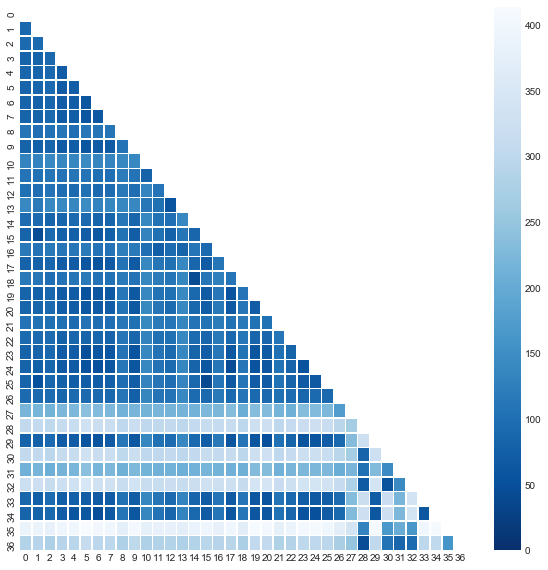


- Mean variance in prototype selection:  155.40102264426588

- Final number of prototypes:  37

# Finished in 0.6171 secs


+ ------------   44    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 525, 531, 21, 405, 152, 28, 284, 415, 160, 419, 424, 41, 426, 178, 562, 309, 442, 59, 190, 65, 456, 203, 462, 97, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 34, 3, 451, 453, 482, 39, 484, 44, 13, 47, 496, 17, 51, 472, 477, 30]

- Prototypes selected
[ 32 480  34   3 451 453 482  39 484  44  13  47 496  17  51 472 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman

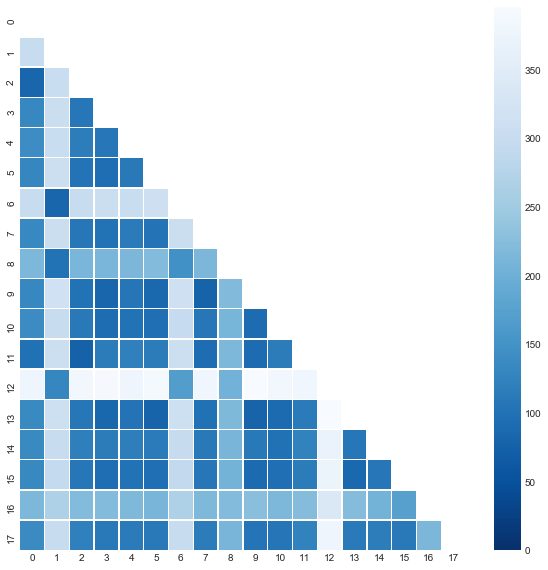


- Mean variance in prototype selection:  177.7716049382716

- Final number of prototypes:  18

# Finished in 0.3469 secs


+ ------------   45    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562]
Not wanted:
{384, 515, 518, 136, 13, 525, 17, 531, 21, 405, 152, 28, 284, 415, 160, 34, 419, 39, 424, 41, 426, 44, 47, 178, 562, 309, 442, 59, 190, 65, 451, 453, 456, 203, 462, 472, 97, 482, 100, 486, 488, 105, 107, 492, 110, 244, 501, 504, 250, 507, 511}
Final:
[32, 480, 3, 484, 496, 51, 477, 30]

- Prototypes selected
[ 32 480   3 484 496  51 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(1997a)')  ('#text'  'fahle  limited translation invari-ance of human visual pattern recognition.')) perception & psychophysics (in press).
480  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski ands.e. fahlman  d. fisher  r. hamann  k. kaufman  s. k

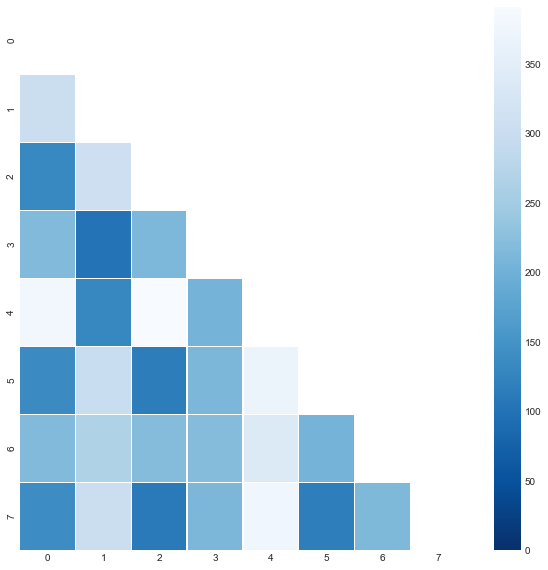


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.3421 secs


+ ------------   46    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 492, 1015, 755, 503, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 842, 852, 857, 603, 97, 867, 100, 102, 105, 874, 883, 117, 888, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 1017, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

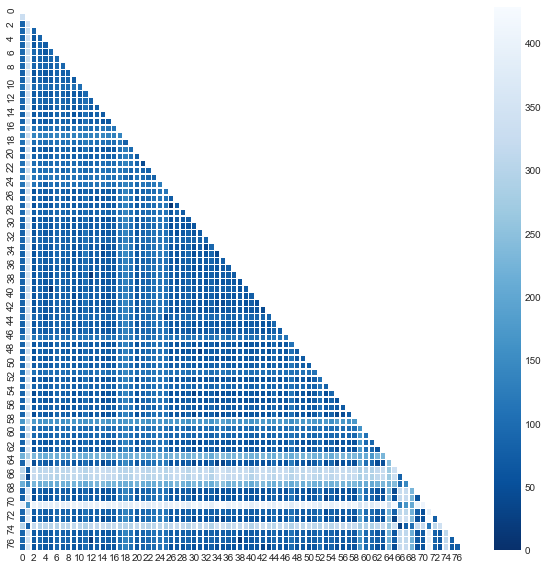


- Mean variance in prototype selection:  121.16995397764629

- Final number of prototypes:  78

# Finished in 0.7640 secs


+ ------------   47    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 488, 713, 842, 492, 883, 1015, 755, 503, 888, 1017, 1021, 510}
Final:
[3, 518, 774, 520, 9, 778, 13, 525, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 821, 60, 852, 857, 603, 97, 867, 100, 102, 105, 874, 117, 415, 418, 424, 426, 428, 430, 432, 180, 948, 442, 702, 451, 708, 453, 711, 456, 462, 720, 467, 725, 472, 729, 731, 477, 734, 480, 482, 484, 745, 1006, 496, 1009, 1011, 500, 1013, 253]

- Prototypes selected
[   3  518  774  520    9  778   13  525  783  528   17  785  531  788
   21  792   

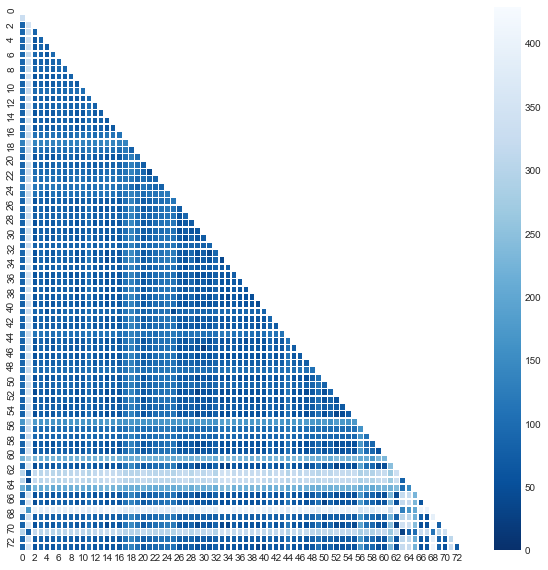


- Mean variance in prototype selection:  123.53287070854638

- Final number of prototypes:  74

# Finished in 0.7430 secs


+ ------------   48    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 418, 948, 713, 842, 720, 857, 734, 503, 100, 488, 492, 1006, 1011, 500, 883, 755, 1015, 888, 1017, 1021, 510}
Final:
[3, 774, 520, 9, 778, 525, 13, 783, 528, 17, 785, 531, 788, 21, 792, 28, 30, 415, 32, 34, 36, 38, 40, 424, 426, 428, 45, 430, 47, 432, 51, 180, 821, 442, 60, 702, 451, 708, 453, 711, 456, 462, 467, 852, 725, 472, 729, 603, 731, 477, 480, 97, 482, 867, 484, 102, 105, 745, 874, 496, 1009, 117, 1013, 253]

- Prototypes selected
[   3  774  520    9  778  525   13  783  528   17  785  531  788   21
  792   28   

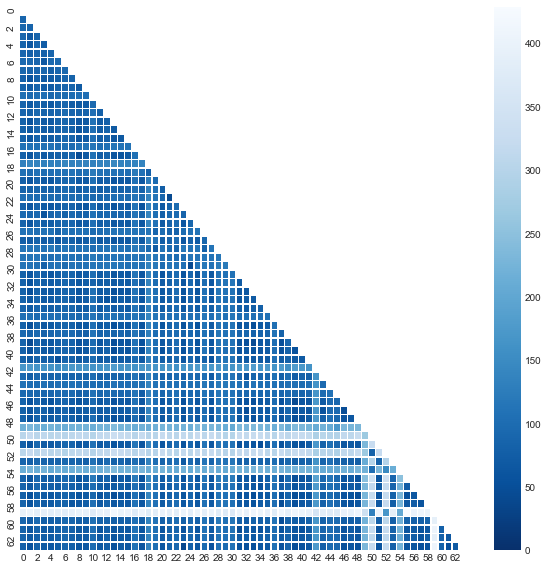


- Mean variance in prototype selection:  118.31640625

- Final number of prototypes:  64

# Finished in 0.6480 secs


+ ------------   49    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 774, 518, 778, 13, 525, 783, 528, 531, 788, 21, 792, 28, 415, 418, 36, 424, 40, 426, 428, 430, 948, 180, 821, 442, 60, 702, 708, 711, 456, 713, 842, 462, 720, 852, 729, 857, 731, 603, 734, 97, 867, 100, 503, 102, 488, 745, 874, 105, 492, 1006, 1009, 1017, 755, 883, 117, 1011, 1013, 1015, 253, 888, 500, 1021, 510}
Final:
[3, 520, 9, 17, 785, 30, 32, 34, 38, 45, 47, 432, 51, 451, 453, 467, 725, 472, 477, 480, 482, 484, 496]

- Prototypes selected
[  3 520   9  17 785  30  32  34  38  45  47 432  51 451 453 467 725 472
 477 480 48

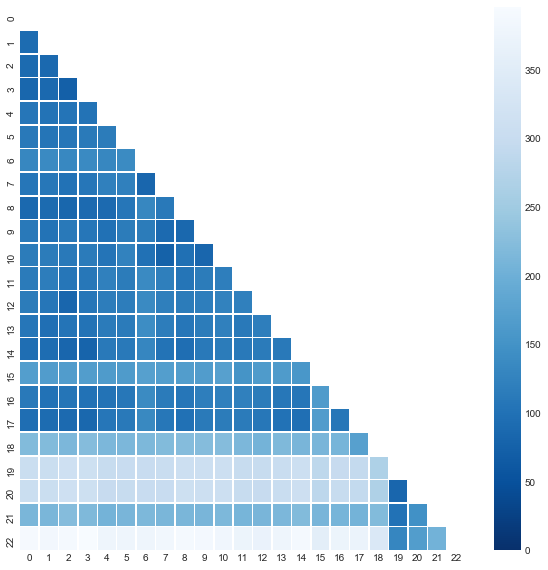


- Mean variance in prototype selection:  169.99243856332703

- Final number of prototypes:  23

# Finished in 0.4441 secs


+ ------------   50    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021]
Not wanted:
{514, 518, 520, 9, 13, 525, 528, 17, 531, 21, 28, 34, 36, 38, 40, 45, 47, 51, 60, 603, 97, 100, 102, 105, 117, 180, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 253, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 415, 418, 424, 426, 428, 430, 432, 948, 442, 453, 456, 462, 472, 482, 488, 492, 1006, 1009, 1011, 1015, 1013, 500, 503, 1017, 1021, 510}
Final:
[32, 480, 3, 451, 484, 496, 467, 477, 30]

- Prototypes selected
[ 32 480   3 451 484 496 467 477  30]
32  ->  m. dill and m. ordereddict(('date'  '(

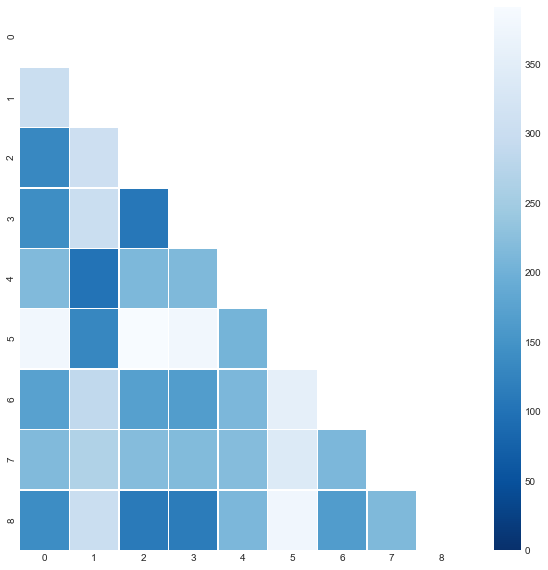


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.3041 secs


+ ------------   51    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

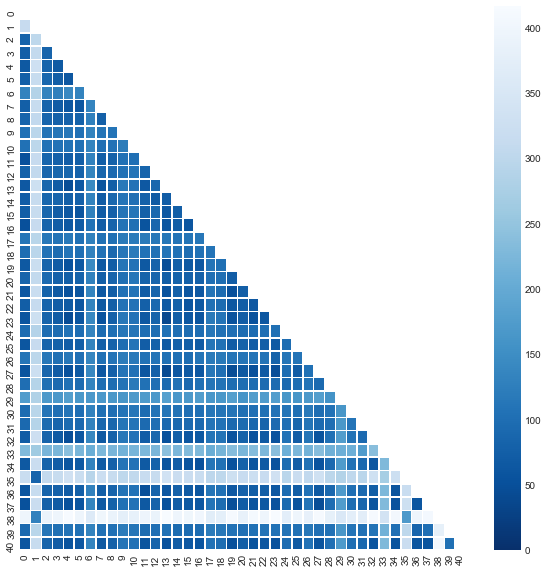


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.7164 secs


+ ------------   52    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

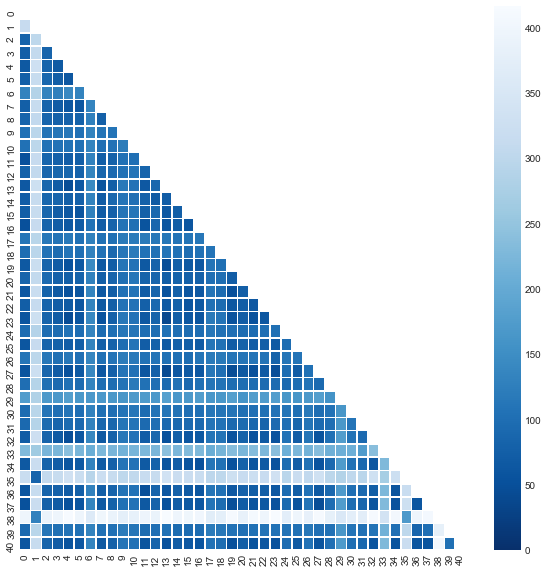


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6705 secs


+ ------------   53    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

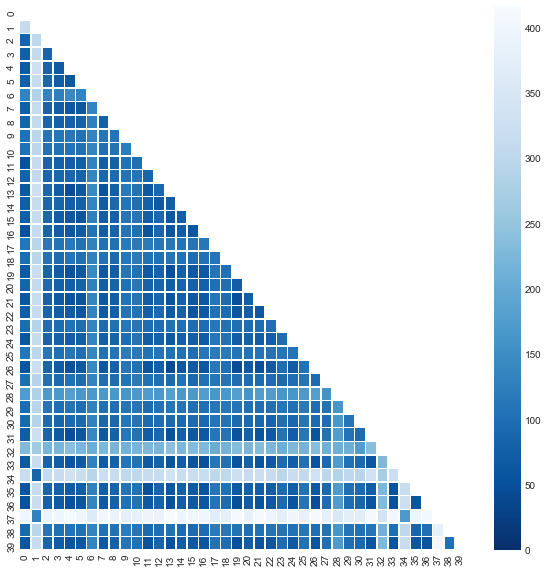


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6384 secs


+ ------------   54    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

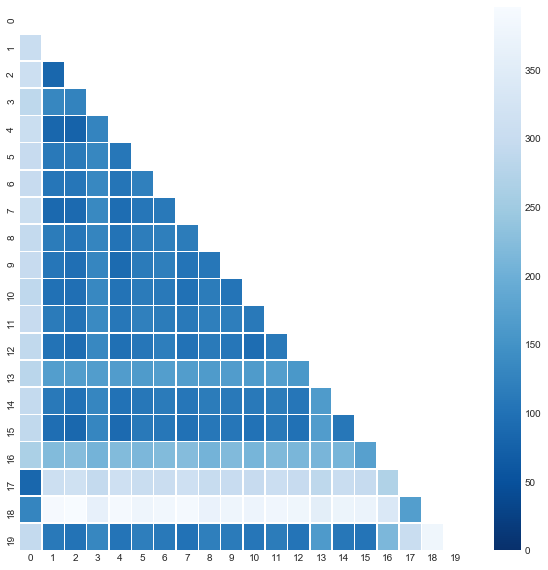


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3688 secs


+ ------------   55    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

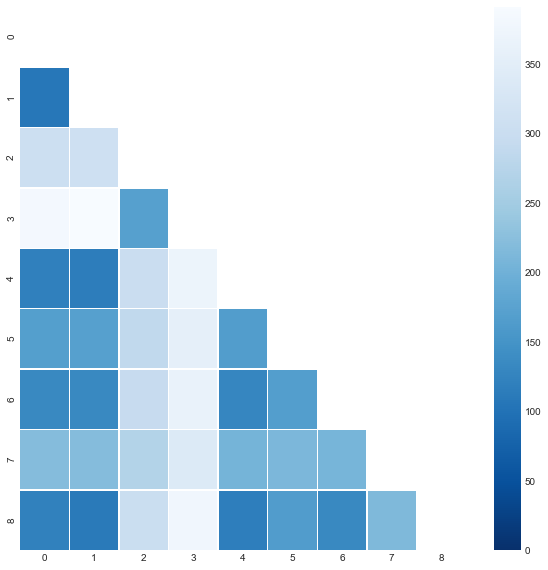


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.2869 secs


+ ------------   56    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

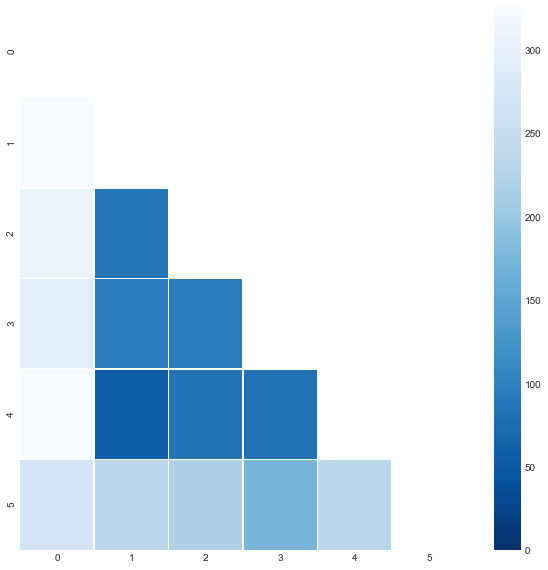


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2642 secs


+ ------------   57    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

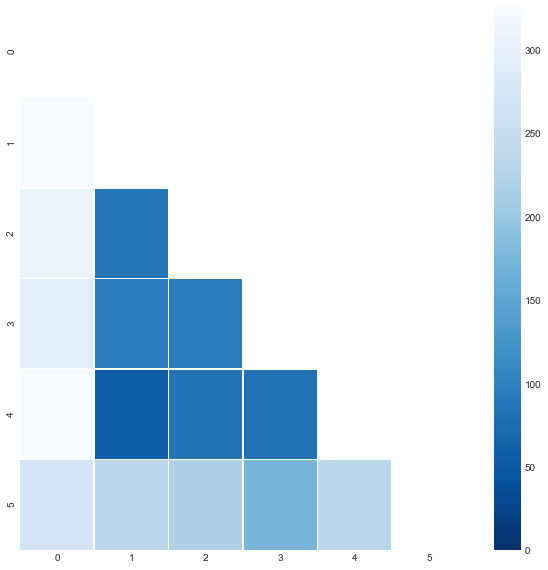


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2682 secs


+ ------------   58    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

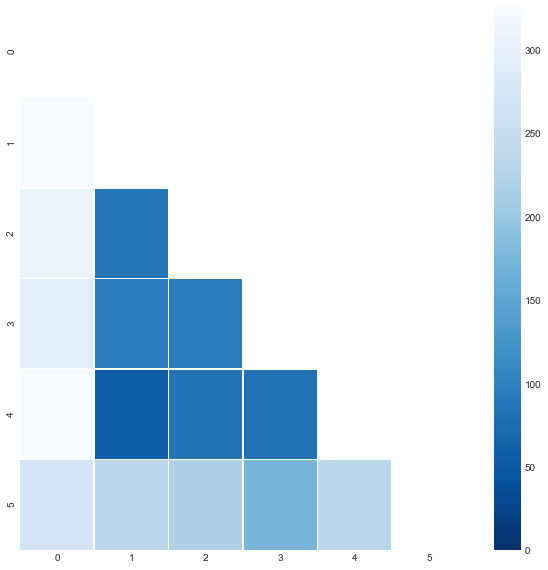


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2649 secs


+ ------------   59    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

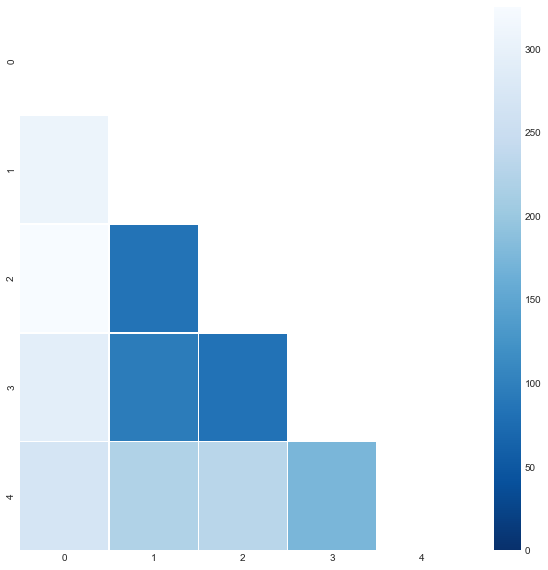


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.2611 secs


+ ------------   60    ------------- +
max_numberOf_clusters:  100
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


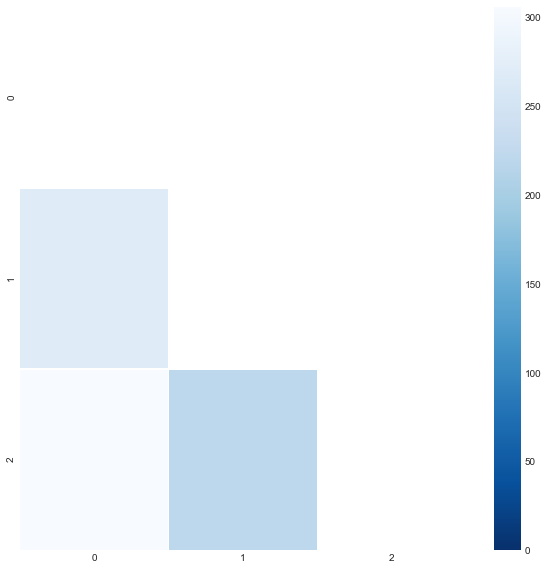


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2938 secs


+ ------------   61    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

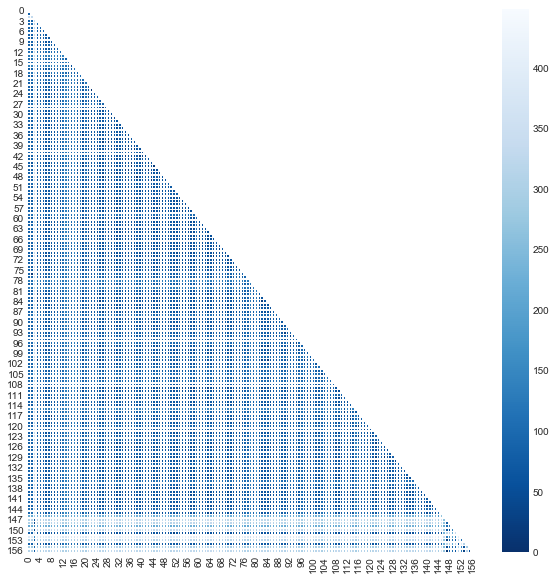


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.3190 secs


+ ------------   62    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

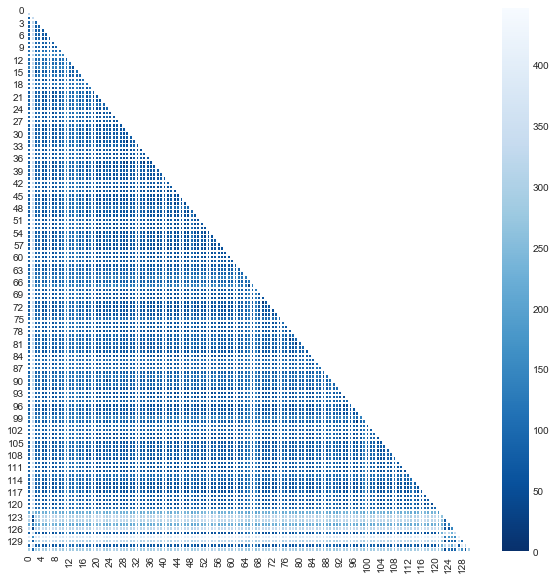


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.0455 secs


+ ------------   63    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

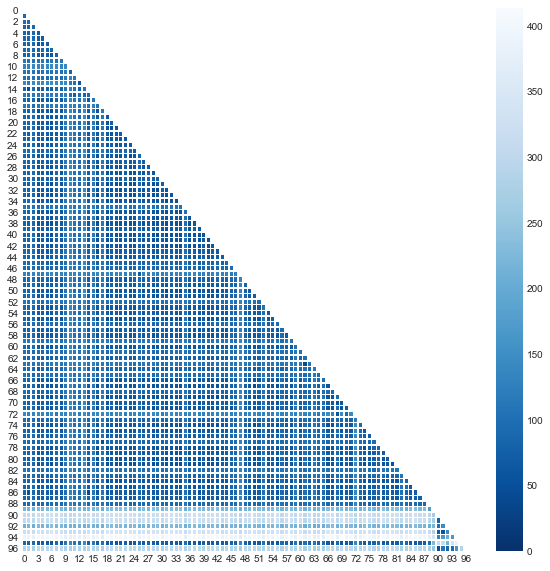


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.0630 secs


+ ------------   64    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

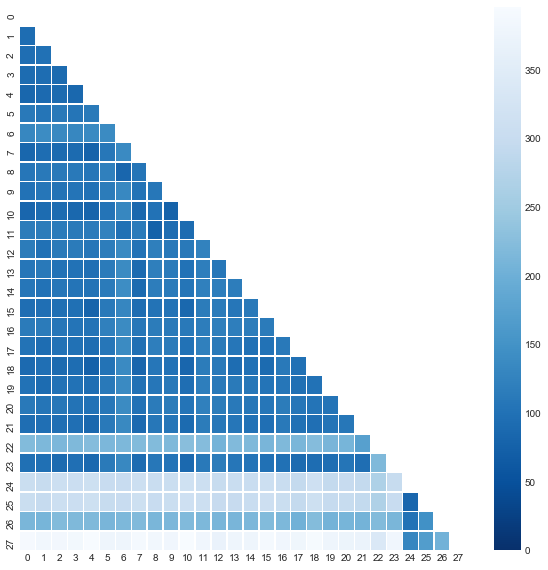


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7680 secs


+ ------------   65    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

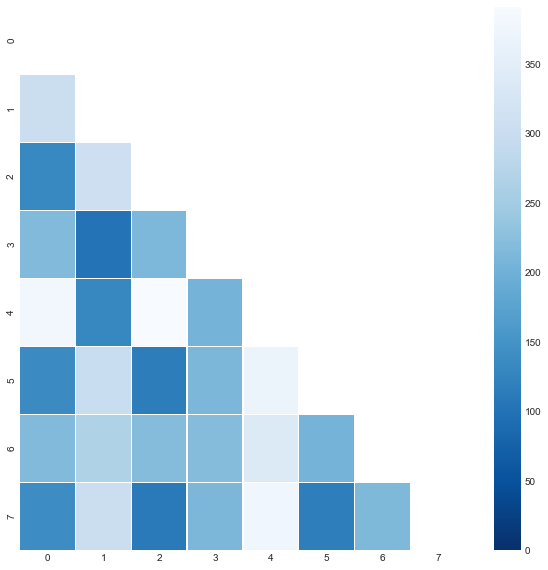


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.7115 secs


+ ------------   66    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

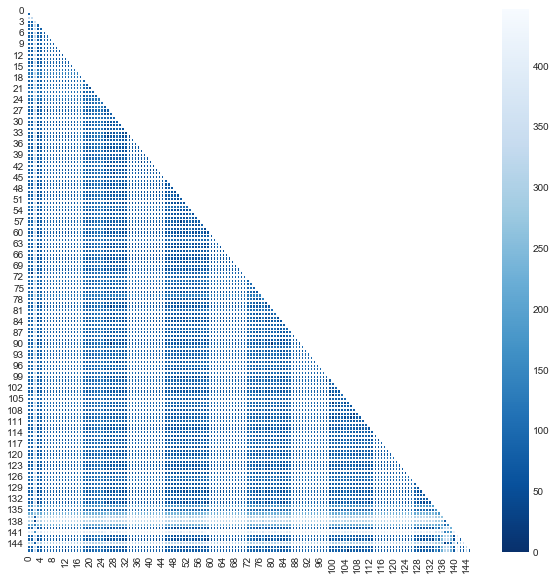


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.6804 secs


+ ------------   67    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

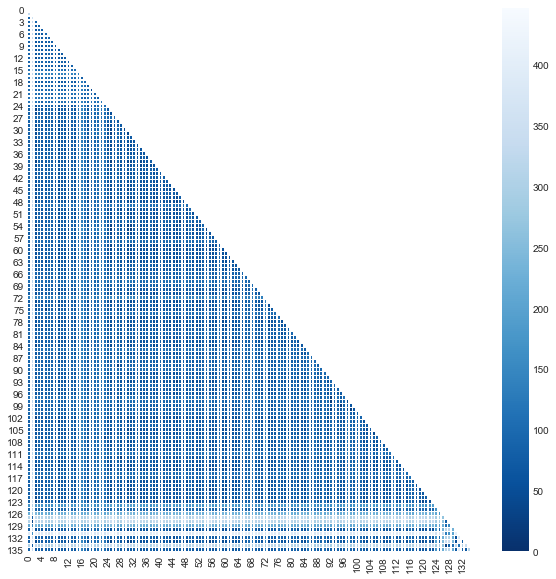


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 2.6691 secs


+ ------------   68    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

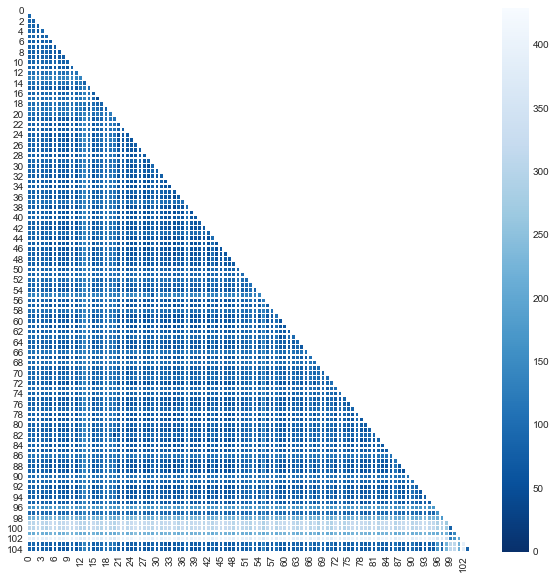


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.3818 secs


+ ------------   69    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

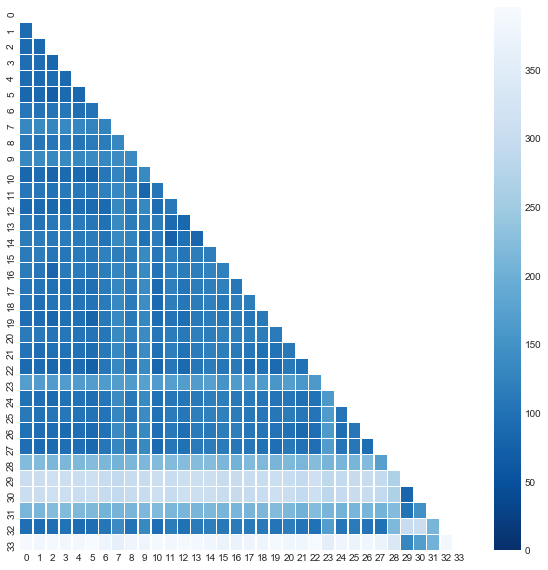


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 1.7068 secs


+ ------------   70    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

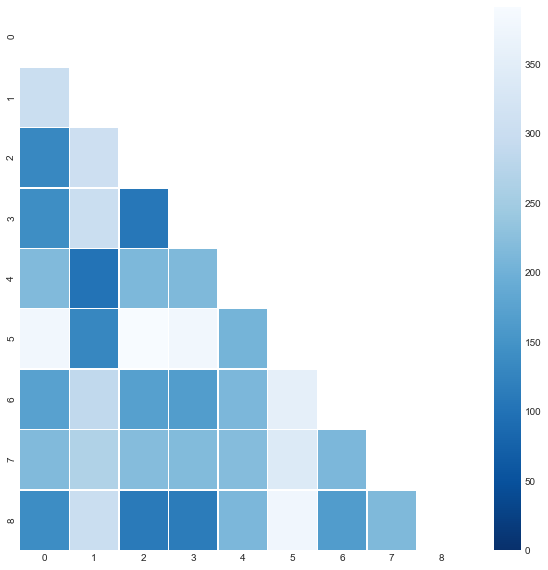


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.8057 secs


+ ------------   71    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

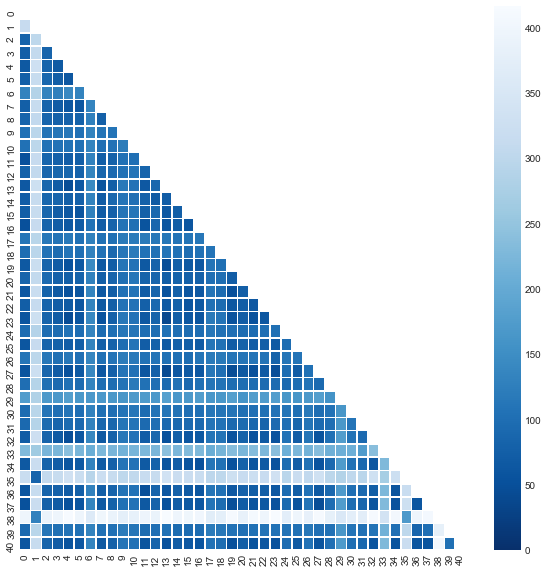


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.9068 secs


+ ------------   72    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

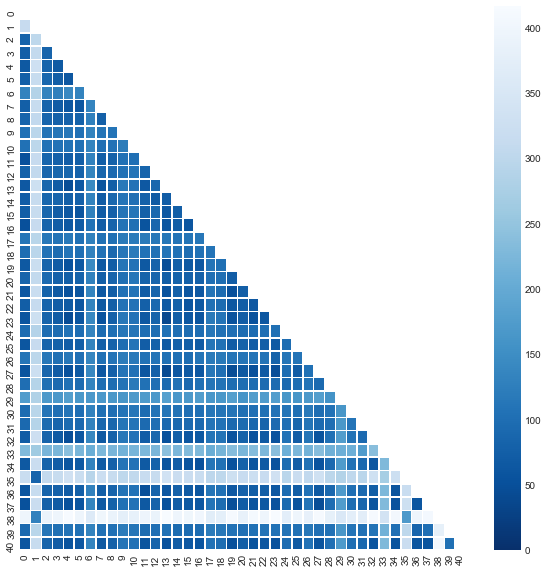


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.6513 secs


+ ------------   73    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

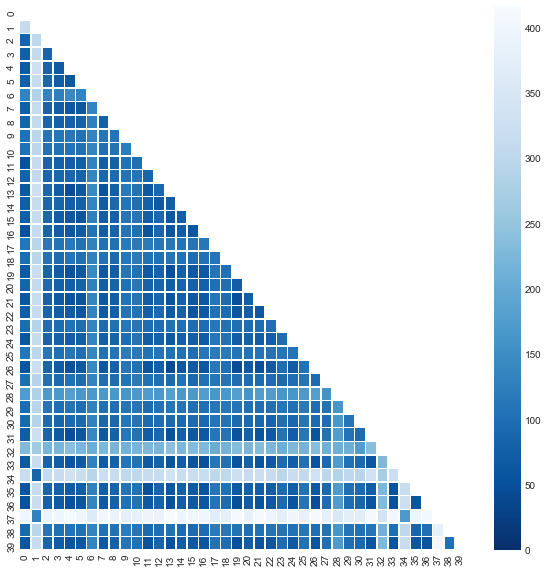


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.6598 secs


+ ------------   74    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

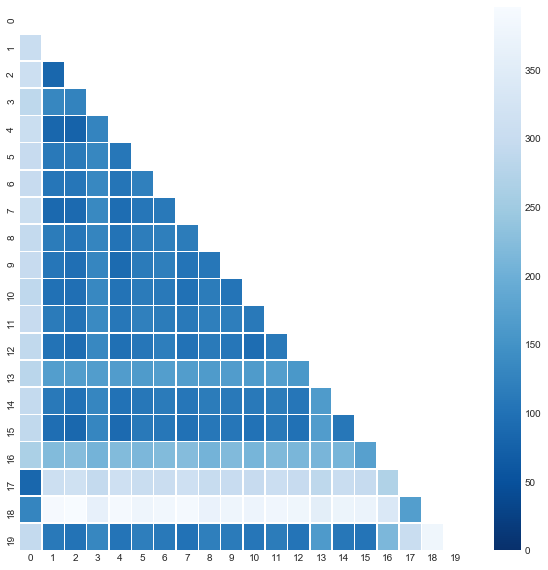


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.3801 secs


+ ------------   75    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

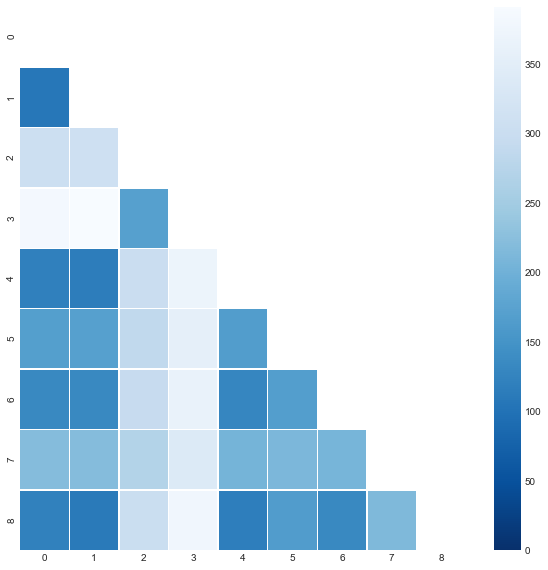


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3136 secs


+ ------------   76    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

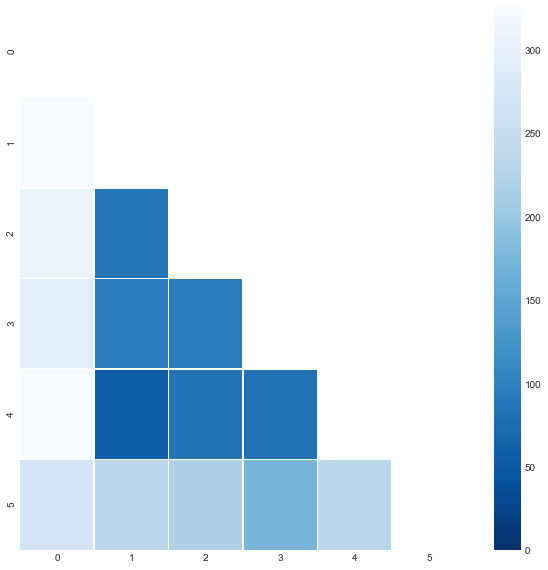


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2939 secs


+ ------------   77    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

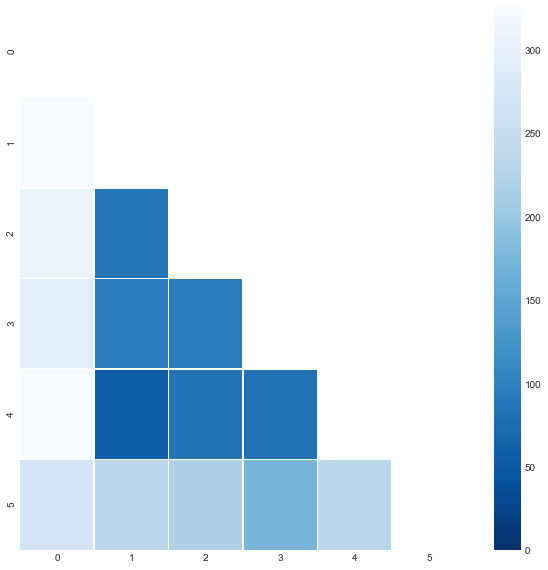


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2740 secs


+ ------------   78    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

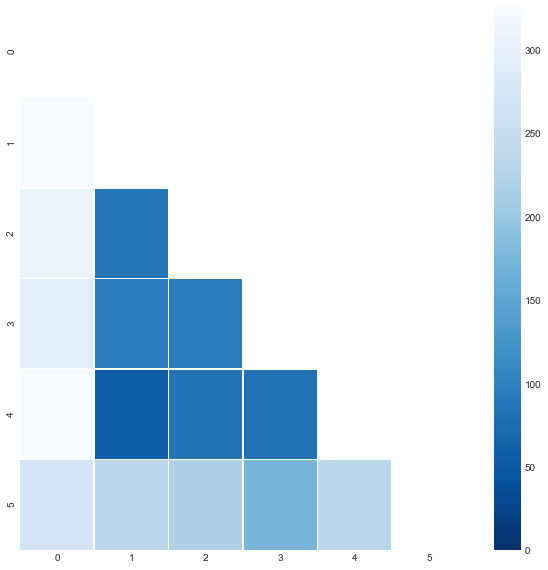


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3549 secs


+ ------------   79    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

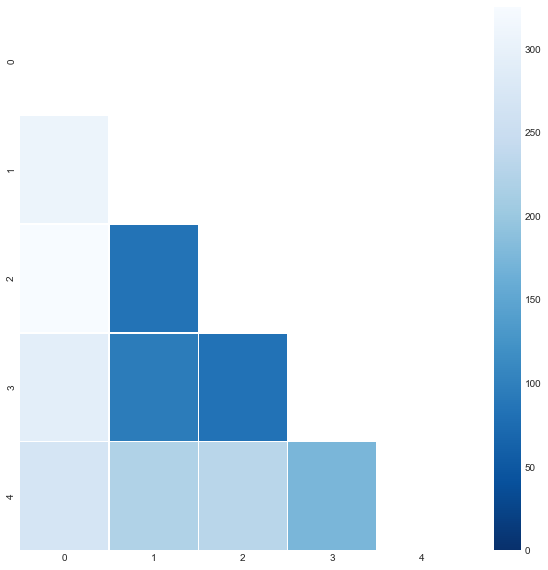


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.3153 secs


+ ------------   80    ------------- +
max_numberOf_clusters:  500
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


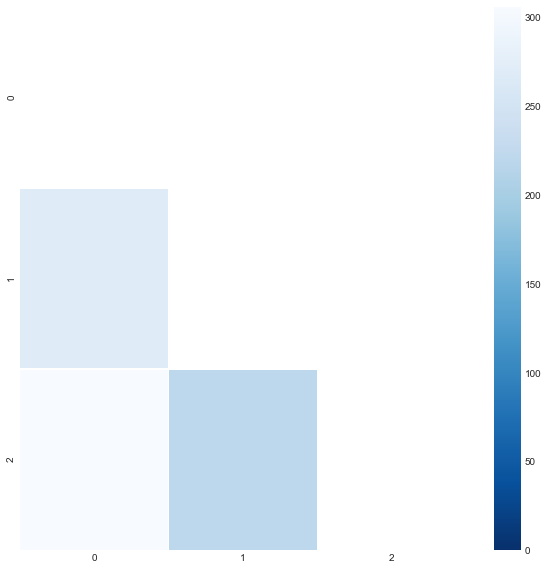


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.2838 secs


+ ------------   81    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

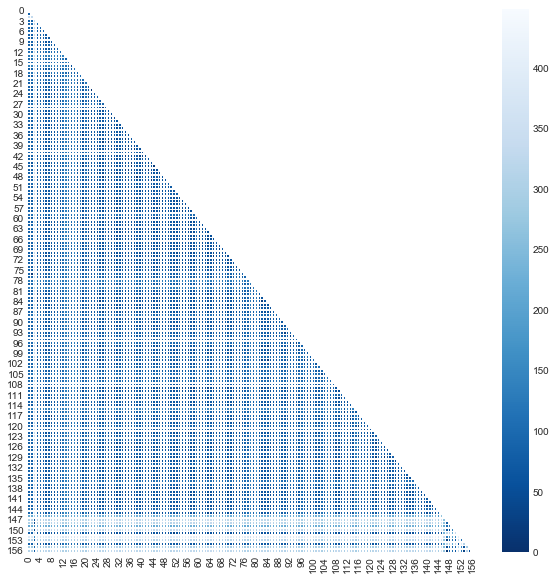


- Mean variance in prototype selection:  108.36626232301514

- Final number of prototypes:  157

# Finished in 1.3497 secs


+ ------------   82    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

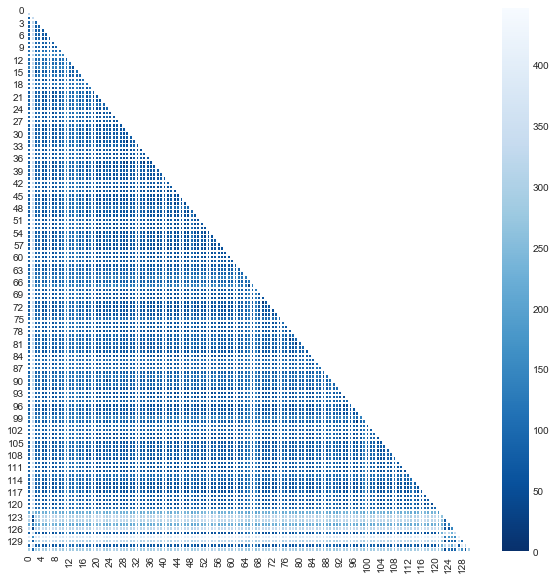


- Mean variance in prototype selection:  110.96292470156106

- Final number of prototypes:  132

# Finished in 1.0559 secs


+ ------------   83    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

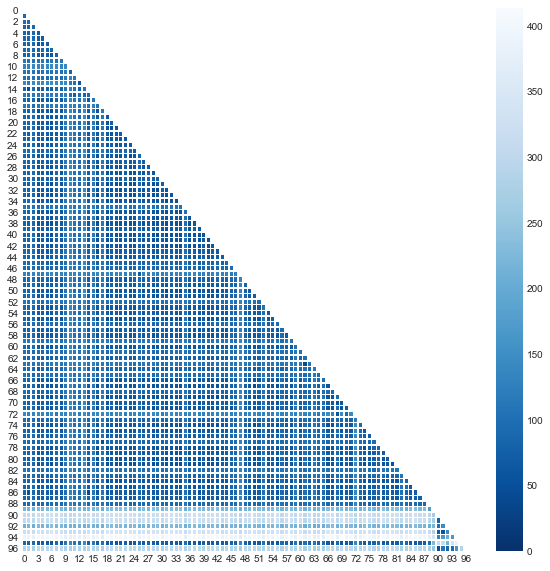


- Mean variance in prototype selection:  114.56562865341694

- Final number of prototypes:  97

# Finished in 1.2021 secs


+ ------------   84    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

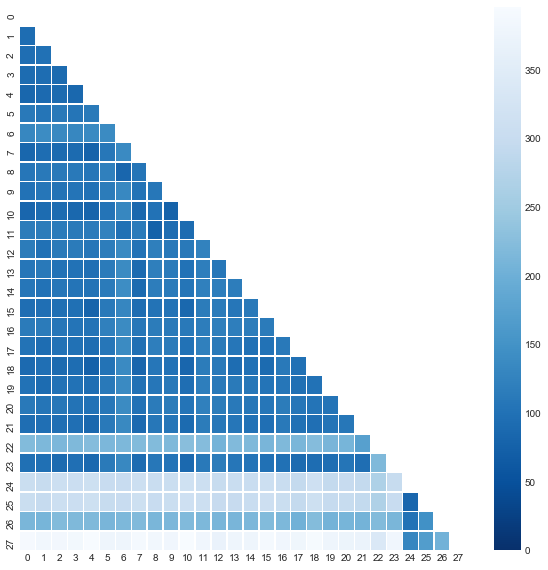


- Mean variance in prototype selection:  156.60714285714286

- Final number of prototypes:  28

# Finished in 0.7937 secs


+ ------------   85    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  50
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



25.0
Prototypes before:
[3, 13, 17, 21, 28, 30, 32, 34, 39, 41, 44, 47, 51, 59, 65, 97, 100, 105, 107, 110, 136, 152, 160, 178, 190, 203, 244, 250, 284, 309, 384, 405, 415, 419, 424, 426, 442, 451, 453, 456, 462, 472, 477, 480, 482, 484, 486, 488, 492, 496, 501, 504, 507, 511, 515, 518, 525, 531, 562, 631, 664, 668, 700, 702, 707, 711, 719, 725, 729, 731, 734, 744, 758, 771, 774, 778, 783, 788, 792, 796, 800, 822, 838, 845, 852, 857, 860, 864, 874, 882, 888, 948, 1006, 1013, 1017, 1021, 1027, 1032, 1036, 1039, 1044, 1048, 1059, 1085, 1101, 1114, 1119, 1121, 1139, 1158, 1163, 1166, 1170, 1180, 1200, 1209, 1219, 1223, 1230, 1244, 1254, 1257, 1268, 1283, 1292, 1296, 1298, 1301, 1309, 1319, 1327, 1335, 1340, 1344, 1348, 1352, 1357, 1362, 1364, 1374, 1379, 1385, 1389, 1393, 1397, 1401, 1403, 1408, 1412, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1495, 1500, 1512, 1531, 1557, 1579, 1590, 1604, 1619, 1626, 1646, 1657, 1663, 1677, 1694, 1712, 1732, 1768, 1774, 1779, 1798, 182

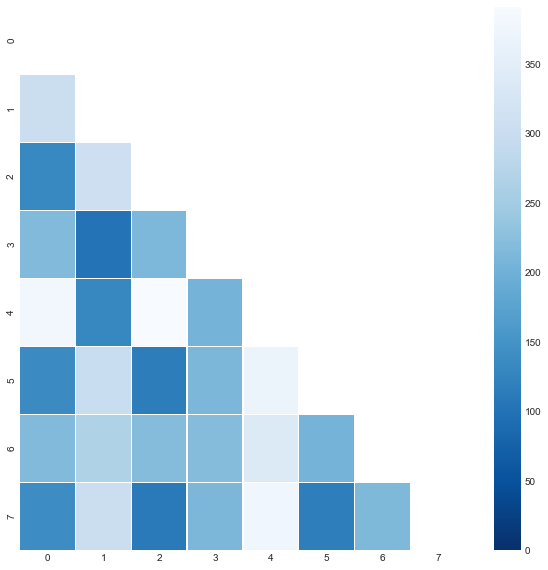


- Mean variance in prototype selection:  201.34375

- Final number of prototypes:  8

# Finished in 0.5648 secs


+ ------------   86    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 488, 713, 492, 1168, 1015, 755, 1044, 503, 1401, 1021, 510}
Final:
[3, 1027, 518, 1542, 5

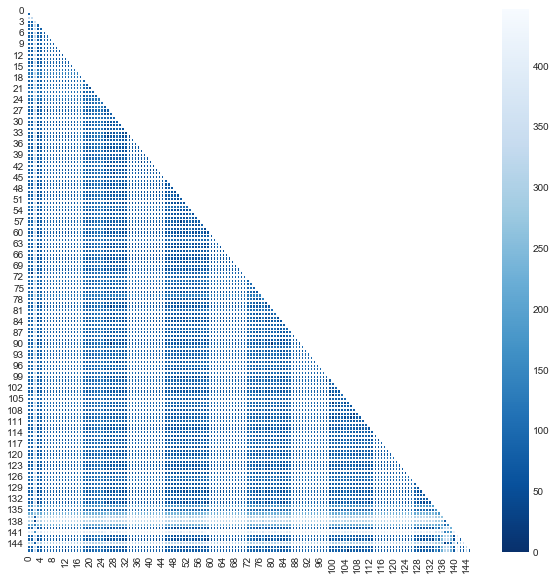


- Mean variance in prototype selection:  103.39256791151836

- Final number of prototypes:  147

# Finished in 1.0734 secs


+ ------------   87    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 1401, 1168, 1683, 1044, 1093, 713, 842, 1373, 1120, 503, 488, 492, 883, 755, 1779, 

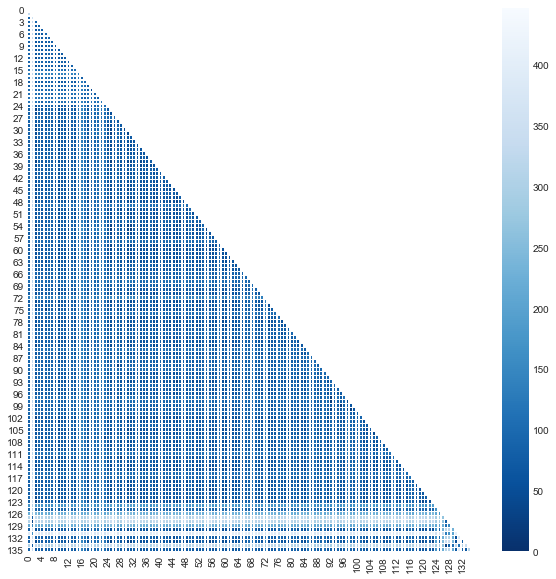


- Mean variance in prototype selection:  105.50637975778547

- Final number of prototypes:  136

# Finished in 0.9877 secs


+ ------------   88    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{1409, 514, 1027, 518, 1542, 1416, 1401, 1034, 1168, 1683, 1044, 1403, 1816, 1694, 418, 1192, 1320, 1

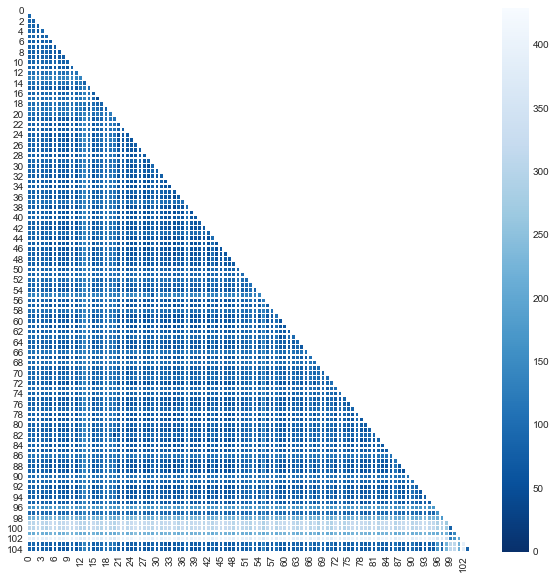


- Mean variance in prototype selection:  105.76580498866213

- Final number of prototypes:  105

# Finished in 1.2133 secs


+ ------------   89    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 1034, 13, 525, 1039, 528, 531, 1044, 21, 1048, 28, 36, 40, 60, 1598, 1093, 162

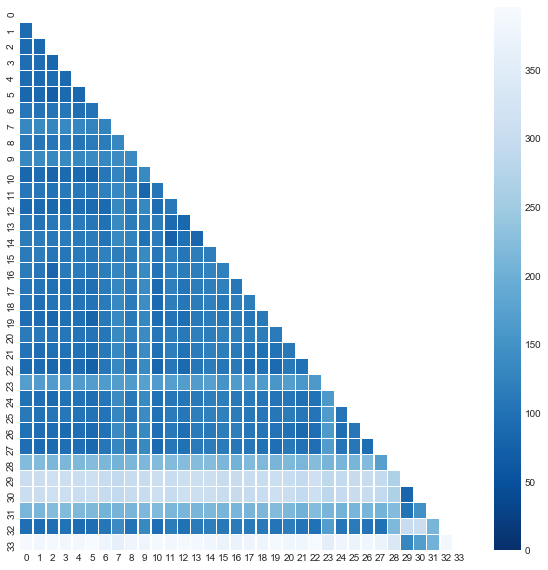


- Mean variance in prototype selection:  153.26643598615917

- Final number of prototypes:  34

# Finished in 0.9140 secs


+ ------------   90    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  100
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



50.0
Prototypes before:
[3, 9, 13, 17, 21, 28, 30, 32, 34, 36, 38, 40, 45, 47, 51, 60, 97, 100, 102, 105, 117, 180, 253, 415, 418, 424, 426, 428, 430, 432, 442, 451, 453, 456, 462, 467, 472, 477, 480, 482, 484, 488, 492, 496, 500, 503, 510, 514, 518, 520, 525, 528, 531, 603, 702, 708, 711, 713, 720, 725, 729, 731, 734, 745, 755, 774, 778, 783, 785, 788, 792, 821, 842, 852, 857, 867, 874, 883, 888, 948, 1006, 1009, 1011, 1013, 1015, 1017, 1021, 1027, 1034, 1039, 1044, 1048, 1093, 1114, 1120, 1134, 1148, 1166, 1168, 1192, 1218, 1231, 1244, 1256, 1259, 1268, 1283, 1292, 1296, 1306, 1320, 1327, 1335, 1343, 1348, 1352, 1357, 1362, 1364, 1368, 1373, 1385, 1391, 1395, 1397, 1401, 1403, 1409, 1416, 1421, 1429, 1440, 1450, 1464, 1473, 1480, 1483, 1487, 1489, 1542, 1598, 1621, 1646, 1683, 1694, 1712, 1739, 1756, 1768, 1774, 1779, 1816, 1848, 1851, 1853, 1859, 1864, 1867, 1870, 1878]
Not wanted:
{514, 1027, 1542, 518, 520, 9, 1034, 13, 525, 1039, 528, 17, 531, 1044, 21, 1048, 28, 34, 36, 38, 40,

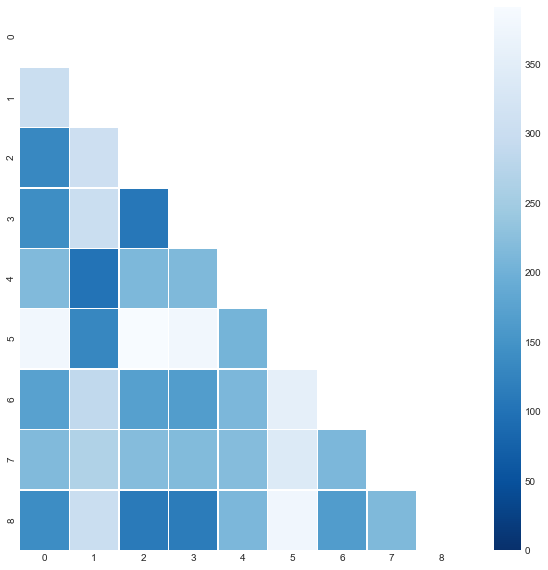


- Mean variance in prototype selection:  202.46913580246914

- Final number of prototypes:  9

# Finished in 0.7639 secs


+ ------------   91    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

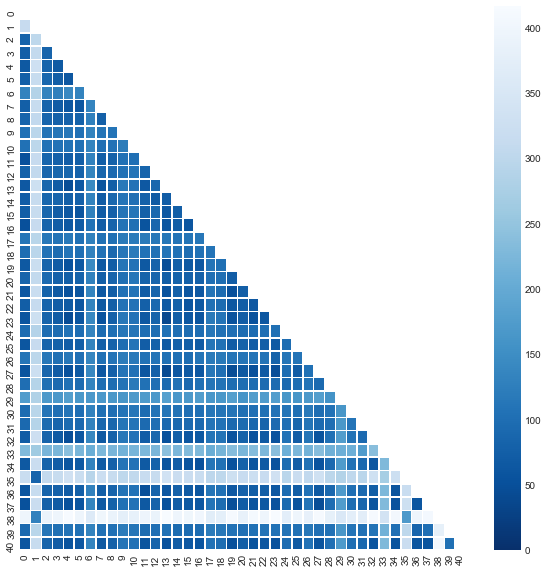


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.9022 secs


+ ------------   92    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
set()
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1861 1478  457 1867  718
 1870  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalsk

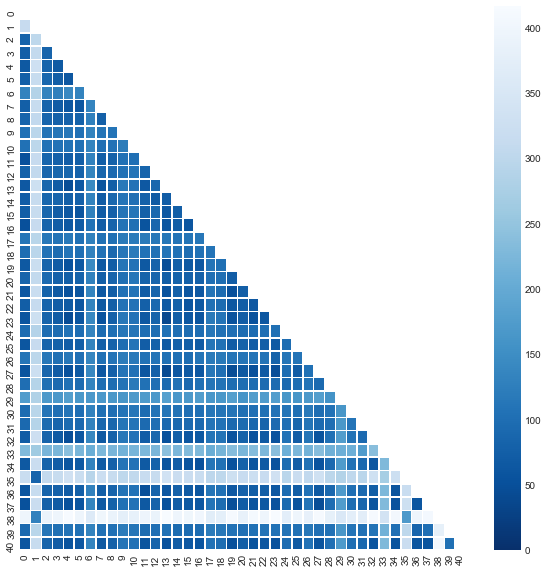


- Mean variance in prototype selection:  130.2558001189768

- Final number of prototypes:  41

# Finished in 0.8638 secs


+ ------------   93    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{1861}
Final:
[640, 514, 3, 17, 21, 24, 1306, 28, 1437, 30, 34, 804, 38, 1577, 46, 1327, 1202, 51, 1336, 442, 1343, 707, 452, 1478, 457, 1867, 718, 1870, 467, 726, 471, 1878, 476, 1123, 488, 1261, 751, 496, 1392, 243]

- Prototypes selected
[ 640  514    3   17   21   24 1306   28 1437   30   34  804   38 1577
   46 1327 1202   51 1336  442 1343  707  452 1478  457 1867  718 1870
  467  726  471 1878  476 1123  488 1261  751  496 1392  243]
640  ->  aha  d.  kibler  d.  & albert  m. instance-based learning algorithms. machine learning
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitc

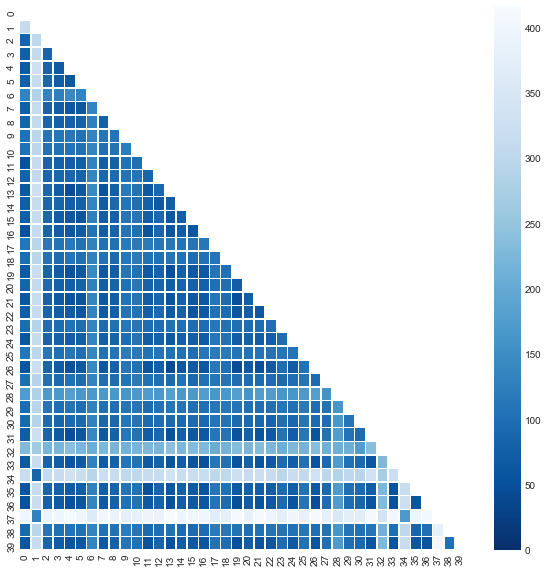


- Mean variance in prototype selection:  131.6675

- Final number of prototypes:  40

# Finished in 0.7101 secs


+ ------------   94    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 21, 24, 28, 804, 1577, 46, 1327, 1202, 442, 1343, 707, 452, 1861, 457, 718, 1878, 1123, 1261, 751, 243}
Final:
[514, 3, 17, 1306, 1437, 30, 34, 38, 51, 1336, 1478, 1867, 1870, 467, 726, 471, 476, 488, 496, 1392]

- Prototypes selected
[ 514    3   17 1306 1437   30   34   38   51 1336 1478 1867 1870  467
  726  471  476  488  496 1392]
514  ->  s.b. thrun  j. bala  e. bloedorn  i. bratko  b. cestnik  j. cheng  k. de jong  s. dzeroski  s.e. fahlman  d. fisher  r. hamann  k. kaufman  s. keller  i. kononenko  j. kreuziger  r.s. michalski  t. mitchell  p. pachowicz  y. reich  h. vafaie  w. van de welde  w. wenzel  j. wnek  and j. zhang  the monk's problems a performance comparison of different learning algorithms. nan
3  ->  m. ahlskog  j. 

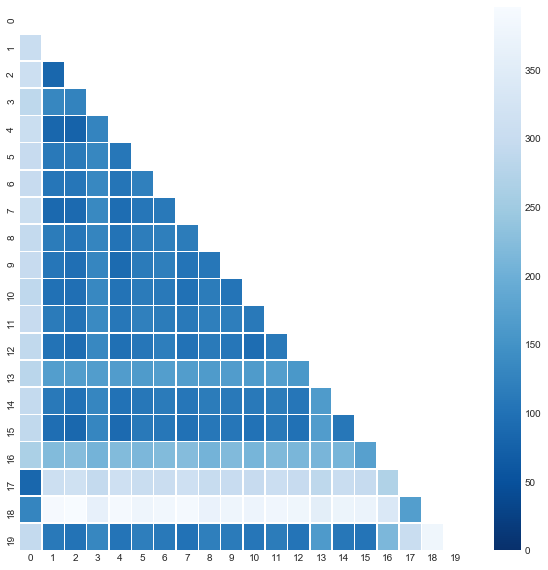


- Mean variance in prototype selection:  171.56

- Final number of prototypes:  20

# Finished in 0.4699 secs


+ ------------   95    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  200
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



100.0
Prototypes before:
[3, 17, 21, 24, 28, 30, 34, 38, 46, 51, 243, 442, 452, 457, 467, 471, 476, 488, 496, 514, 640, 707, 718, 726, 751, 804, 1123, 1202, 1261, 1306, 1327, 1336, 1343, 1392, 1437, 1478, 1577, 1861, 1867, 1870, 1878]
Not wanted:
{640, 514, 17, 21, 24, 28, 1437, 804, 38, 1577, 46, 1327, 1202, 1336, 442, 1343, 707, 452, 1861, 1478, 457, 1867, 718, 1870, 1878, 471, 726, 1123, 1261, 751, 1392, 243}
Final:
[34, 3, 488, 496, 51, 467, 1306, 476, 30]

- Prototypes selected
[  34    3  488  496   51  467 1306  476   30]
34  ->  m. dill and m. ordereddict(('date'  '(1997b)')  ('#text'  'fahle  the role of visual field position in pattern-discrimination learning.')) nan
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
488  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnink  b.  cheng  j.  dejong  k.a.  dzeroski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  mi

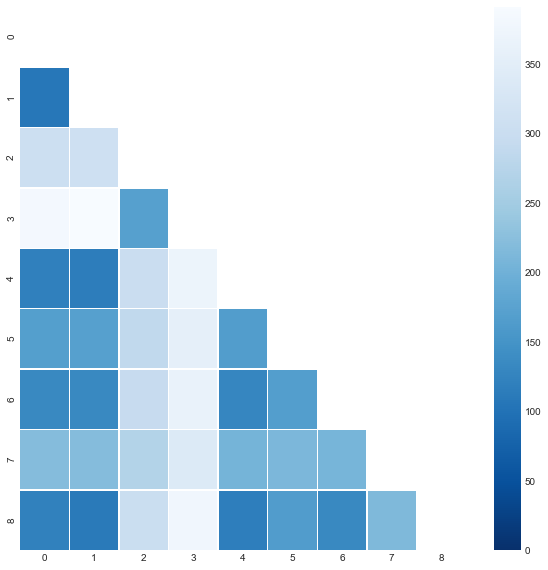


- Mean variance in prototype selection:  201.11111111111111

- Final number of prototypes:  9

# Finished in 0.3231 secs


+ ------------   96    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  10
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

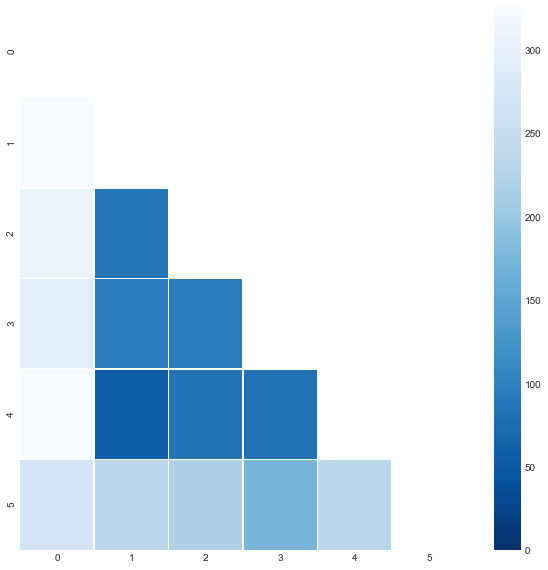


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.2958 secs


+ ------------   97    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  20
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

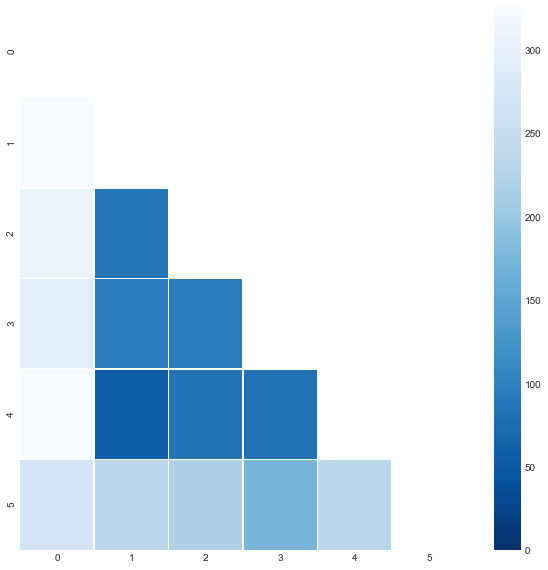


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.4242 secs


+ ------------   98    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  40
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
set()
Final:
[482, 1653, 6, 472, 362, 476]

- Prototypes selected
[ 482 1653    6  472  362  476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
1653  ->  utgoff  p. e. incremental induction of decision trees. machine learning 
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
476  ->  common lisp: the lan

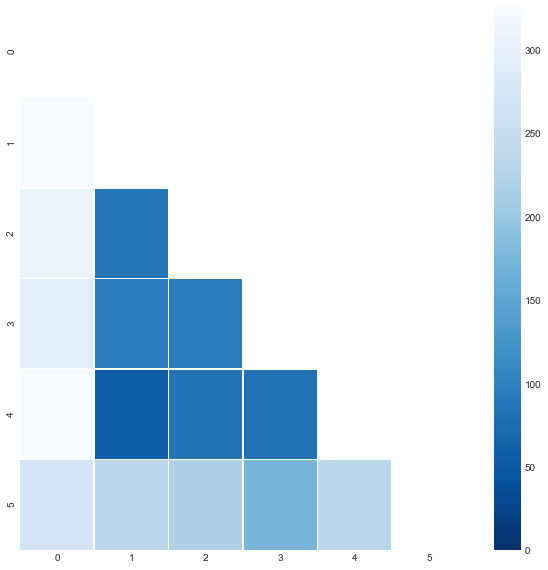


- Mean variance in prototype selection:  159.83333333333334

- Final number of prototypes:  6

# Finished in 0.3237 secs


+ ------------   99    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  70
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{1653}
Final:
[482, 6, 362, 472, 476]

- Prototypes selected
[482   6 362 472 476]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
362  ->  s. e. fahlman and c. lebiere. the cascade-correlation architecture. nan
472  ->  guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  and daniel l. weinreb. common lisp: the language. nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon 

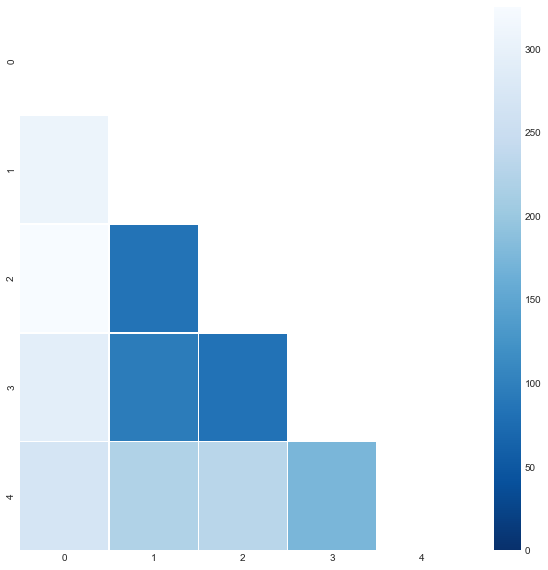


- Mean variance in prototype selection:  166.48

- Final number of prototypes:  5

# Finished in 0.4143 secs


+ ------------   100    ------------- +
max_numberOf_clusters:  1000
max_editDistancez:  300
similarityThreshold:  0.7
windowSize:  50
metric:  kendal
similarityVectors:  ranked
distanceMetricEmbedding:  euclidean
distanceMetric:  edit
number_of_permutations:  5
withchars:  False
ngramms:  False
prototypeFilter:  100
+ ----------------------------------- +

#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:



150.0
Prototypes before:
[6, 362, 472, 476, 482, 1653]
Not wanted:
{472, 362, 1653}
Final:
[482, 476, 6]

- Prototypes selected
[482 476   6]
482  ->  thrun  s.b.  bala  j.  bloedorn  e.  bratko  i.  cestnik  b.  cheng  j.  de jong  k.  dzerowski  s.  fahlman  s.e.  hamann  r.  kaufman  k.  keller  s.  kononenko  i.  kreuziger  j.  michalski  r.s.  mitchell  t.  pachowicz  p.  vafaie  h.  van de velde  w.  wenzel  w.  wnek  j.  and zhang  j.  the monks problems: a performance comparison of different learning algorithms  nan
476  ->  common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
6  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 


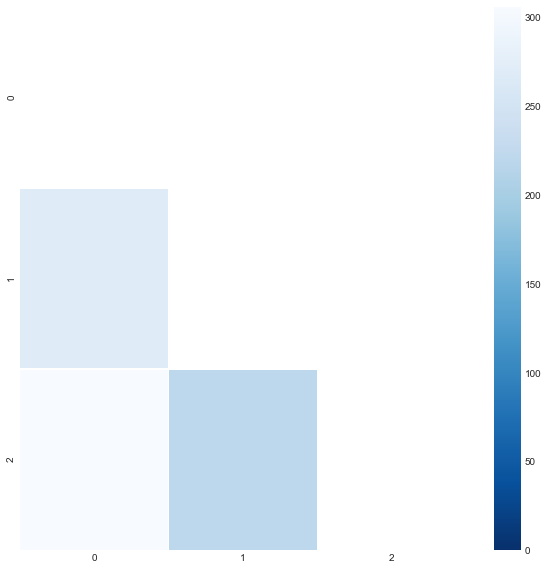


- Mean variance in prototype selection:  176.66666666666666

- Final number of prototypes:  3

# Finished in 0.3375 secs





In [38]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [50,100,200,300]
prototypesFilterThr = [10,20,40,70,100]

distanceMetric= ['edit']


ngramms= [3]  
jaccard_withchars = [False] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [39]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

max_numberOf_clusters max_editDistance prototypesFilterThr numOfPrototypes  \
61                   500               50                  10             157   
81                  1000               50                  10             157   
86                  1000              100                  10             147   
66                   500              100                  10             147   
67                   500              100                  20             136   
87                  1000              100                  20             136   
62                   500               50                  20             132   
82                  1000               50                  20             132   
88                  1000              100                  40             105   
68                   500              100                  40             105   
63                   500               50                  40              97   
83                  1000               50                  40              97   
46                   100              100                  10              78   
47                   100              100                  20              74   
48                   100              100                  40              64   
41                   100               50                  10              47   
42                   100               50                  20              42   
32                    50              200                  20              41   
91                  1000              200                  10              41   
71                   500              200                  10              41   

   protSelectionVariance  
61               108.366  
81               108.366  
86               103.393  
66               103.393  
67               105.506  
87               105.506  
62               110.963  
82               110.963  
88               105.766  
68               105.766  
63               114.566  
83               114.566  
46                121.17  
47               123.533  
48               118.316  
41                161.23  
42               162.773  
32               130.256  
91               130.256  
71               130.256

In [40]:
results_section1_edit[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

max_numberOf_clusters max_editDistance prototypesFilterThr  \
50                    100              100                 100   
70                    500              100                 100   
90                   1000              100                 100   
65                    500               50                 100   
45                    100               50                 100   
85                   1000               50                 100   
55                    100              200                 100   
95                   1000              200                 100   
35                     50              200                 100   
75                    500              200                 100   
44                    100               50                  70   
100                  1000              300                 100   
20                     10              300                 100   
40                     50              300                 100   
80                    500              300                 100   
60                    100              300                 100   
30                     50              100                 100   
94                   1000              200                  70   
54                    100              200                  70   
34                     50              200                  70   
74                    500              200                  70   
49                    100              100                  70   
19                     10              300                  70   
59                    100              300                  70   
39                     50              300                  70   
99                   1000              300                  70   
79                    500              300                  70   
42                    100               50                  20   
41                    100               50                  10   
38                     50              300                  40   
56                    100              300                  10   
96                   1000              300                  10   
18                     10              300                  40   
97                   1000              300                  20   
57                    100              300                  20   
36                     50              300                  10   
37                     50              300                  20   
58                    100              300                  40   
76                    500              300                  10   
77                    500              300                  20   
78                    500              300                  40   
16                     10              300                  10   
17                     10              300                  20   
98                   1000              300                  40   
64                    500               50                  70   
84                   1000               50                  70   
43                    100               50                  40   
29                     50              100                  70   
89                   1000              100                  70   
69                    500              100                  70   

    numOfPrototypes protSelectionVariance  
50                9               202.469  
70                9               202.469  
90                9               202.469  
65                8               201.344  
45                8               201.344  
85                8               201.344  
55                9               201.111  
95                9               201.111  
35                9               201.111  
75                9               201.111  
44               18               177.772  
100               3               176.667  
20                3               176.667  
40                3  

##### Jaccard

In [ ]:
max_numberOf_clusters= [10,50,100,500,1000]
max_editDistance= [0.3,0.6,0.7,0.8]
prototypesFilterThr = [0.2,0.3,0.4,0.7,0.8]

distanceMetric= ['jaccard']


ngramms= [3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_editDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['numOfPrototypes'], ascending=False).head(20)

In [ ]:
results_section1_jac[["max_numberOf_clusters","max_editDistance","prototypesFilterThr","numOfPrototypes","protSelectionVariance"]].sort_values(by=['protSelectionVariance'], ascending=False).head(50)

### Performance details

#### Embeddings

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

#### Grid Search

In [ ]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [ ]:
# results.sort_values(by=['Accuracy'],ascending=False)

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)